In [1]:
import re
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm

import folium
from folium import plugins
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, LineString, box
import networkx as nx
import gurobipy as gb

## Load data

In [2]:
def get_segment_stops(segment_df, route_id, direction_id=0):
    segment_distance = segment_df.query(
        "route_id == @route_id & direction_id == @direction_id"
    )

    stops_in_route = stops[
        stops["stop_id"].isin(
            list(
                set(
                    segment_distance[["start_stop_id", "end_stop_id"]].values.reshape(
                        -1
                    )
                )
            )
        )
    ]

    return segment_distance, stops_in_route


segments = pd.read_csv("segments.csv")
stops = pd.read_csv("stops.csv")

segments[["route_id", "start_stop_id", "end_stop_id"]] = segments[
    ["route_id", "start_stop_id", "end_stop_id"]
].astype(str)


### Get stops on route
routes = ["24", "51", "67", "18", "33", "45", "80"]
route_details = {}

for r in routes:
    detail = get_segment_stops(segments, r, 0)

    route_details[r] = {}
    route_details[r]["segment"] = detail[0]
    route_details[r]["stops"] = detail[1]

stops_df = pd.concat([v["stops"] for k, v in route_details.items()]).drop_duplicates()

print(f"Number of total stops in routes: {len(stops_df)}")

stops_df["geometry"] = stops_df.apply(
    lambda x: Point((float(x.stop_lon), float(x.stop_lat))), axis=1
)

stops_df_gpd = gpd.GeoDataFrame(stops_df, geometry="geometry").drop(
    columns=["location_type", "parent_station", "wheelchair_boarding"]
)

stops_df_gpd.head()

Number of total stops in routes: 326


,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,geometry
1769,51241,51241,Station Villa-Maria,45.479704,-73.619643,https://www.stm.info/fr/recherche#stq=51241,POINT (-73.61964 45.47970)
1806,51281,51281,Décarie / Duquette,45.478389,-73.618050,https://www.stm.info/fr/recherche#stq=51281,POINT (-73.61805 45.47839)
1848,51326,51326,Décarie / Notre-Dame-de-Grâce,45.477244,-73.615513,https://www.stm.info/fr/recherche#stq=51326,POINT (-73.61551 45.47724)
1891,51372,51372,Décarie / Côte-Saint-Antoine,45.476312,-73.613443,https://www.stm.info/fr/recherche#stq=51372,POINT (-73.61344 45.47631)
1976,51462,51462,Décarie / Sherbrooke,45.474535,-73.609490,https://www.stm.info/fr/recherche#stq=51462,POINT (-73.60949 45.47454)


### Take a random sample of stops

In [5]:
random_stops_df_gpd = stops_df_gpd.sample(n=20, random_state=4)
random_stops_df_gpd.head()

# Add a depot stop to the dataframe
depot = pd.DataFrame(
    {
        "stop_id": ["0"],
        "stop_name": ["Depot"],
        "stop_lat": [45.5048542],
        "stop_lon": [-73.5691235],
        "stop_code": 0.0,
    }
)

depot["geometry"] = Point((float(depot.stop_lon), float(depot.stop_lat)))

random_stops_df_gpd = pd.concat([depot, random_stops_df_gpd]).reset_index(drop=True)

print(f"Number of stops in sample: {len(random_stops_df_gpd)}")

random_stops_df_gpd

Number of stops in sample: 21


,stop_id,stop_name,stop_lat,stop_lon,stop_code,geometry,stop_url
0,0,Depot,45.504854,-73.569124,0.0,POINT (-73.5691235 45.5048542),NaN
1,52277,Sherbrooke / Peel,45.501628,-73.576634,52277.0,POINT (-73.576634 45.501628),https://www.stm.info/fr/recherche#stq=52277
2,52129,Beaubien / Pie-IX,45.562434,-73.579716,52129.0,POINT (-73.579716 45.562434),https://www.stm.info/fr/recherche#stq=52129
3,51951,Sherbrooke / Atwater,45.491066,-73.588043,51951.0,POINT (-73.588043 45.491066),https://www.stm.info/fr/recherche#stq=51951
4,55306,Langelier / Renoir,45.611169,-73.608281,55306.0,POINT (-73.608281 45.611169),https://www.stm.info/fr/recherche#stq=55306
5,51032,Queen-Mary / Trans Island,45.484048,-73.628631,51032.0,POINT (-73.628631 45.484048),https://www.stm.info/fr/recherche#stq=51032
6,56286,Sherbrooke / Greene,45.487726,-73.591902,56286.0,POINT (-73.591902 45.487726),https://www.stm.info/fr/recherche#stq=56286
7,53353,Haig / No 2105,45.580908,-73.525611,53353.0,POINT (-73.525611 45.580908),https://www.stm.info/fr/recherche#stq=53353
8,54626,Beaubien / des Roseraies,45.596495,-73.555027,54626.0,POINT (-73.555027 45.596495),https://www.stm.info/fr/recherche#stq=54626
9,50804,Papineau / Legendre,45.560894,-73.636100,50804.0,POINT (-73.6361 45.560894),https://www.stm.info/fr/recherche#stq=50804


## Calculate distance matrix

In [4]:
# G = ox.graph_from_place("Montreal, Canada", network_type="drive")
G = ox.load_graphml("montreal_drive.graphml")

In [6]:
print(f"Number of stops: {len(random_stops_df_gpd)}")
distance_matrix = pd.read_json("distance_matrix.json")

distance_matrix.columns = distance_matrix.columns.astype(str)
distance_matrix.index = distance_matrix.index.astype(str)

Number of stops: 21


In [7]:
# Run if stops change

print(f"Number of stops: {len(random_stops_df_gpd)}")

distance_matrix = np.zeros((len(random_stops_df_gpd), len(random_stops_df_gpd)))
for i, stop1 in enumerate(random_stops_df_gpd.itertuples()):
    print(f"Calculating distance for stop {i}")
    for j in range(i + 1, len(random_stops_df_gpd)):
        stop2 = random_stops_df_gpd.iloc[j]

        origin = ox.nearest_nodes(G, stop1.stop_lon, stop1.stop_lat)
        destination = ox.nearest_nodes(G, stop2.stop_lon, stop2.stop_lat)

        try:
            distance = nx.shortest_path_length(G, origin, destination, weight="length")
        except nx.NetworkXNoPath:
            distance = np.Inf

        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance

    print("-" * 100)

distance_matrix = pd.DataFrame(
    distance_matrix / 1000,
    columns=random_stops_df_gpd.stop_id,
    index=random_stops_df_gpd.stop_id,
)

distance_matrix.to_json("distance_matrix.json")

Number of stops: 21
Calculating distance for stop 0
----------------------------------------------------------------------------------------------------
Calculating distance for stop 1
----------------------------------------------------------------------------------------------------
Calculating distance for stop 2
----------------------------------------------------------------------------------------------------
Calculating distance for stop 3
----------------------------------------------------------------------------------------------------
Calculating distance for stop 4
----------------------------------------------------------------------------------------------------
Calculating distance for stop 5
----------------------------------------------------------------------------------------------------
Calculating distance for stop 6
----------------------------------------------------------------------------------------------------
Calculating distance for stop 7
-----------------

## Find disaster nodes

In [14]:
# disaster_area = box(minx=-73.5703, miny=45.5668, maxx=-73.53963, maxy=45.60587)
disaster_area = box(-73.666166, 45.547247, -73.591552, 45.637577)

random_stops_df_gpd = gpd.GeoDataFrame(random_stops_df_gpd, geometry="geometry")

stops_in_disaster_area = random_stops_df_gpd[random_stops_df_gpd.within(disaster_area)]

print(f"Number of stops in disaster area: {len(stops_in_disaster_area)}")
stops_in_disaster_area

Number of stops in disaster area: 4


,stop_id,stop_name,stop_lat,stop_lon,stop_code,geometry,stop_url
4,55306,Langelier / Renoir,45.611169,-73.608281,55306.0,POINT (-73.60828 45.61117),https://www.stm.info/fr/recherche#stq=55306
9,50804,Papineau / Legendre,45.560894,-73.636100,50804.0,POINT (-73.63610 45.56089),https://www.stm.info/fr/recherche#stq=50804
15,55078,Saint-Michel / Mont-Joli,45.577700,-73.640251,55078.0,POINT (-73.64025 45.57770),https://www.stm.info/fr/recherche#stq=55078
17,50555,Papineau / Sauvé,45.565748,-73.647396,50555.0,POINT (-73.64740 45.56575),https://www.stm.info/fr/recherche#stq=50555


## View stops in sample

In [15]:
stops_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(stops_map)

for stop in random_stops_df_gpd.itertuples():
    folium.CircleMarker(
        location=[stop.stop_lat, stop.stop_lon],
        radius=5,
        color=(
            "red"
            if stop.stop_id in stops_in_disaster_area.stop_id.values.tolist()
            else "lightgreen"
        ),
        fill=True,
        fill_opacity=1,
        fill_color=(
            "red"
            if stop.stop_id in stops_in_disaster_area.stop_id.values.tolist()
            else "lightgreen"
        ),
        tooltip=f"{stop.stop_name} ({stop.stop_id})",
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(stops_map)

folium.plugins.Fullscreen(position="topright").add_to(stops_map)
folium.plugins.MousePosition(position="topright").add_to(stops_map)

stops_map

## Capacity vehicle routing problem

### Parameters

In [9]:
rng = np.random.default_rng(2)

distance_matrix_model = distance_matrix.drop(
    columns=stops_in_disaster_area.stop_id, index=stops_in_disaster_area.stop_id
)

stops = list(distance_matrix_model.columns)
num_stops = len(stops)

demand = {stop: rng.integers(10, 30) for stop in stops}
demand[stops[0]] = 0

num_buses = 10
BUS_CAPACITY = 100

print(f"Total demand: {sum(demand.values())}")
print(f"Total capacity: {num_buses * BUS_CAPACITY}")

Total demand: 556
Total capacity: 1000


### Model

In [16]:
# ----------------------------------------------------------------------------------------------
# Model

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.2
model.Params.TimeLimit = 30

# ----------------------------------------------------------------------------------------------
# Decision Variables

x = model.addVars(
    stops,
    stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (bus {k})" for i in stops for j in stops for k in range(num_buses)
    ),
)

u = model.addVars(
    stops,
    vtype=gb.GRB.INTEGER,
    name=(f"Load at Stop {i}" for i in stops),
)

# ----------------------------------------------------------------------------------------------
# Objective Function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# ----------------------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in stops) == gb.quicksum(x[i, j, k] for j in stops)
        for i in stops
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in stops for k in range(num_buses)) == 1
        for j in stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[stops[0], j, k] for j in stops[1:]) <= 1 for k in range(num_buses)),
    name="Every vehicle may leave the depot if needed",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(demand[j] * x[i, j, k] for j in stops[1:] for i in stops)
        <= BUS_CAPACITY
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# No travel between same node
model.addConstrs(
    (x[i, i, k] == 0 for i in stops for k in range(num_buses)),
    name="No same node",
)

# Subtour elimination constraints
model.addConstrs(
    (
        u[j] - u[i] >= demand[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in stops[1:]
        for j in stops[1:]
        for k in range(num_buses)
        if i != j
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= demand[i] for i in stops[1:]),
    name="Lower bound for u",
)

model.addConstrs(
    (u[i] <= BUS_CAPACITY for i in stops[1:]),
    name="Upper bound for u",
)

# Distance between two travel nodes is less than specified distance
model.addConstrs(
    (
        distance_matrix_model.loc[i, j] * x[i, j, k] <= 5
        for i in stops[1:]
        for j in stops[1:]
        for k in range(num_buses)
    ),
    name="Distance between two travel nodes is less than a specified distance",
)

# ----------------------------------------------------------------------------------------------
# Solve model
model.update()
model.optimize()

Set parameter MIPGap to value 0.2
Set parameter TimeLimit to value 30


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 17237 rows, 9030 columns and 67928 nonzeros
Model fingerprint: 0x607381bc
Variable types: 0 continuous, 9030 integer (9000 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [2e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 13808 rows and 5341 columns
Presolve time: 0.09s
Presolved: 3429 rows, 3689 columns, 23590 nonzeros
Variable types: 0 continuous, 3689 integer (3660 binary)

Root relaxation: objective 4.164521e+01, 343 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   41.64521    0   58          -   41.

In [17]:
print(f"Objective value: {model.objVal:.2f} km")

# Distance by bus
distance_bus = pd.DataFrame(
    {
        "bus": k,
        "distance": sum(
            distance_matrix_model.loc[i, j] * x[i, j, k].x for i in stops for j in stops
        ),
    }
    for k in range(num_buses)
)

distance_bus = distance_bus[distance_bus["distance"] > 0].reset_index(drop=True)

display(distance_bus)

Objective value: 119.15 km


,bus,distance
0,0,16.096117
1,1,15.275332
2,2,37.329649
3,3,25.140495
4,4,8.483708
5,9,16.829528


### Optimal solution routes

In [13]:
# Bus path
bus_path = {}

for k in range(num_buses):
    bus_path[k] = []
    for i in stops:
        for j in stops:
            if x[i, j, k].x == 1:
                bus_path[k].append(
                    {
                        "start_stop": i,
                        "end_stop": j,
                        "distance": distance_matrix_model.loc[i, j],
                    }
                )

# Convert to df with bus route number
bus_path_df = []

for k, v in bus_path.items():
    bus_path_df.append(pd.DataFrame(v).assign(bus=k))

bus_path_df = pd.concat(bus_path_df)

paths = {}

grouped = bus_path_df.groupby("bus")

# Iterate over each bus group
for bus, group in grouped:
    sorted_group = group.sort_values(by=["start_stop", "end_stop"]).reset_index(
        drop=True
    )
    path = ["0"]  # Initialize the path with the depot

    # Start with the first stop after the depot
    current_stop = sorted_group.loc[
        sorted_group["start_stop"] == "0", "end_stop"
    ].values[0]
    path.append(current_stop)

    # Follow the chain of stops
    while True:
        # Find the next stop where the current stop is the start stop
        next_stop = sorted_group.loc[
            sorted_group["start_stop"] == current_stop, "end_stop"
        ].values
        if not next_stop:
            break  # If there is no next stop, we've completed the path
        next_stop = next_stop[0]

        # Add the next stop to the path and set it as the current stop
        if next_stop == "0":
            break  # If the next stop is the depot, we've completed the path
        path.append(next_stop)
        current_stop = next_stop

    # Store the path for this bus
    paths[bus] = path

bus_path_df["step"] = bus_path_df.apply(
    lambda x: paths[x.bus].index(x.start_stop), axis=1
)

bus_path_df.sort_values(by=["bus", "step"], inplace=True)

bus_path_df = bus_path_df.merge(
    random_stops_df_gpd[["stop_id", "stop_name", "geometry"]],
    left_on="end_stop",
    right_on="stop_id",
    how="left",
)

bus_path_df["demand"] = bus_path_df["end_stop"].map(demand)

bus_path_df["step_demand"] = bus_path_df.groupby("bus")["demand"].cumsum()

print(f"Number of buses used: {bus_path_df.bus.nunique()}")

bus_path_df

Number of buses used: 6


,start_stop,end_stop,distance,bus,step,stop_id,stop_name,geometry,demand,step_demand
0,0,53825,5.284871,0,0,53825,Saint-Michel / William-Tremblay,POINT (-73.56170 45.54775),26,26
1,53825,52239,1.214329,0,1,52239,Saint-Michel / Dandurand,POINT (-73.57609 45.55195),18,44
2,52239,60634,1.541966,0,2,60634,Beaubien / 20e Avenue,POINT (-73.58096 45.56102),24,68
3,60634,51983,0.624541,0,3,51983,Beaubien / 13e Avenue,POINT (-73.58513 45.55626),21,89
4,51983,0,7.430410,0,4,0,Depot,POINT (-73.56912 45.50485),0,89
5,0,51695,6.188007,1,0,51695,Beaubien / Chabot,POINT (-73.59558 45.54418),22,22
6,51695,51629,0.477603,1,1,51629,Beaubien / De Lanaudière,POINT (-73.59895 45.54056),27,49
7,51629,51551,0.605158,1,2,51551,Beaubien / Saint-Hubert,POINT (-73.60311 45.53599),16,65
8,51551,51093,2.414556,1,3,51093,Station Parc (Hutchison / Ogilvy),POINT (-73.62426 45.53017),16,81
9,51093,51285,0.798491,1,4,51285,du Parc / No 6659,POINT (-73.61550 45.52821),18,99


In [14]:
for route in paths:
    print(f"Route {route +  1}: {' -> '.join(paths[route])} -> 0")

Route 1: 0 -> 53825 -> 52239 -> 60634 -> 51983 -> 0
Route 2: 0 -> 51695 -> 51629 -> 51551 -> 51093 -> 51285 -> 0
Route 3: 0 -> 62057 -> 54395 -> 55046 -> 55294 -> 55218 -> 0
Route 4: 0 -> 52720 -> 51943 -> 52657 -> 52748 -> 54511 -> 0
Route 5: 0 -> 56196 -> 56205 -> 51671 -> 51712 -> 51880 -> 0
Route 10: 0 -> 52009 -> 51167 -> 51146 -> 51086 -> 51372 -> 0


Bus 1:


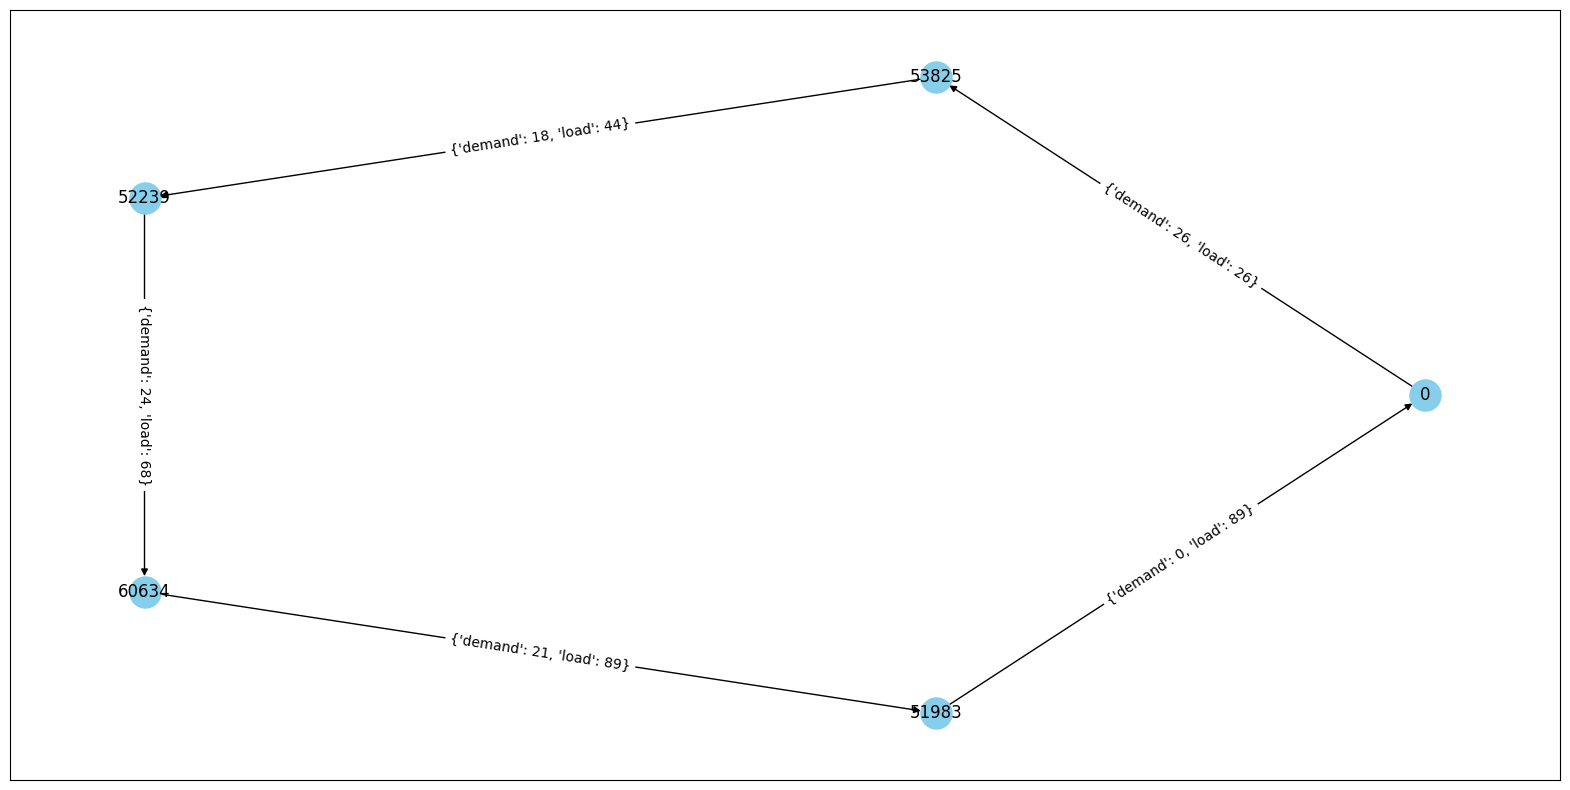



Bus 2:


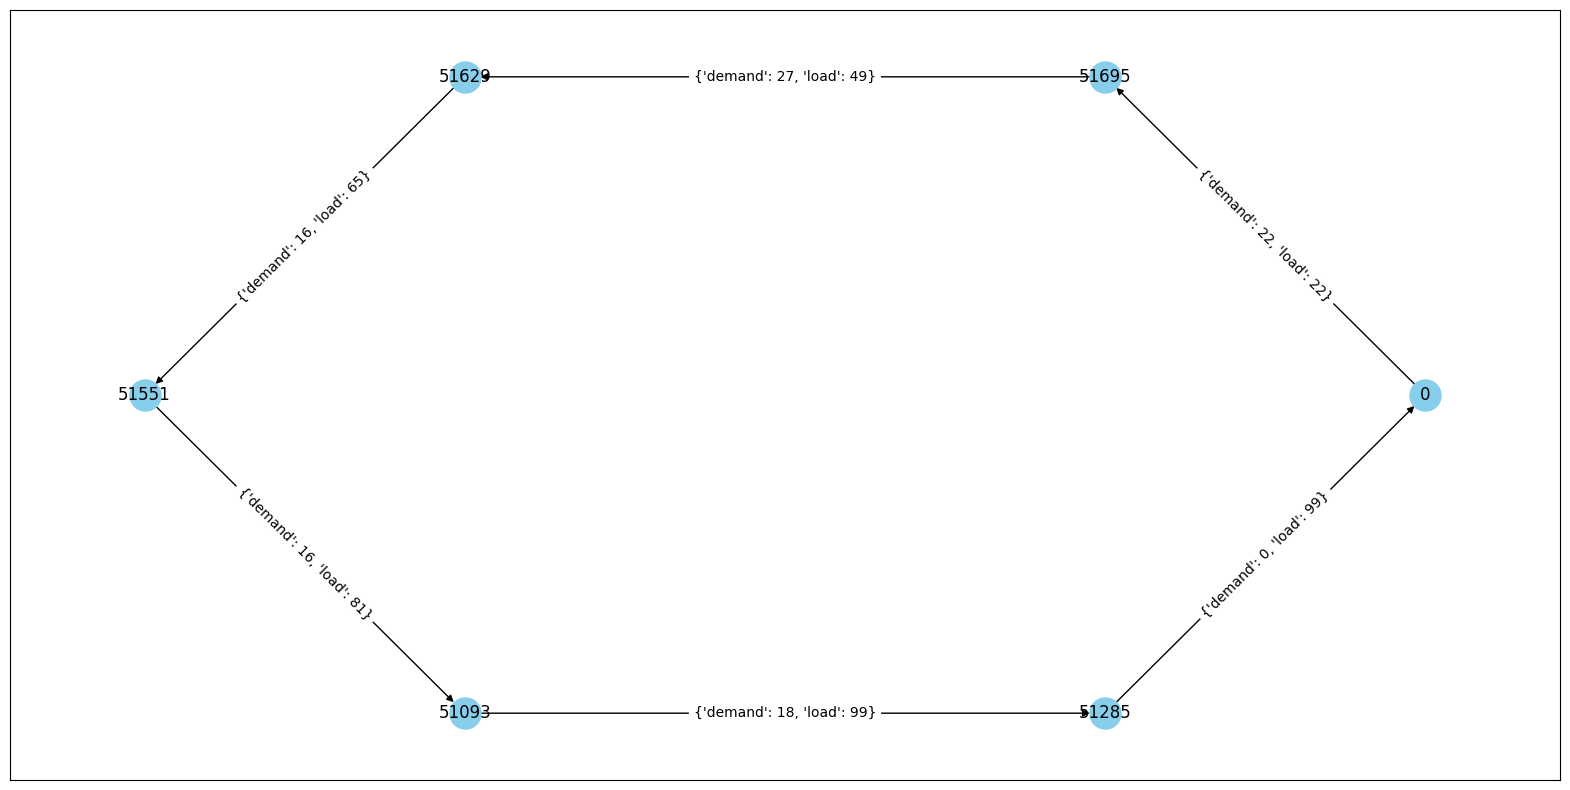



Bus 3:


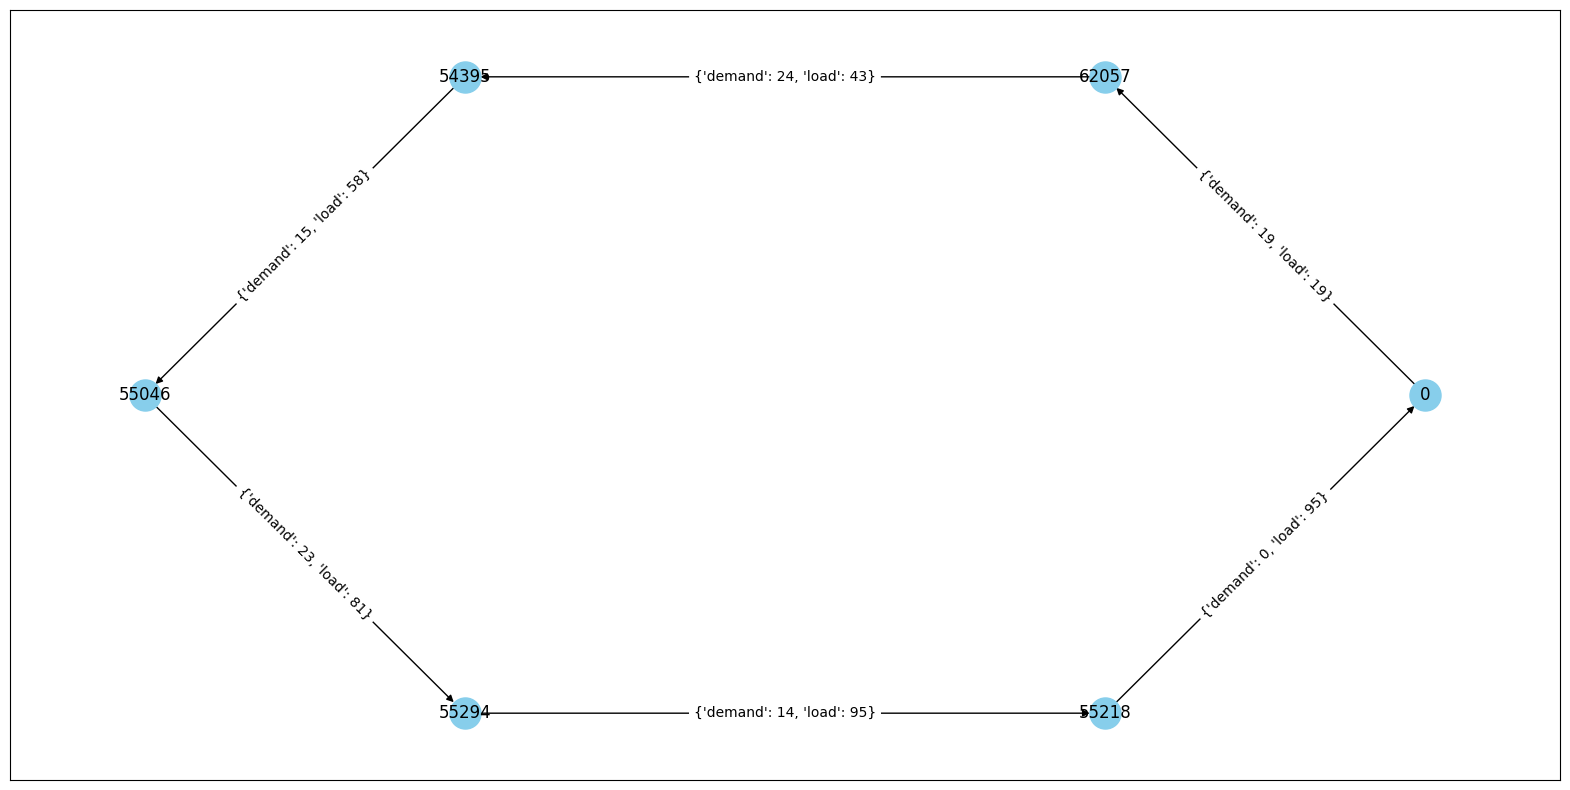



Bus 4:


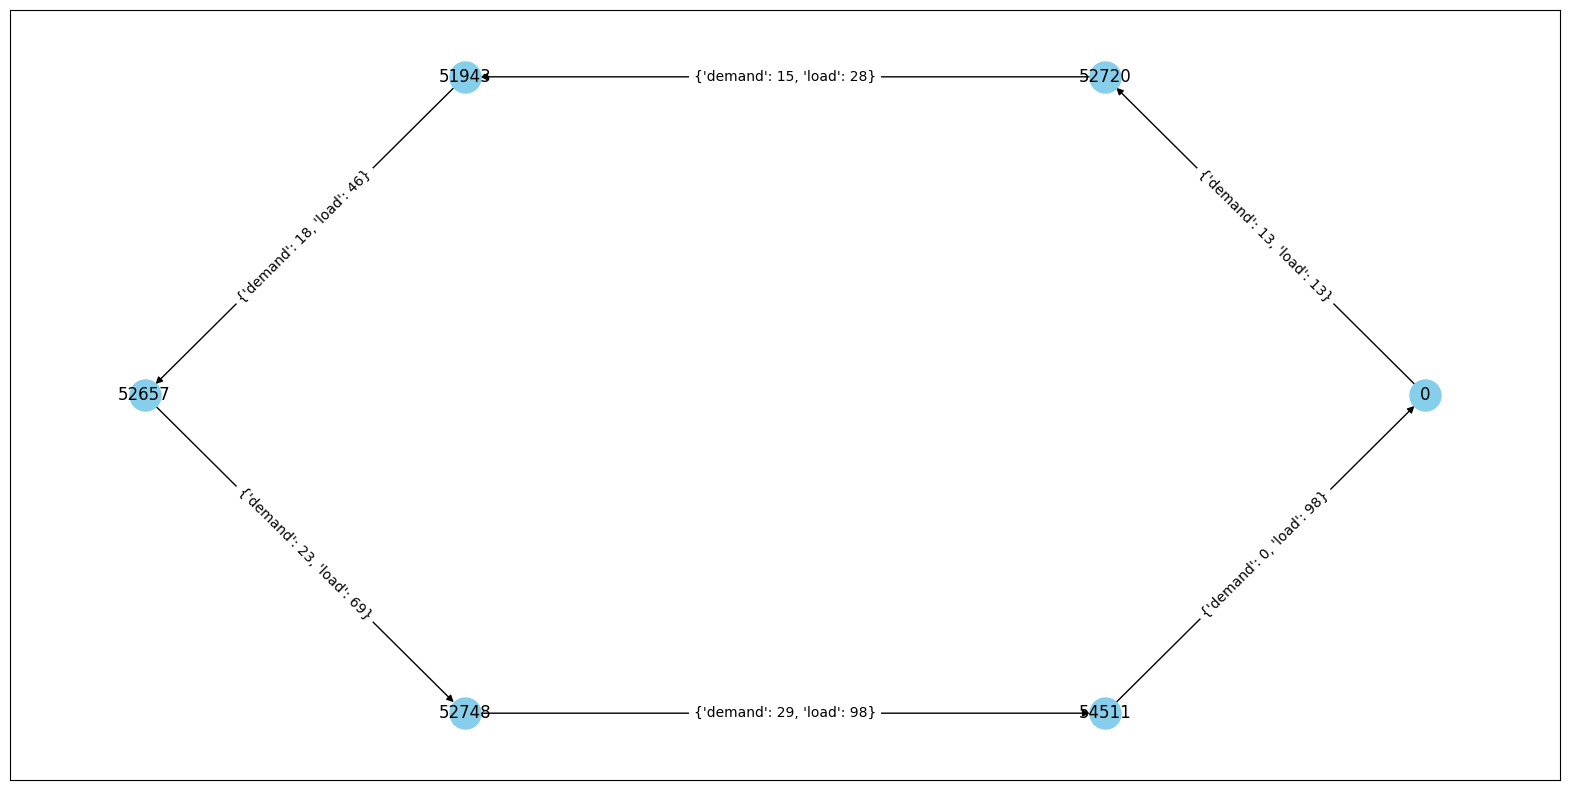



Bus 5:


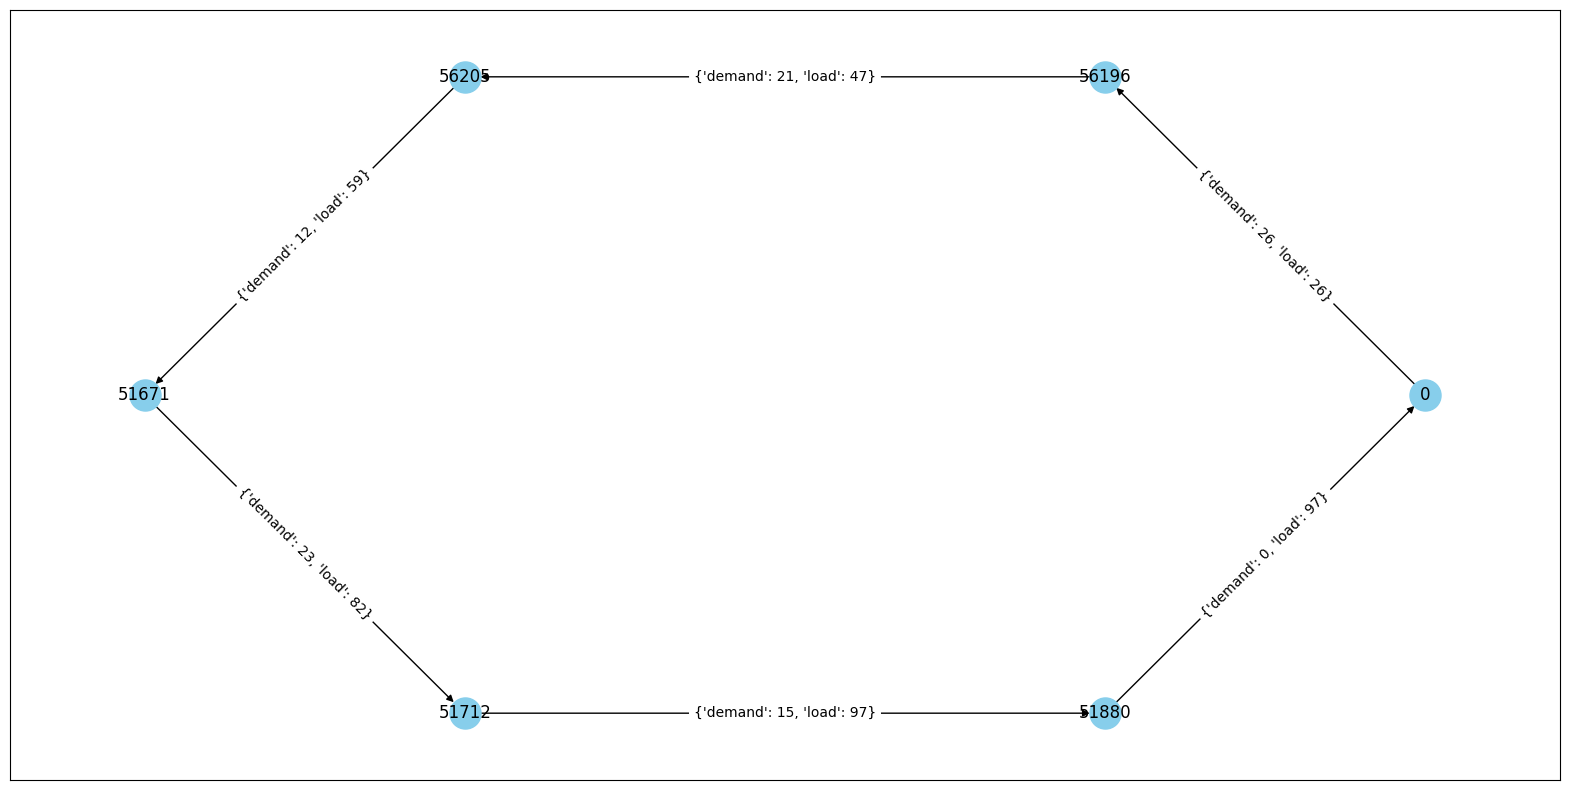



Bus 10:


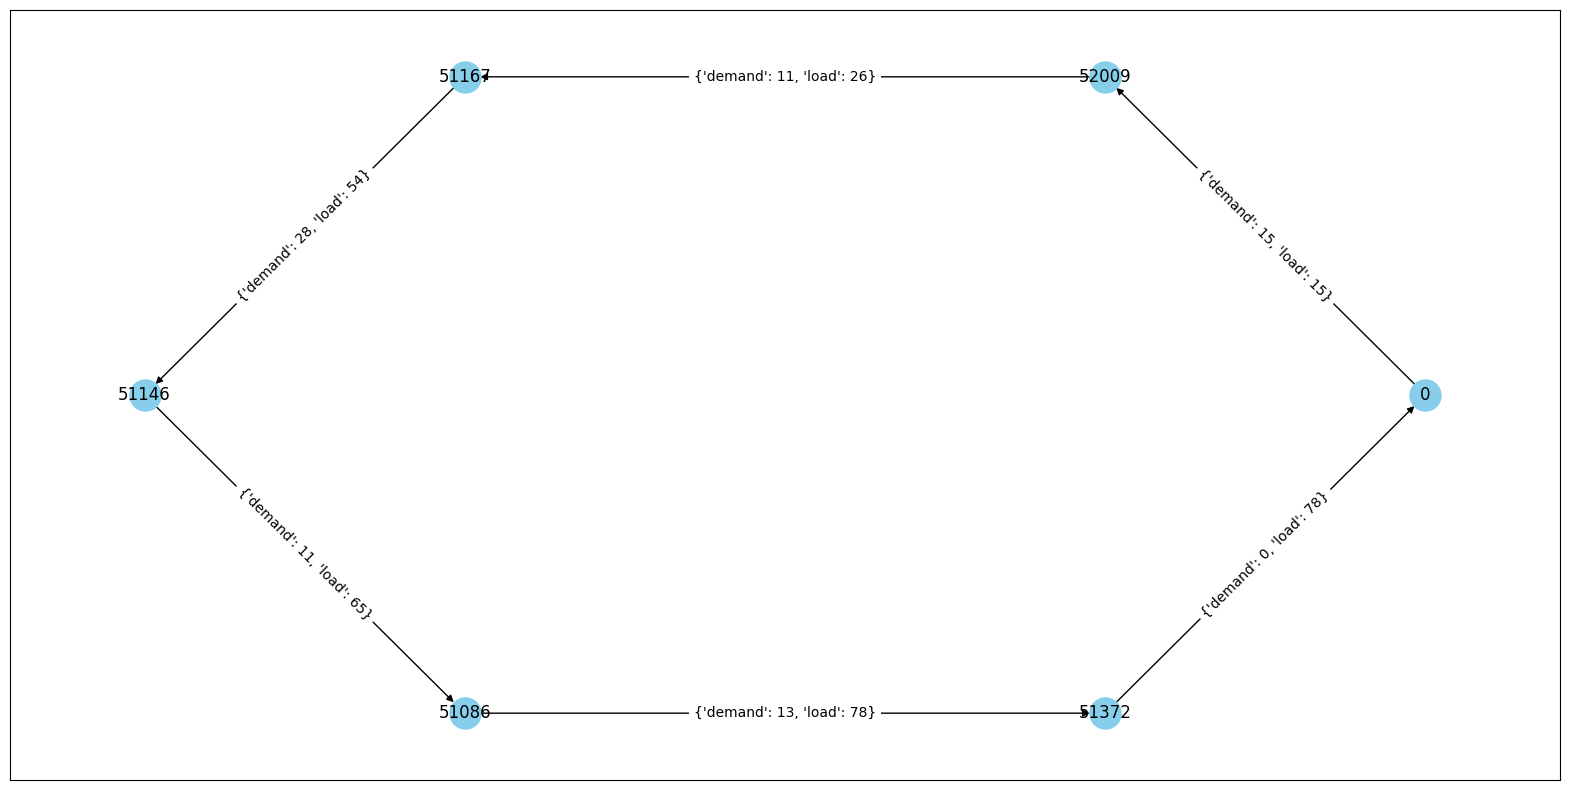

In [15]:
for bus in bus_path_df.bus.unique():
    print(f"Bus {bus + 1}:")

    bus_route = bus_path_df[bus_path_df["bus"] == bus].reset_index(drop=True)

    plt.figure(figsize=(20, 10))

    g = nx.DiGraph()

    for segment in bus_route.itertuples():
        g.add_edge(
            segment.start_stop,
            segment.end_stop,
            weight=segment.distance,
            demands={"demand": segment.demand, "load": segment.step_demand},
            step=segment.step,
            label=f"{segment.start_stop}-{segment.end_stop}",
            load=segment.step_demand,
        )

    pos = nx.circular_layout(g)

    nx.draw_networkx(g, pos, with_labels=True, node_size=500, node_color="skyblue")
    nx.draw_networkx_edge_labels(
        g, pos, edge_labels=nx.get_edge_attributes(g, "demands")
    )

    plt.show()

    print("\n")

In [16]:
routes_gdf = (
    gpd.GeoDataFrame(bus_path_df.groupby("bus")["geometry"].apply(list))
    .rename(columns={"points": "geometry"})
    .reset_index()
)

# add depot to each geometry
routes_gdf["points"] = routes_gdf.apply(
    lambda x: [Point((float(depot.stop_lon), float(depot.stop_lat)))] + x.geometry,
    axis=1,
)

routes_gdf["geometry"] = routes_gdf["points"].apply(LineString)
routes_gdf.drop(columns=["points"], inplace=True)

routes_gdf = routes_gdf.merge(
    bus_path_df.groupby("bus")["demand"].sum().rename("demand").reset_index(),
    on="bus",
)

routes_gdf = gpd.GeoDataFrame(routes_gdf, geometry="geometry")
routes_gdf.crs = "EPSG:4326"

routes_gdf

,bus,geometry,demand
0,0,"LINESTRING (-73.56912 45.50485, -73.56170 45.5...",89
1,1,"LINESTRING (-73.56912 45.50485, -73.59558 45.5...",99
2,2,"LINESTRING (-73.56912 45.50485, -73.62357 45.5...",95
3,3,"LINESTRING (-73.56912 45.50485, -73.56303 45.5...",98
4,4,"LINESTRING (-73.56912 45.50485, -73.61093 45.5...",97
5,9,"LINESTRING (-73.56912 45.50485, -73.58581 45.4...",78


### Map the routes

In [17]:
colormap = cm.get_cmap("tab10")

route_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(route_map)

for stop in bus_path_df.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="#3186cc",
        fill=True,
        fill_opacity=1,
        fill_color="#3186cc",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        <br>
        Route: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['bus'].values[0] + 1}
        <br>
        Step: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step'].values[0] + 1}
        <br>
        Demand: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['demand'].values[0]}
        <br>
        Load: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step_demand'].values[0]}
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)

for stop in stops_in_disaster_area.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="#3186cc",
        fill=True,
        fill_opacity=1,
        fill_color="#3186cc",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)


for route in routes_gdf.itertuples():
    route_layer = folium.FeatureGroup(name=f"Route {route.Index + 1}")

    folium.PolyLine(
        locations=[(p[1], p[0]) for p in route.geometry.coords],
        color=mcolors.rgb2hex(colormap.colors[route.Index]),
        weight=3,
        opacity=0.8,
        tooltip=f"Route {route.Index + 1}",
        popup=f"""
        <div>
            <h5>Route {route.Index + 1}</h5>
            <h5>Total demand: {route.demand}</h5>
        </div>
        """,
    ).add_to(route_layer)

    route_layer.add_to(route_map)

folium.plugins.Fullscreen(position="topright").add_to(route_map)
folium.plugins.MousePosition(position="topright").add_to(route_map)
folium.LayerControl().add_to(route_map)

route_map

## Split delivery vehicle routing problem - geometric split

### Parameters

In [18]:
rng = np.random.default_rng(5)

distance_matrix_model = distance_matrix.drop(
    columns=stops_in_disaster_area.stop_id, index=stops_in_disaster_area.stop_id
)

stops = list(distance_matrix_model.columns)
num_stops = len(stops)

distance_matrix_model = distance_matrix_model.loc[stops, stops]

demand = {stop: rng.integers(0, 100) for stop in stops}
demand[stops[0]] = 0


num_buses = 10
BUS_CAPACITY = 75

print(f"Total demand: {sum(demand.values())}")
print(f"Total capacity: {num_buses * BUS_CAPACITY}")

Total demand: 631
Total capacity: 750


### Split demand nodes

$$
\begin{align*}
D_{ix} &= \frac{2^{x-1}}{\sum_{i=1}^{S} 2^{x-1}} D_{i}
\end{align*}
$$

$D_{ix}$ is rounded down to the nearest integer. If $\sum_{i=1}^{S} D_{ix} < D_{i}$, then $D_{iS} = D_{iS} + D_{i} - \sum_{i=1}^{S} D_{ix}$.

In [19]:
# Split the node demand into smaller demands according to a geometric progression

S = 100
fraction = [2 ** (i - 1) for i in range(1, S + 1)]
fraction_sum = sum(fraction)


def split_demand(node_demand):
    demands = [np.floor(node_demand * (f / fraction_sum)) for f in fraction]
    demands = list(filter(lambda x: x > 0, demands))

    if sum(demands) < node_demand:
        demands[-1] += node_demand - sum(demands)

    i = len(demands) - 1

    while demands[i] >= BUS_CAPACITY * 1:
        new_demand = split_demand(demands[i])
        demands.pop(i)
        demands.extend(new_demand)
        i -= 1

    return demands


def split_demand_node(demand, node):
    node_demand = demand[node]
    demands = split_demand(node_demand)

    return {f"{node}_{i}": d for i, d in enumerate(demands, 1)}

In [20]:
nodes_exceeding_demand = {}
new_demand = demand.copy()
for k, v in demand.items():
    if v > BUS_CAPACITY:
        new_nodes = split_demand_node(demand, k)

        new_demand.pop(k)
        new_demand.update(new_nodes)

        nodes_exceeding_demand[k] = new_nodes

print(f"New nodes added for: {list(nodes_exceeding_demand.keys())}")

# Update distance matrix to include split nodes. Distance between split nodes of same parent node is 0
for node in nodes_exceeding_demand:
    for i in range(1, len([k for k in new_demand.keys() if node in k]) + 1):
        distance_matrix_model[f"{node}_{i}"] = distance_matrix_model[node]
        distance_matrix_model.loc[f"{node}_{i}"] = distance_matrix_model.loc[node]
        distance_matrix_model.loc[f"{node}_{i}", node] = 0
    distance_matrix_model.drop(columns=[node], index=[node], inplace=True)


distance_matrix_model

New nodes added for: ['52277', '51951', '51819']


,0,52129,51032,56286,53353,54626,51167,52335,52022,56188,...,51951_3,51951_4,51951_5,51951_6,51819_1,51819_2,51819_3,51819_4,51819_5,51819_6
0,0.000000,8.086734,6.222221,2.627378,10.103120,11.594164,4.975713,0.607893,4.861341,4.262466,...,2.383095,2.383095,2.383095,2.383095,5.554667,5.554667,5.554667,5.554667,5.554667,5.554667
52129,8.086734,0.000000,10.999515,10.077727,6.491115,4.264269,8.737010,8.058242,3.658592,6.976608,...,9.833444,9.833444,9.833444,9.833444,3.008662,3.008662,3.008662,3.008662,3.008662,3.008662
51032,6.222221,10.999515,0.000000,4.374956,15.488320,15.295792,2.090399,5.379148,7.869475,3.977775,...,5.004114,5.004114,5.004114,5.004114,8.142425,8.142425,8.142425,8.142425,8.142425,8.142425
56286,2.627378,10.077727,4.374956,0.000000,12.145914,13.636958,3.730018,2.036742,6.756528,5.617394,...,0.342071,0.342071,0.342071,0.342071,7.325526,7.325526,7.325526,7.325526,7.325526,7.325526
53353,10.103120,6.491115,15.488320,12.145914,0.000000,4.391695,15.929762,12.405187,10.703989,14.328314,...,11.883060,11.883060,11.883060,11.883060,10.843957,10.843957,10.843957,10.843957,10.843957,10.843957
54626,11.594164,4.264269,15.295792,13.636958,4.391695,0.000000,13.044150,11.634556,7.896478,11.283748,...,13.374104,13.374104,13.374104,13.374104,7.315802,7.315802,7.315802,7.315802,7.315802,7.315802
51167,4.975713,8.737010,2.090399,3.730018,15.929762,13.044150,0.000000,4.413204,5.779076,1.887376,...,3.757606,3.757606,3.757606,3.757606,6.064912,6.064912,6.064912,6.064912,6.064912,6.064912
52335,0.607893,8.058242,5.379148,2.036742,12.405187,11.634556,4.413204,0.000000,4.867393,4.262720,...,1.773888,1.773888,1.773888,1.773888,5.405110,5.405110,5.405110,5.405110,5.405110,5.405110
52022,4.861341,3.658592,7.869475,6.756528,10.703989,7.896478,5.779076,4.867393,0.000000,4.366552,...,6.641281,6.641281,6.641281,6.641281,0.693384,0.693384,0.693384,0.693384,0.693384,0.693384
56188,4.262466,6.976608,3.977775,5.617394,14.328314,11.283748,1.887376,4.262720,4.366552,0.000000,...,5.644982,5.644982,5.644982,5.644982,4.283844,4.283844,4.283844,4.283844,4.283844,4.283844


In [21]:
for k, v in new_demand.items():
    assert v <= BUS_CAPACITY

assert sum(new_demand.values()) == sum(demand.values())

In [22]:
new_stops = list(distance_matrix_model.columns)
num_new_stops = len(new_stops)

print(f"Total number of stops (overall): {num_stops}")
print(f"Total number of stops (including splits): {num_new_stops}")

Total number of stops (overall): 17
Total number of stops (including splits): 32


### Model

In [23]:
# ----------------------------------------------------------------------------------------------
# Model

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.2
model.Params.TimeLimit = 60 * 2
model.Params.MIPFocus = 1


# ----------------------------------------------------------------------------------------------
# Decision Variables

x = model.addVars(
    new_stops,
    new_stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (bus {k})" for i in new_stops for j in new_stops for k in range(num_buses)
    ),
)

u = model.addVars(
    new_stops,
    vtype=gb.GRB.INTEGER,
    name=(f"Load at Stop {i}" for i in new_stops),
)

# ----------------------------------------------------------------------------------------------
# Objective Function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in new_stops
        for j in new_stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# ----------------------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in new_stops) == gb.quicksum(x[i, j, k] for j in new_stops)
        for i in new_stops
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in new_stops for k in range(num_buses)) == 1
        for j in new_stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[new_stops[0], j, k] for j in new_stops[1:]) <= 1 for k in range(num_buses)),
    name="Every vehicle may leave the depot if needed",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(new_demand[j] * x[i, j, k] for j in new_stops[1:] for i in new_stops)
        <= BUS_CAPACITY
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# No travel between same node
model.addConstrs(
    (x[i, i, k] == 0 for i in new_stops for k in range(num_buses)),
    name="No same node",
)

# Subtour elimination constraints
model.addConstrs(
    (
        u[j] - u[i] >= new_demand[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in new_stops[1:]
        for j in new_stops[1:]
        for k in range(num_buses)
        if i != j
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= new_demand[i] for i in new_stops[1:]),
    name="Lower bound for u",
)

model.addConstrs(
    (u[i] <= BUS_CAPACITY for i in new_stops[1:]),
    name="Upper bound for u",
)

# Distance between two travel nodes is less than specified distance
model.addConstrs(
    (
        distance_matrix_model.loc[i, j] * x[i, j, k] <= 5
        for i in new_stops[1:]
        for j in new_stops[1:]
        for k in range(num_buses)
    ),
    name="Distance between two travel nodes is less than a specified distance",
)

# ----------------------------------------------------------------------------------------------
# Solve model
model.update()
model.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-30
Set parameter MIPGap to value 0.2
Set parameter TimeLimit to value 120
Set parameter MIPFocus to value 1


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 19663 rows, 10272 columns and 76352 nonzeros
Model fingerprint: 0xeba3752b
Variable types: 0 continuous, 10272 integer (10240 binary)
Coefficient statistics:
  Matrix range     [3e-01, 8e+01]
  Objective range  [3e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Presolve removed 15382 rows and 5712 columns
Presolve time: 0.15s
Presolved: 4281 rows, 4560 columns, 29530 nonzeros
Variable types: 0 continuous, 4560 integer (4530 binary)

Root relaxation: objective 4.070294e+01, 490 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   40.70294    0   85          -   

### Optimal solution routes

In [24]:
print(f"Objective value: {model.objVal:.2f} km")

# Distance by bus
distance_bus = pd.DataFrame(
    {
        "bus": k,
        "distance": sum(
            distance_matrix_model.loc[i, j] * x[i, j, k].x
            for i in new_stops
            for j in new_stops
        ),
    }
    for k in range(num_buses)
)

distance_bus = distance_bus[distance_bus["distance"] > 0].reset_index(drop=True)

display(distance_bus)

# Bus paths
bus_path = {}

for k in range(num_buses):
    bus_path[k] = []
    for i in new_stops:
        for j in new_stops:
            if x[i, j, k].x == 1:
                bus_path[k].append(
                    {
                        "start_stop": i,
                        "end_stop": j,
                        "distance": distance_matrix_model.loc[i, j],
                    }
                )

# Convert to dataframe with bus route number
bus_path_df = []

for k, v in bus_path.items():
    bus_path_df.append(pd.DataFrame(v).assign(bus=k))

bus_path_df = pd.concat(bus_path_df)

paths = {}

grouped = bus_path_df.groupby("bus")

# Iterate over each bus group
for bus, group in grouped:
    sorted_group = group.sort_values(by=["start_stop", "end_stop"]).reset_index(
        drop=True
    )
    path = ["0"]  # Initialize the path with the depot

    # Start with the first stop after the depot
    current_stop = sorted_group.loc[
        sorted_group["start_stop"] == "0", "end_stop"
    ].values[0]
    path.append(current_stop)

    # Follow the chain of stops
    while True:
        # Find the next stop where the current stop is the start stop
        next_stop = sorted_group.loc[
            sorted_group["start_stop"] == current_stop, "end_stop"
        ].values
        if not next_stop:
            break  # If there is no next stop, we've completed the path
        next_stop = next_stop[0]

        # Add the next stop to the path and set it as the current stop
        if next_stop == "0":
            break  # If the next stop is the depot, we've completed the path
        path.append(next_stop)
        current_stop = next_stop

    # Store the path for this bus
    paths[bus] = path

bus_path_df["step"] = bus_path_df.apply(
    lambda x: paths[x.bus].index(x.start_stop), axis=1
)

bus_path_df.sort_values(by=["bus", "step"], inplace=True)

bus_path_df["demand"] = bus_path_df["end_stop"].map(new_demand)

bus_path_df[["start_stop", "end_stop"]] = bus_path_df[
    ["start_stop", "end_stop"]
].applymap(lambda x: x.split("_")[0])


bus_path_df = bus_path_df.merge(
    random_stops_df_gpd[["stop_id", "stop_name", "geometry"]],
    left_on="end_stop",
    right_on="stop_id",
    how="left",
)


bus_path_df["step_demand"] = bus_path_df.groupby("bus")["demand"].cumsum()

num_buses_used = bus_path_df.bus.nunique()
print(f"Number of buses used: {num_buses_used}")

display(bus_path_df)

# Print routes
for route in paths:
    print(f"Route {route +  1}: {' -> '.join(paths[route])} -> 0")

Objective value: 104.70 km


,bus,distance
0,0,20.206240
1,2,8.799594
2,3,13.699427
3,4,14.663516
4,5,24.378366
5,6,4.766190
6,7,5.352544
7,8,11.109334
8,9,1.722974


Number of buses used: 9


,start_stop,end_stop,distance,bus,step,demand,stop_id,stop_name,geometry,step_demand
0,0,53353,10.103120,0,0,63.0,53353,Haig / No 2105,POINT (-73.52561 45.58091),63.0
1,53353,0,10.103120,0,1,0.0,0,Depot,POINT (-73.56912 45.50485),63.0
2,0,56188,4.262466,2,0,57.0,56188,Côte-Sainte-Catherine / Dunlop,POINT (-73.61375 45.51257),57.0
3,56188,52459,3.846343,2,1,13.0,52459,Sherbrooke / Jeanne-Mance,POINT (-73.57076 45.50917),70.0
4,52459,0,0.690785,2,2,0.0,0,Depot,POINT (-73.56912 45.50485),70.0
5,0,50986,6.307561,3,0,0.0,50986,Queen-Mary / Earnscliffe,POINT (-73.63058 45.48183),0.0
6,50986,51032,0.325754,3,1,46.0,51032,Queen-Mary / Trans Island,POINT (-73.62863 45.48405),46.0
7,51032,51167,2.090399,3,2,5.0,51167,Decelles / Édouard-Montpetit,POINT (-73.62216 45.49916),51.0
8,51167,52277,4.114226,3,3,20.0,52277,Sherbrooke / Peel,POINT (-73.57663 45.50163),71.0
9,52277,0,0.861487,3,4,0.0,0,Depot,POINT (-73.56912 45.50485),71.0


Route 1: 0 -> 53353 -> 0
Route 3: 0 -> 56188 -> 52459 -> 0
Route 4: 0 -> 50986 -> 51032 -> 51167 -> 52277_5 -> 0
Route 5: 0 -> 51576 -> 51093 -> 51819_5 -> 0
Route 6: 0 -> 52022 -> 52129 -> 54626 -> 0
Route 7: 0 -> 51951_5 -> 51951_6 -> 51951_2 -> 52277_4 -> 0
Route 8: 0 -> 52277_2 -> 56286 -> 51951_1 -> 51951_3 -> 51951_4 -> 52277_3 -> 0
Route 9: 0 -> 51819_3 -> 51819_2 -> 51819_4 -> 51819_1 -> 51819_6 -> 0
Route 10: 0 -> 52277_1 -> 52277_6 -> 52335 -> 0


Bus 1:


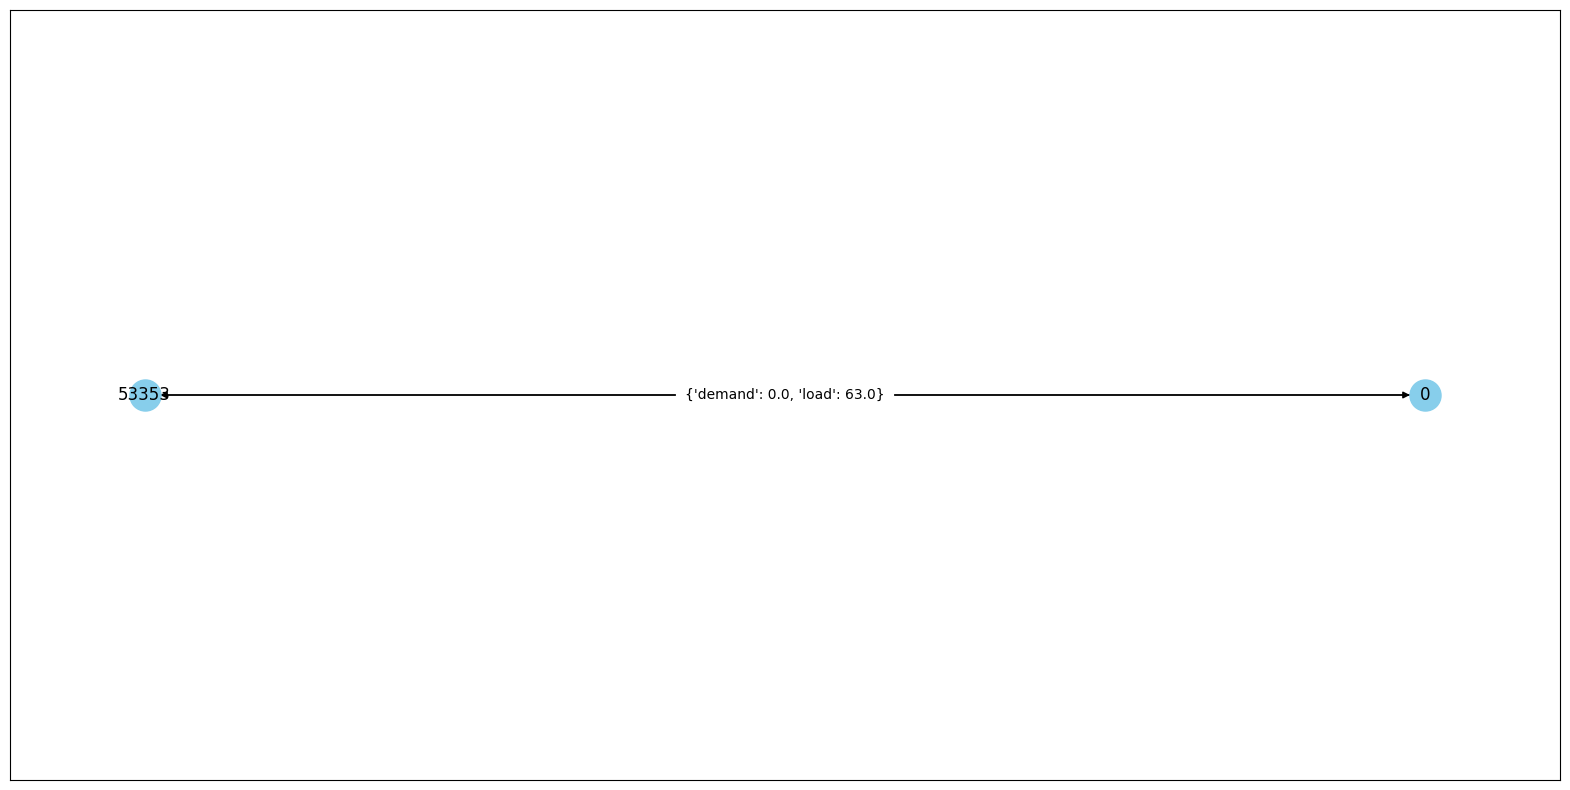



Bus 3:


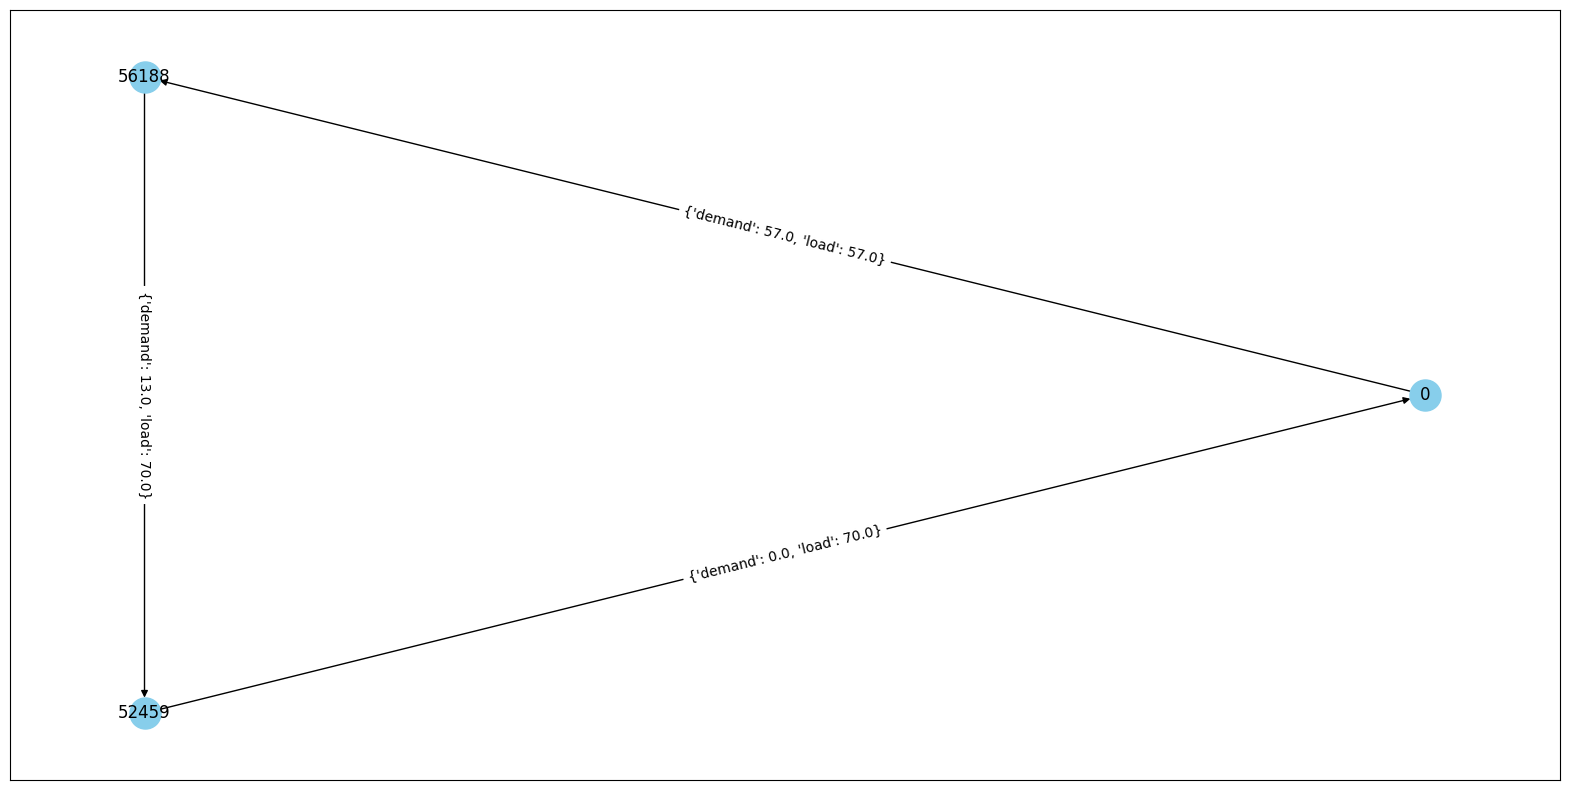



Bus 4:


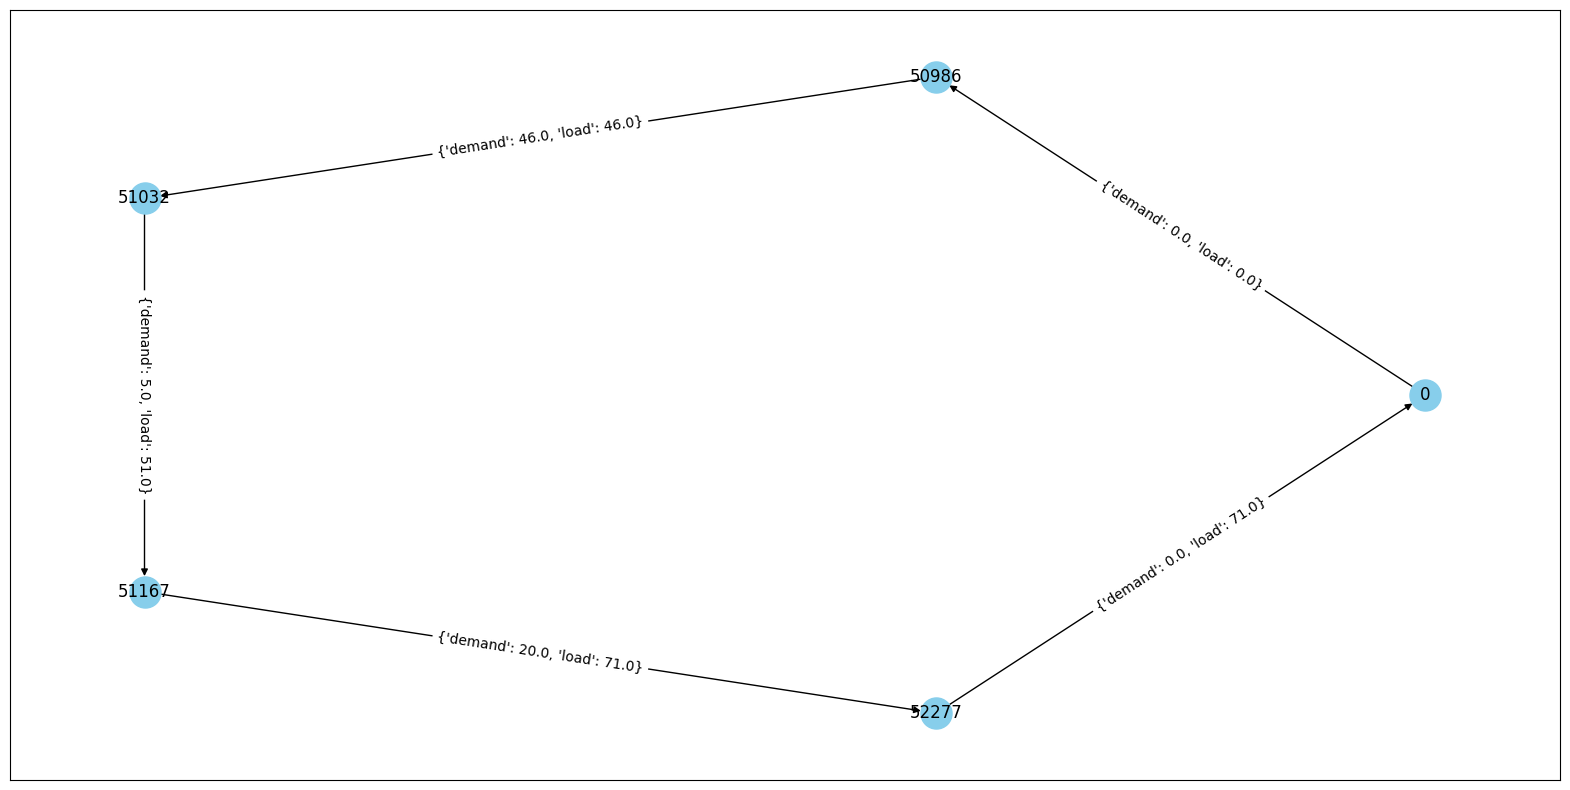



Bus 5:


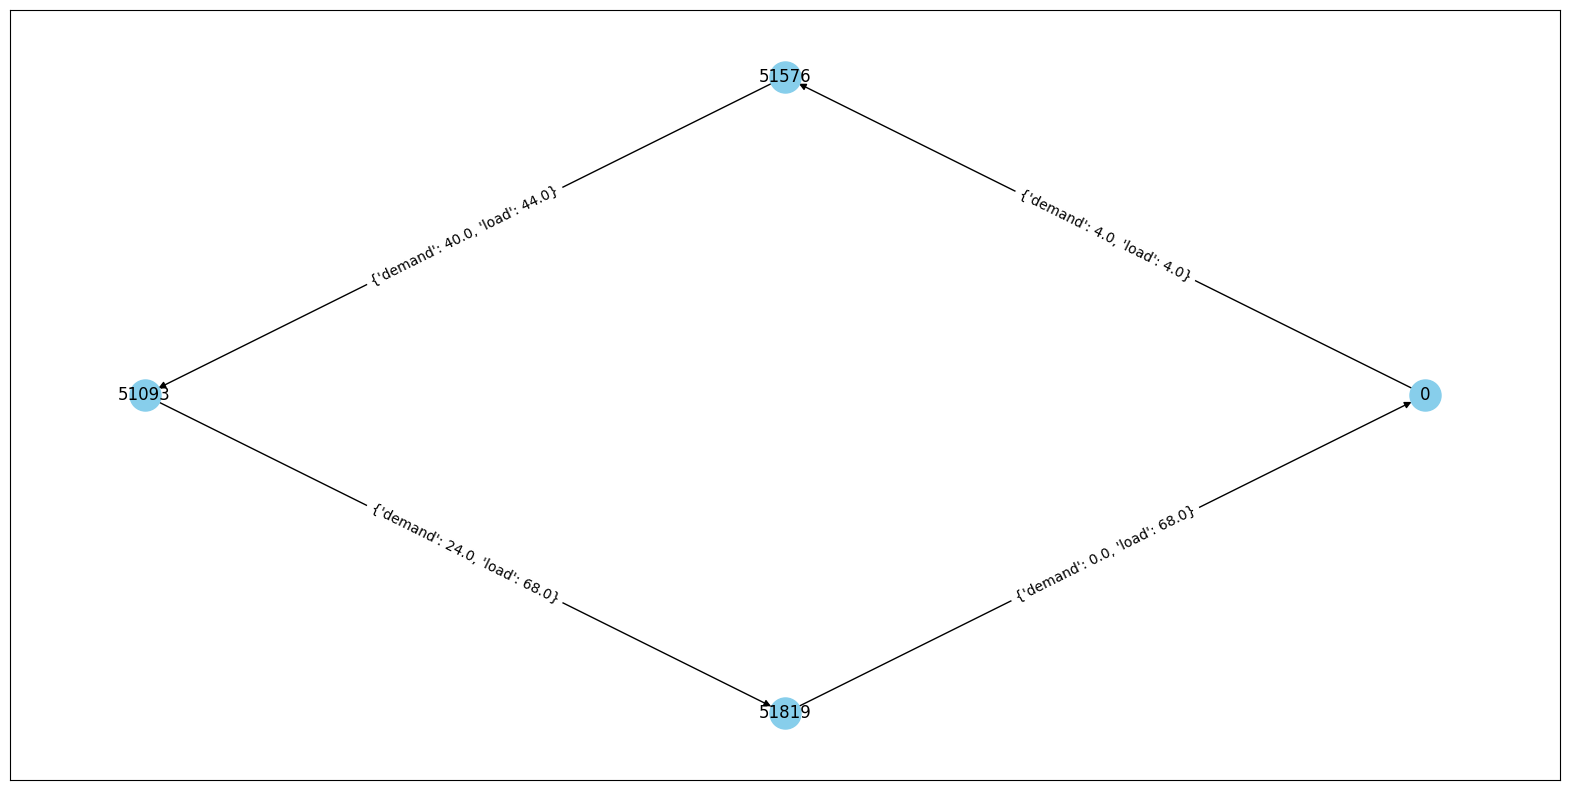



Bus 6:


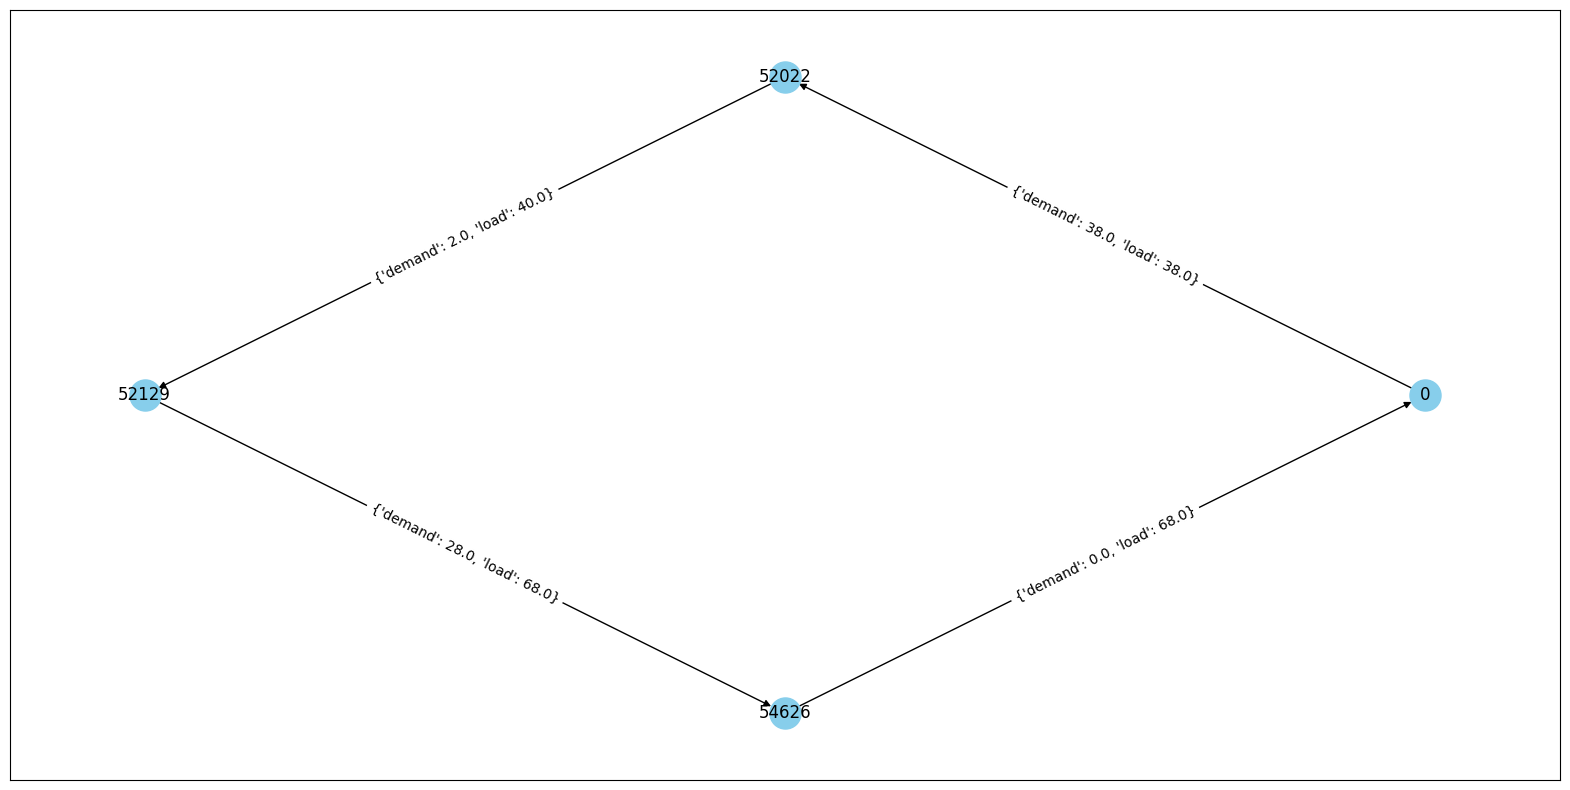



Bus 7:


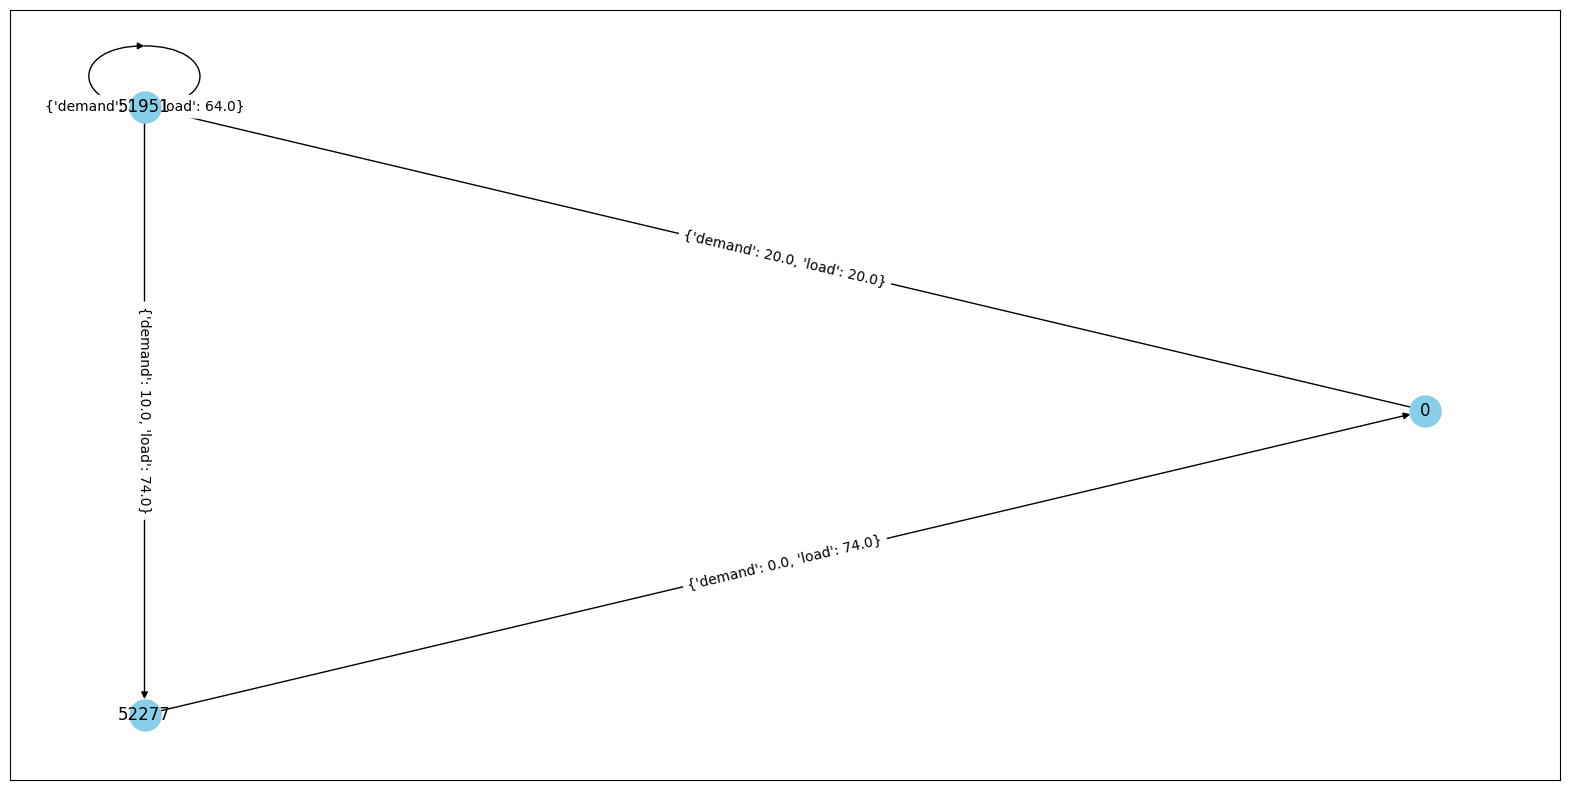



Bus 8:


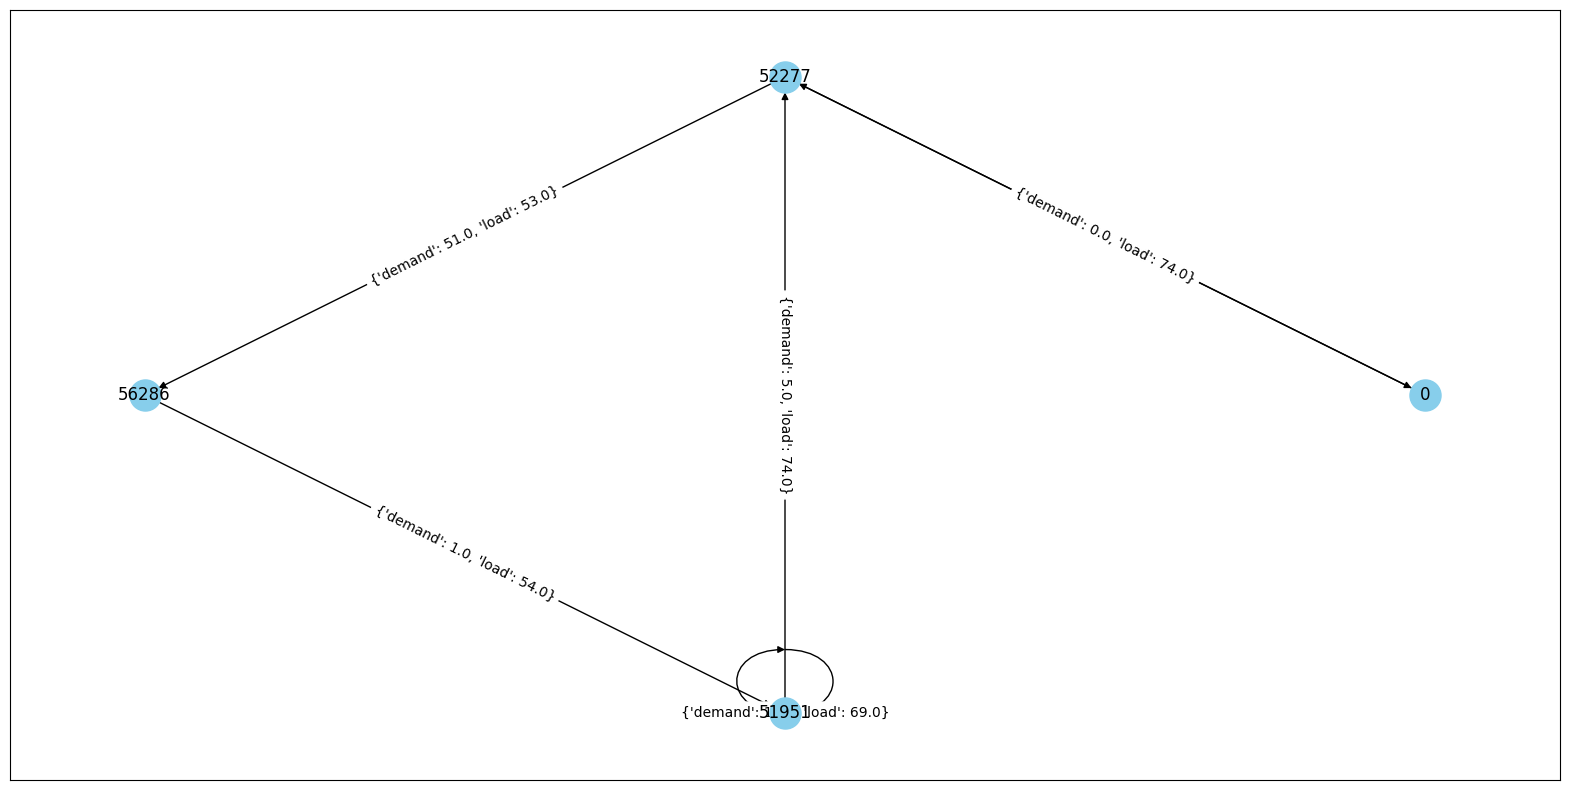



Bus 9:


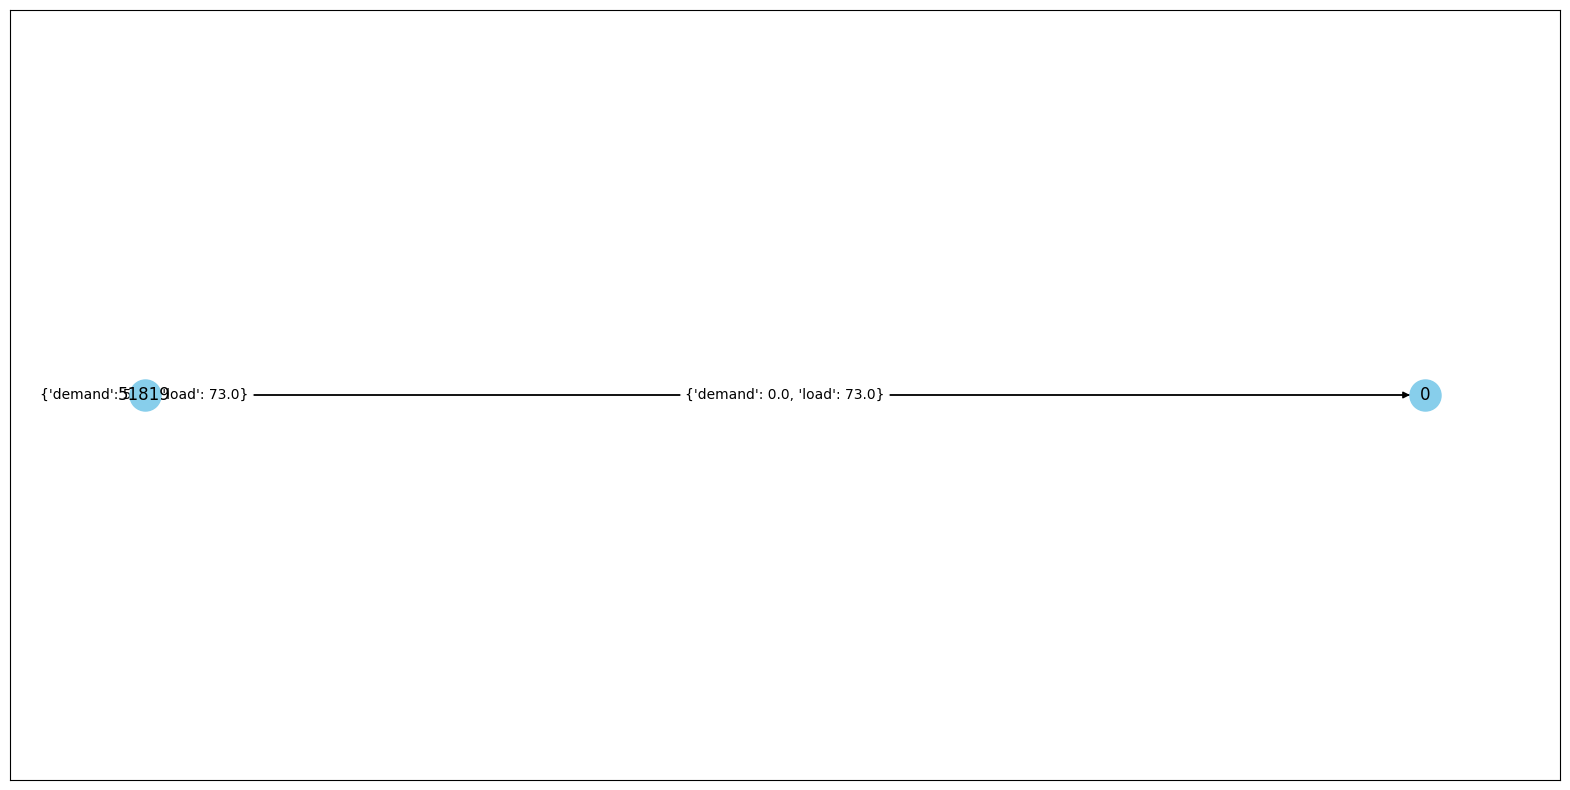



Bus 10:


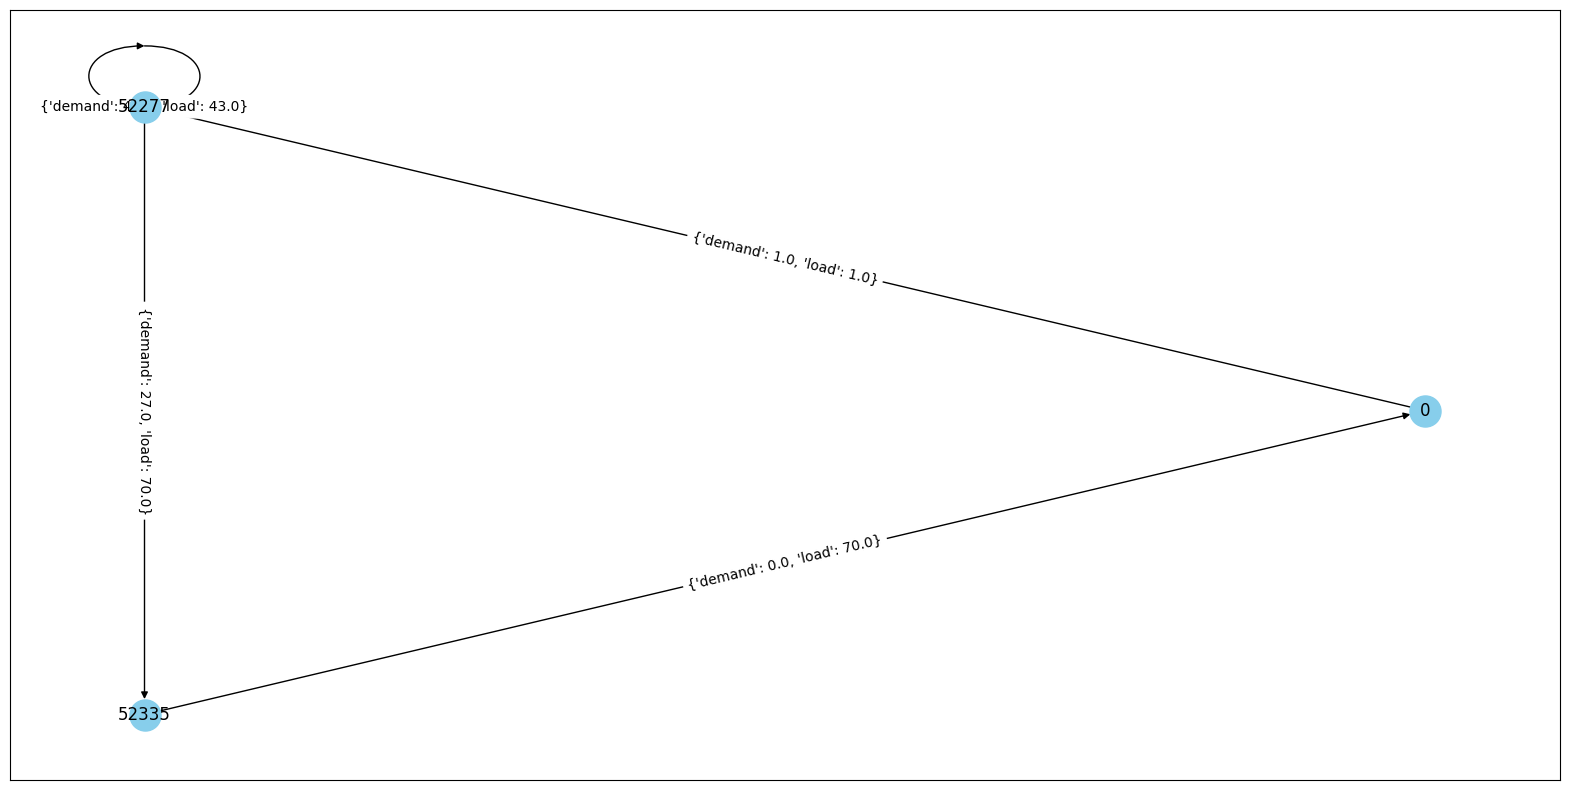

In [25]:
for bus in bus_path_df.bus.unique():
    print(f"Bus {bus + 1}:")

    bus_route = bus_path_df[bus_path_df["bus"] == bus].reset_index(drop=True)

    plt.figure(figsize=(20, 10))

    g = nx.DiGraph()

    for segment in bus_route.itertuples():
        g.add_edge(
            segment.start_stop,
            segment.end_stop,
            weight=segment.distance,
            demands={"demand": segment.demand, "load": segment.step_demand},
            step=segment.step,
            label=f"{segment.start_stop}-{segment.end_stop}",
            load=segment.step_demand,
        )

    pos = nx.circular_layout(g)

    nx.draw_networkx(g, pos, with_labels=True, node_size=500, node_color="skyblue")
    nx.draw_networkx_edge_labels(
        g, pos, edge_labels=nx.get_edge_attributes(g, "demands")
    )

    plt.show()

    print("\n")

In [26]:
routes_gdf = (
    gpd.GeoDataFrame(bus_path_df.groupby("bus")["geometry"].apply(list))
    .rename(columns={"points": "geometry"})
    .reset_index()
)

# add depot to each geometry
routes_gdf["points"] = routes_gdf.apply(
    lambda x: [Point((float(depot.stop_lon), float(depot.stop_lat)))] + x.geometry,
    axis=1,
)

routes_gdf["geometry"] = routes_gdf["points"].apply(LineString)
routes_gdf.drop(columns=["points"], inplace=True)

routes_gdf = routes_gdf.merge(
    bus_path_df.groupby("bus")["demand"].sum().rename("demand").reset_index(),
    on="bus",
)

routes_gdf = gpd.GeoDataFrame(routes_gdf, geometry="geometry")
routes_gdf.crs = "EPSG:4326"

display(routes_gdf)

,bus,geometry,demand
0,0,"LINESTRING (-73.56912 45.50485, -73.52561 45.5...",63.0
1,2,"LINESTRING (-73.56912 45.50485, -73.61375 45.5...",70.0
2,3,"LINESTRING (-73.56912 45.50485, -73.63058 45.4...",71.0
3,4,"LINESTRING (-73.56912 45.50485, -73.60201 45.5...",68.0
4,5,"LINESTRING (-73.56912 45.50485, -73.58373 45.5...",68.0
5,6,"LINESTRING (-73.56912 45.50485, -73.58804 45.4...",74.0
6,7,"LINESTRING (-73.56912 45.50485, -73.57663 45.5...",74.0
7,8,"LINESTRING (-73.56912 45.50485, -73.59108 45.5...",73.0
8,9,"LINESTRING (-73.56912 45.50485, -73.57663 45.5...",70.0


### Map the routes

In [27]:
colormap_route = [
    mcolors.rgb2hex(c) for c in list(plt.cm.rainbow(np.linspace(0, 1, num_buses)))
]

route_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(route_map)

for stop in bus_path_df.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color=colormap_route[stop.bus] if stop.stop_id != "0" else "black",
        fill=True,
        fill_opacity=1,
        fill_color=colormap_route[stop.bus] if stop.stop_id != "0" else "black",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        <br>
        Route: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['bus'].values[0] + 1}
        <br>
        Step: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step'].values[0] + 1}
        <br>
        Demand: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['demand'].values[0]}
        <br>
        Load: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step_demand'].values[0]}
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)

for stop in stops_in_disaster_area.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="red",
        fill=True,
        fill_opacity=1,
        fill_color="red",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)


for route in routes_gdf.itertuples():
    route_layer = folium.FeatureGroup(f"Route {route.bus + 1}")
    folium.PolyLine(
        locations=[(p[1], p[0]) for p in route.geometry.coords],
        color=colormap_route[route.bus],
        weight=3,
        opacity=0.6,
        tooltip=f"Route {route.bus + 1}",
        popup=f"""
        <div>
            <h5>Route {route.bus + 1}</h5>
            <h5>Total demand: {route.demand}</h5>
        </div>
        """,
    ).add_to(route_layer)

    route_layer.add_to(route_map)

folium.plugins.Fullscreen(position="topright").add_to(route_map)
folium.plugins.MousePosition(position="topright").add_to(route_map)
folium.LayerControl().add_to(route_map)

route_map.save("route_map_geometric_split.html")
route_map

## Split delivery vehicle routing problem - split to capacity

### Parameters

In [29]:
rng = np.random.default_rng(5)

distance_matrix_model = distance_matrix.drop(
    columns=stops_in_disaster_area.stop_id, index=stops_in_disaster_area.stop_id
)

stops = list(distance_matrix_model.columns)
num_stops = len(stops)

distance_matrix_model = distance_matrix_model.loc[stops, stops]

demand = {stop: rng.integers(0, 100) for stop in stops}
demand[stops[0]] = 0


num_buses = 10
BUS_CAPACITY = 75

print(f"Total demand: {sum(demand.values())}")
print(f"Total capacity: {num_buses * BUS_CAPACITY}")

Total demand: 631
Total capacity: 750


### Split demand nodes

$$
\begin{align*}
D_{ix} &= Q &\quad \forall x \in \{1, \dots, S = \frac{q_{i}}{Q}\} \\
\end{align*}
$$

$D_{ix}$ is rounded down to the nearest integer. If $\sum_{i=1}^{S} D_{ix} < D_{i}$, then $D_{i(S+1)} = D_{i} - \sum_{i=1}^{S} D_{ix}$.


In [30]:
# Split the node demand into smaller demands according to BUS_CAPACITY


def split_to_capacity(node_demand):
    demands = [BUS_CAPACITY for _ in range(int(np.floor(node_demand / BUS_CAPACITY)))]
    demands.append(node_demand - sum(demands))

    return demands


def split_demand_node(demand, node):
    node_demand = demand[node]
    demands = split_to_capacity(node_demand)

    return {f"{node}_{i}": d for i, d in enumerate(demands, start=1)}

In [31]:
nodes_exceeding_demand = {}
new_demand = demand.copy()
for k, v in demand.items():
    if v > BUS_CAPACITY:
        new_nodes = split_demand_node(demand, k)

        new_demand.pop(k)
        new_demand.update(new_nodes)

        nodes_exceeding_demand[k] = new_nodes

print(f"New nodes added for: {list(nodes_exceeding_demand.keys())}")

# Update distance matrix to include split nodes. Distance between split nodes of same parent node is 0
for node in nodes_exceeding_demand:
    for i in range(1, len([k for k in new_demand.keys() if node in k]) + 1):
        distance_matrix_model[f"{node}_{i}"] = distance_matrix_model[node]
        distance_matrix_model.loc[f"{node}_{i}"] = distance_matrix_model.loc[node]
        distance_matrix_model.loc[f"{node}_{i}", node] = 0
    distance_matrix_model.drop(columns=[node], index=[node], inplace=True)


distance_matrix_model

New nodes added for: ['52277', '51951', '51819']


,0,52129,51032,56286,53353,54626,51167,52335,52022,56188,51093,52459,51576,50986,52277_1,52277_2,51951_1,51951_2,51819_1,51819_2
0,0.000000,8.086734,6.222221,2.627378,10.103120,11.594164,4.975713,0.607893,4.861341,4.262466,5.428028,0.690785,3.389347,6.307561,0.861487,0.861487,2.383095,2.383095,5.554667,5.554667
52129,8.086734,0.000000,10.999515,10.077727,6.491115,4.264269,8.737010,8.058242,3.658592,6.976608,5.806140,7.361405,5.700982,11.084855,8.346380,8.346380,9.833444,9.833444,3.008662,3.008662
51032,6.222221,10.999515,0.000000,4.374956,15.488320,15.295792,2.090399,5.379148,7.869475,3.977775,7.057232,6.075985,5.618068,0.325754,5.360734,5.360734,5.004114,5.004114,8.142425,8.142425
56286,2.627378,10.077727,4.374956,0.000000,12.145914,13.636958,3.730018,2.036742,6.756528,5.617394,6.998067,2.733579,4.959386,5.061866,1.765891,1.765891,0.342071,0.342071,7.325526,7.325526
53353,10.103120,6.491115,15.488320,12.145914,0.000000,4.391695,15.929762,12.405187,10.703989,14.328314,14.214063,11.708350,13.209954,18.087623,10.362766,10.362766,11.883060,11.883060,10.843957,10.843957
54626,11.594164,4.264269,15.295792,13.636958,4.391695,0.000000,13.044150,11.634556,7.896478,11.283748,9.879088,10.937719,10.008122,15.391995,11.853810,11.853810,13.374104,13.374104,7.315802,7.315802
51167,4.975713,8.737010,2.090399,3.730018,15.929762,13.044150,0.000000,4.413204,5.779076,1.887376,4.969401,5.110041,3.527669,2.404949,4.114226,4.114226,3.757606,3.757606,6.064912,6.064912
52335,0.607893,8.058242,5.379148,2.036742,12.405187,11.634556,4.413204,0.000000,4.867393,4.262720,5.428282,0.696837,3.389601,5.699668,0.253594,0.253594,1.773888,1.773888,5.405110,5.405110
52022,4.861341,3.658592,7.869475,6.756528,10.703989,7.896478,5.779076,4.867393,0.000000,4.366552,4.245871,4.014889,2.798824,8.307059,5.120987,5.120987,6.641281,6.641281,0.693384,0.693384
56188,4.262466,6.976608,3.977775,5.617394,14.328314,11.283748,1.887376,4.262720,4.366552,0.000000,3.231093,3.846343,1.640293,4.170283,4.398190,4.398190,5.644982,5.644982,4.283844,4.283844


In [32]:
for k, v in new_demand.items():
    assert v <= BUS_CAPACITY

assert sum(new_demand.values()) == sum(demand.values())

In [33]:
new_stops = list(distance_matrix_model.columns)
num_new_stops = len(new_stops)

print(f"Total number of stops (overall): {num_stops}")
print(f"Total number of stops (including splits): {num_new_stops}")

Total number of stops (overall): 17
Total number of stops (including splits): 20


### Model

In [34]:
# ----------------------------------------------------------------------------------------------
# Model

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.2
model.Params.TimeLimit = 60 * 2
model.Params.MIPFocus = 1


# ----------------------------------------------------------------------------------------------
# Decision Variables

x = model.addVars(
    new_stops,
    new_stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (bus {k})" for i in new_stops for j in new_stops for k in range(num_buses)
    ),
)

u = model.addVars(
    new_stops,
    vtype=gb.GRB.INTEGER,
    name=(f"Load at Stop {i}" for i in new_stops),
)

# ----------------------------------------------------------------------------------------------
# Objective Function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in new_stops
        for j in new_stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# ----------------------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in new_stops) == gb.quicksum(x[i, j, k] for j in new_stops)
        for i in new_stops
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in new_stops for k in range(num_buses)) == 1
        for j in new_stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[new_stops[0], j, k] for j in new_stops[1:]) <= 1 for k in range(num_buses)),
    name="Every vehicle may leave the depot if needed",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(new_demand[j] * x[i, j, k] for j in new_stops[1:] for i in new_stops)
        <= BUS_CAPACITY
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# No travel between same node
model.addConstrs(
    (x[i, i, k] == 0 for i in new_stops for k in range(num_buses)),
    name="No same node",
)

# Subtour elimination constraints
model.addConstrs(
    (
        u[j] - u[i] >= new_demand[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in new_stops[1:]
        for j in new_stops[1:]
        for k in range(num_buses)
        if i != j
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= new_demand[i] for i in new_stops[1:]),
    name="Lower bound for u",
)

model.addConstrs(
    (u[i] <= BUS_CAPACITY for i in new_stops[1:]),
    name="Upper bound for u",
)

# Distance between two travel nodes is less than specified distance
model.addConstrs(
    (
        distance_matrix_model.loc[i, j] * x[i, j, k] <= 5
        for i in new_stops[1:]
        for j in new_stops[1:]
        for k in range(num_buses)
    ),
    name="Distance between two travel nodes is less than a specified distance",
)

# ----------------------------------------------------------------------------------------------
# Solve model
model.update()
model.optimize()

Set parameter MIPGap to value 0.2
Set parameter TimeLimit to value 180
Set parameter MIPFocus to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 7507 rows, 4020 columns and 29048 nonzeros
Model fingerprint: 0x801e3e2d
Variable types: 0 continuous, 4020 integer (4000 binary)
Coefficient statistics:
  Matrix range     [3e-01, 8e+01]
  Objective range  [3e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Presolve removed 6528 rows and 2885 columns
Presolve time: 0.07s
Presolved: 979 rows, 1135 columns, 6590 nonzeros
Variable types: 0 continuous, 1135 integer (1120 binary)

Root relaxation: objective 5.879652e+01, 177 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth 

### Optimal solution routes

In [35]:
print(f"Objective value: {model.objVal:.2f} km")

# Distance by bus
distance_bus = pd.DataFrame(
    {
        "bus": k,
        "distance": sum(
            distance_matrix_model.loc[i, j] * x[i, j, k].x
            for i in new_stops
            for j in new_stops
        ),
    }
    for k in range(num_buses)
)

distance_bus = distance_bus[distance_bus["distance"] > 0].reset_index(drop=True)

display(distance_bus)

# Bus paths
bus_path = {}

for k in range(num_buses):
    bus_path[k] = []
    for i in new_stops:
        for j in new_stops:
            if x[i, j, k].x == 1:
                bus_path[k].append(
                    {
                        "start_stop": i,
                        "end_stop": j,
                        "distance": distance_matrix_model.loc[i, j],
                    }
                )

# Convert to dataframe with bus route number
bus_path_df = []

for k, v in bus_path.items():
    bus_path_df.append(pd.DataFrame(v).assign(bus=k))

bus_path_df = pd.concat(bus_path_df)

paths = {}

grouped = bus_path_df.groupby("bus")

# Iterate over each bus group
for bus, group in grouped:
    sorted_group = group.sort_values(by=["start_stop", "end_stop"]).reset_index(
        drop=True
    )
    path = ["0"]  # Initialize the path with the depot

    # Start with the first stop after the depot
    current_stop = sorted_group.loc[
        sorted_group["start_stop"] == "0", "end_stop"
    ].values[0]
    path.append(current_stop)

    # Follow the chain of stops
    while True:
        # Find the next stop where the current stop is the start stop
        next_stop = sorted_group.loc[
            sorted_group["start_stop"] == current_stop, "end_stop"
        ].values
        if not next_stop:
            break  # If there is no next stop, we've completed the path
        next_stop = next_stop[0]

        # Add the next stop to the path and set it as the current stop
        if next_stop == "0":
            break  # If the next stop is the depot, we've completed the path
        path.append(next_stop)
        current_stop = next_stop

    # Store the path for this bus
    paths[bus] = path

bus_path_df["step"] = bus_path_df.apply(
    lambda x: paths[x.bus].index(x.start_stop), axis=1
)

bus_path_df.sort_values(by=["bus", "step"], inplace=True)

bus_path_df["demand"] = bus_path_df["end_stop"].map(new_demand)

bus_path_df[["start_stop", "end_stop"]] = bus_path_df[
    ["start_stop", "end_stop"]
].applymap(lambda x: x.split("_")[0])


bus_path_df = bus_path_df.merge(
    random_stops_df_gpd[["stop_id", "stop_name", "geometry"]],
    left_on="end_stop",
    right_on="stop_id",
    how="left",
)


bus_path_df["step_demand"] = bus_path_df.groupby("bus")["demand"].cumsum()

num_buses_used = bus_path_df.bus.nunique()
print(f"Number of buses used: {num_buses_used}")

display(bus_path_df)

# Print routes
for route in paths:
    print(f"Route {route +  1}: {' -> '.join(paths[route])} -> 0")

Objective value: 105.91 km


,bus,distance
0,0,20.206240
1,1,1.722974
2,2,4.766190
3,3,11.109334
4,4,13.699427
5,5,8.799594
6,6,1.215786
7,7,14.663516
8,8,5.352544
9,9,24.378366


Number of buses used: 10


,start_stop,end_stop,distance,bus,step,demand,stop_id,stop_name,geometry,step_demand
0,0,53353,10.103120,0,0,63,53353,Haig / No 2105,POINT (-73.52561 45.58091),63
1,53353,0,10.103120,0,1,0,0,Depot,POINT (-73.56912 45.50485),63
2,0,52277,0.861487,1,0,75,52277,Sherbrooke / Peel,POINT (-73.57663 45.50163),75
3,52277,0,0.861487,1,1,0,0,Depot,POINT (-73.56912 45.50485),75
4,0,51951,2.383095,2,0,75,51951,Sherbrooke / Atwater,POINT (-73.58804 45.49107),75
5,51951,0,2.383095,2,1,0,0,Depot,POINT (-73.56912 45.50485),75
6,0,51819,5.554667,3,0,75,51819,Papineau / Rosemont,POINT (-73.59108 45.54065),75
7,51819,0,5.554667,3,1,0,0,Depot,POINT (-73.56912 45.50485),75
8,0,50986,6.307561,4,0,0,50986,Queen-Mary / Earnscliffe,POINT (-73.63058 45.48183),0
9,50986,51032,0.325754,4,1,46,51032,Queen-Mary / Trans Island,POINT (-73.62863 45.48405),46


Route 1: 0 -> 53353 -> 0
Route 2: 0 -> 52277_1 -> 0
Route 3: 0 -> 51951_1 -> 0
Route 4: 0 -> 51819_1 -> 0
Route 5: 0 -> 50986 -> 51032 -> 51167 -> 0
Route 6: 0 -> 52459 -> 56188 -> 0
Route 7: 0 -> 52335 -> 0
Route 8: 0 -> 51576 -> 51093 -> 51819_2 -> 0
Route 9: 0 -> 52277_2 -> 51951_2 -> 56286 -> 0
Route 10: 0 -> 52022 -> 52129 -> 54626 -> 0


Bus 1:


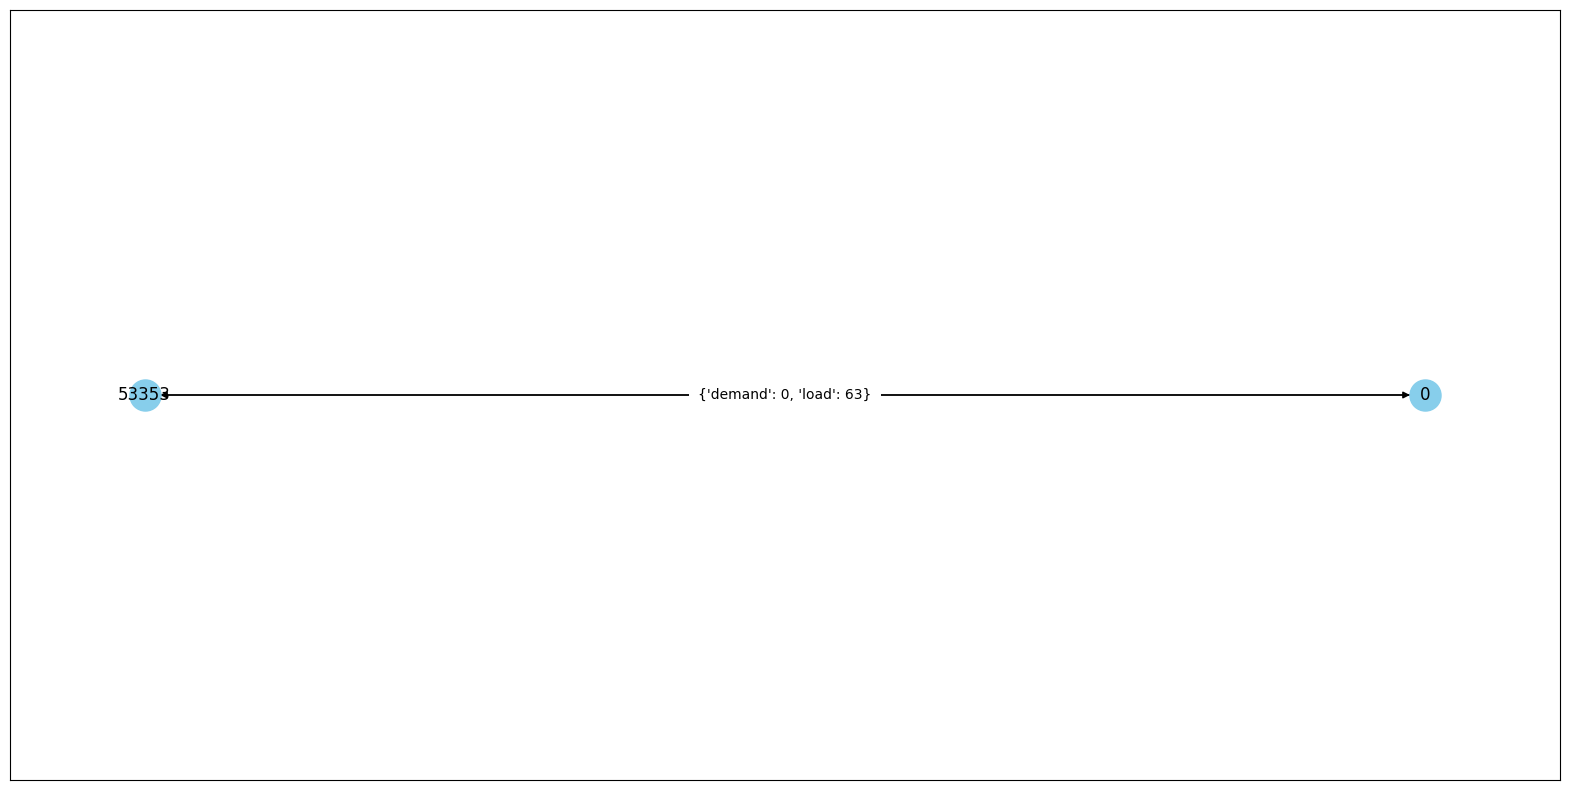



Bus 2:


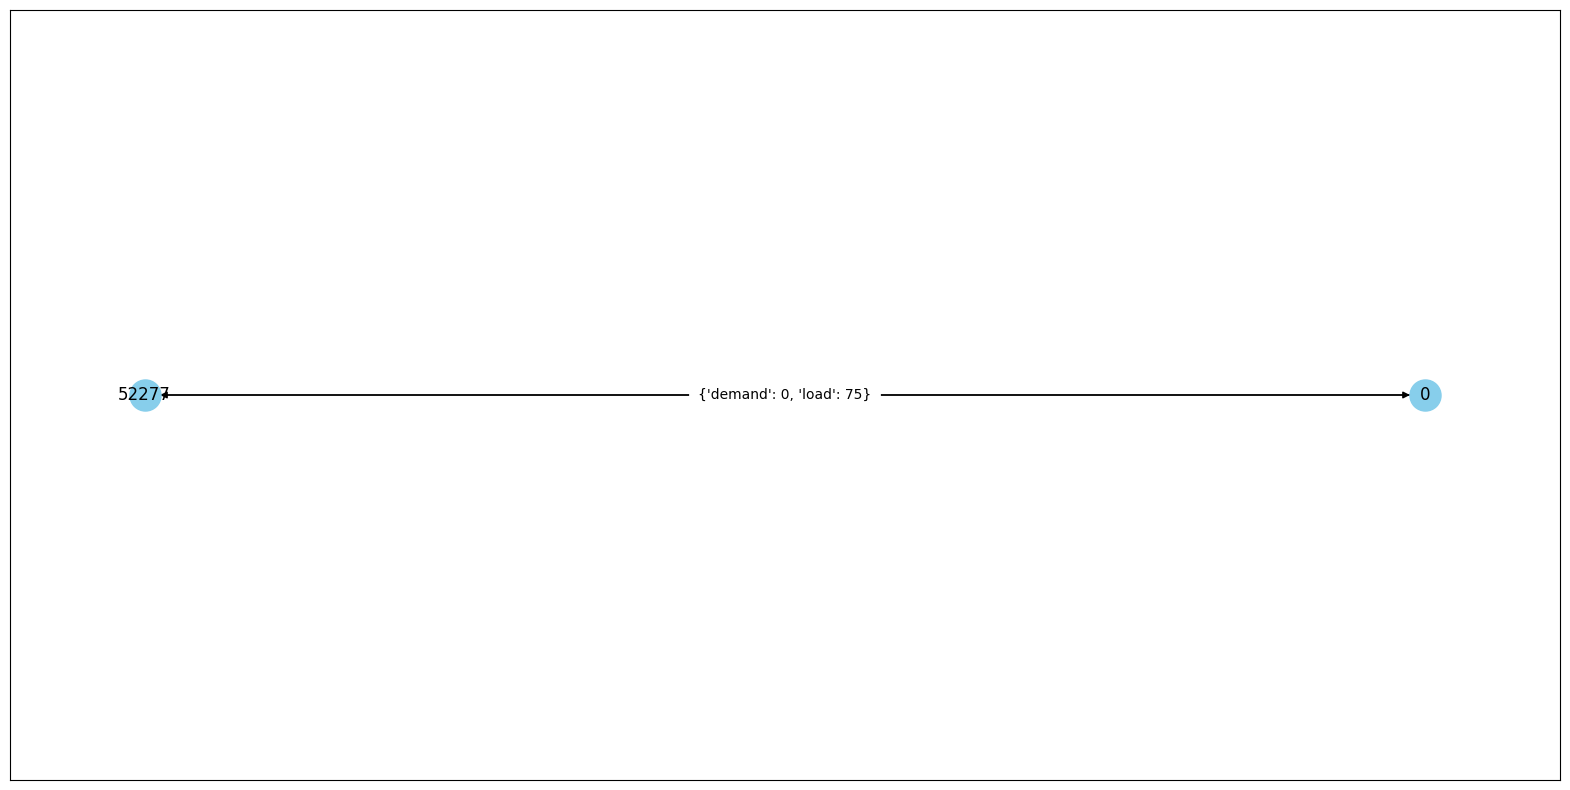



Bus 3:


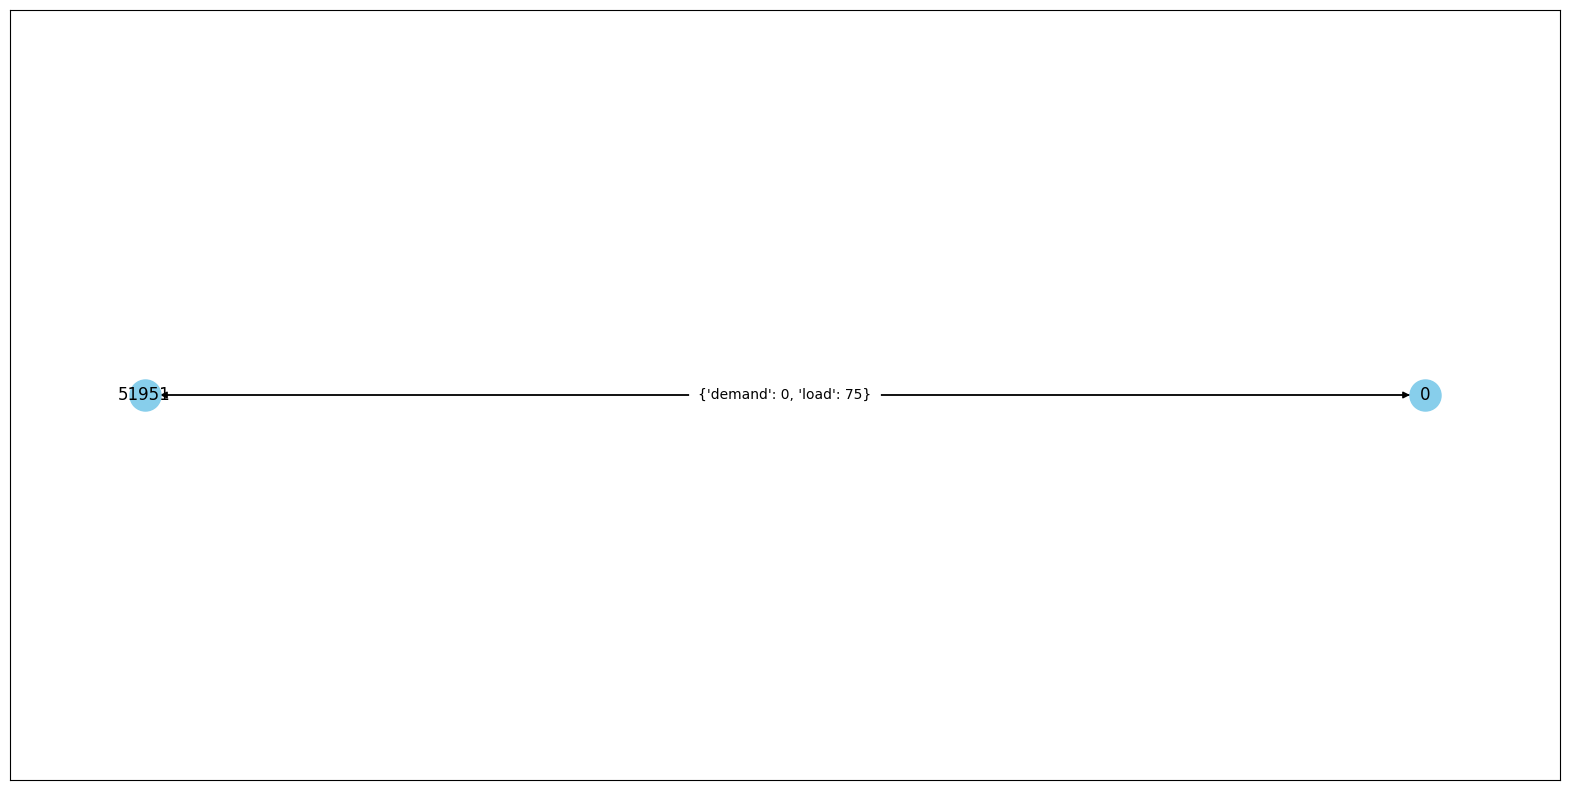



Bus 4:


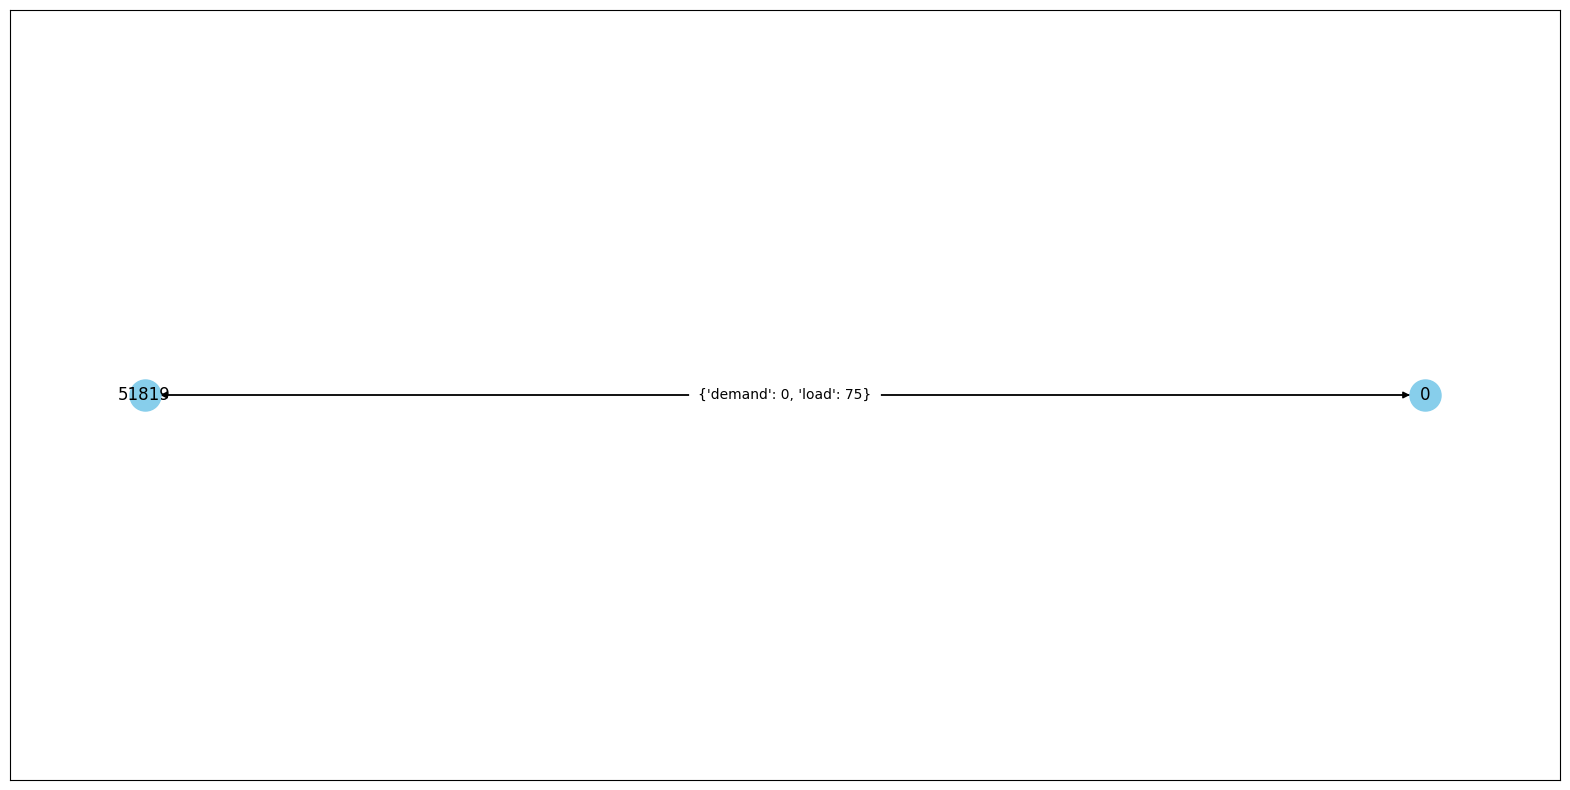



Bus 5:


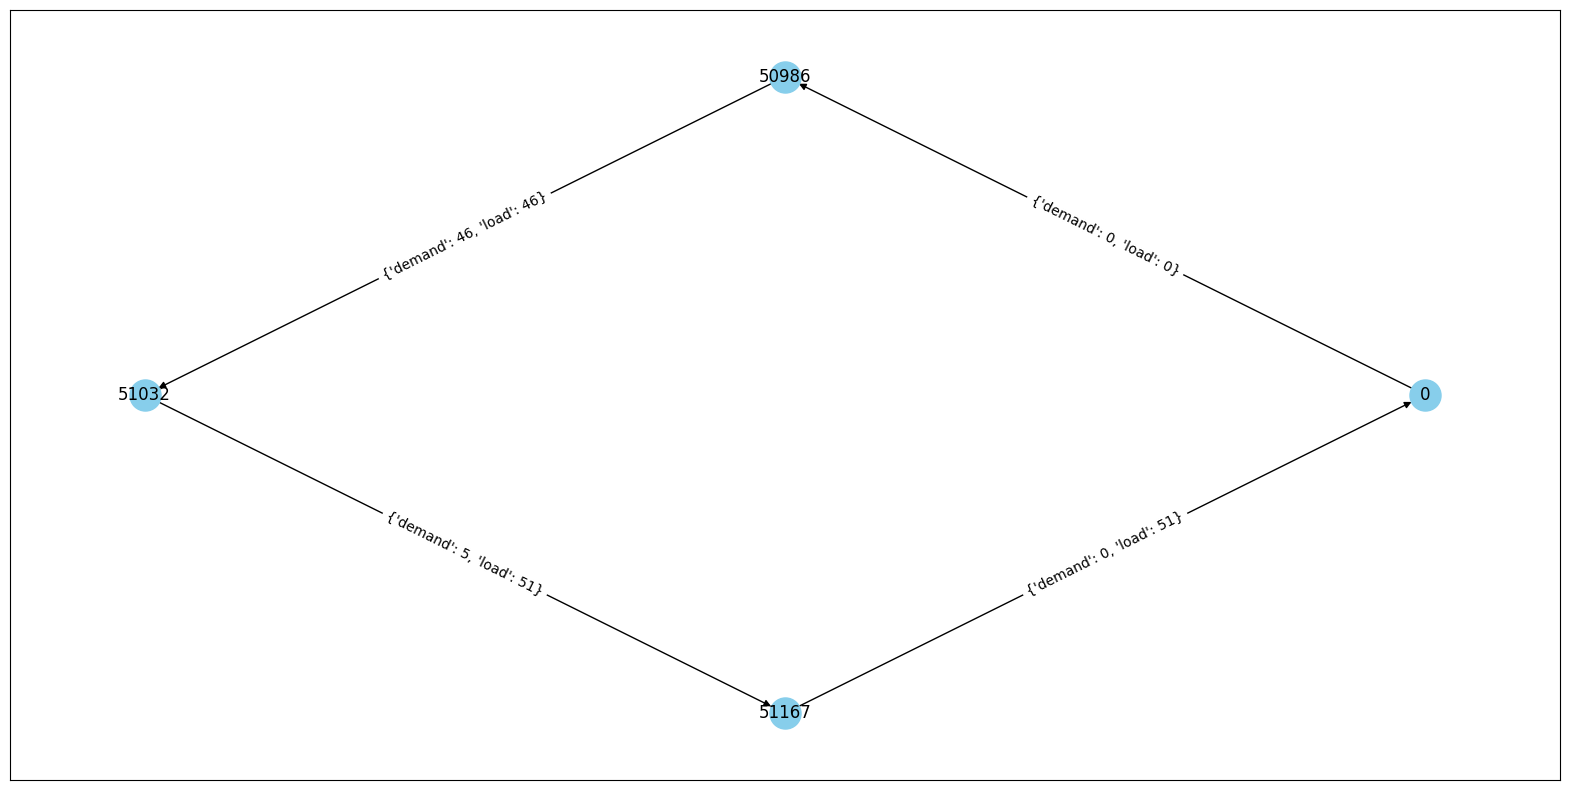



Bus 6:


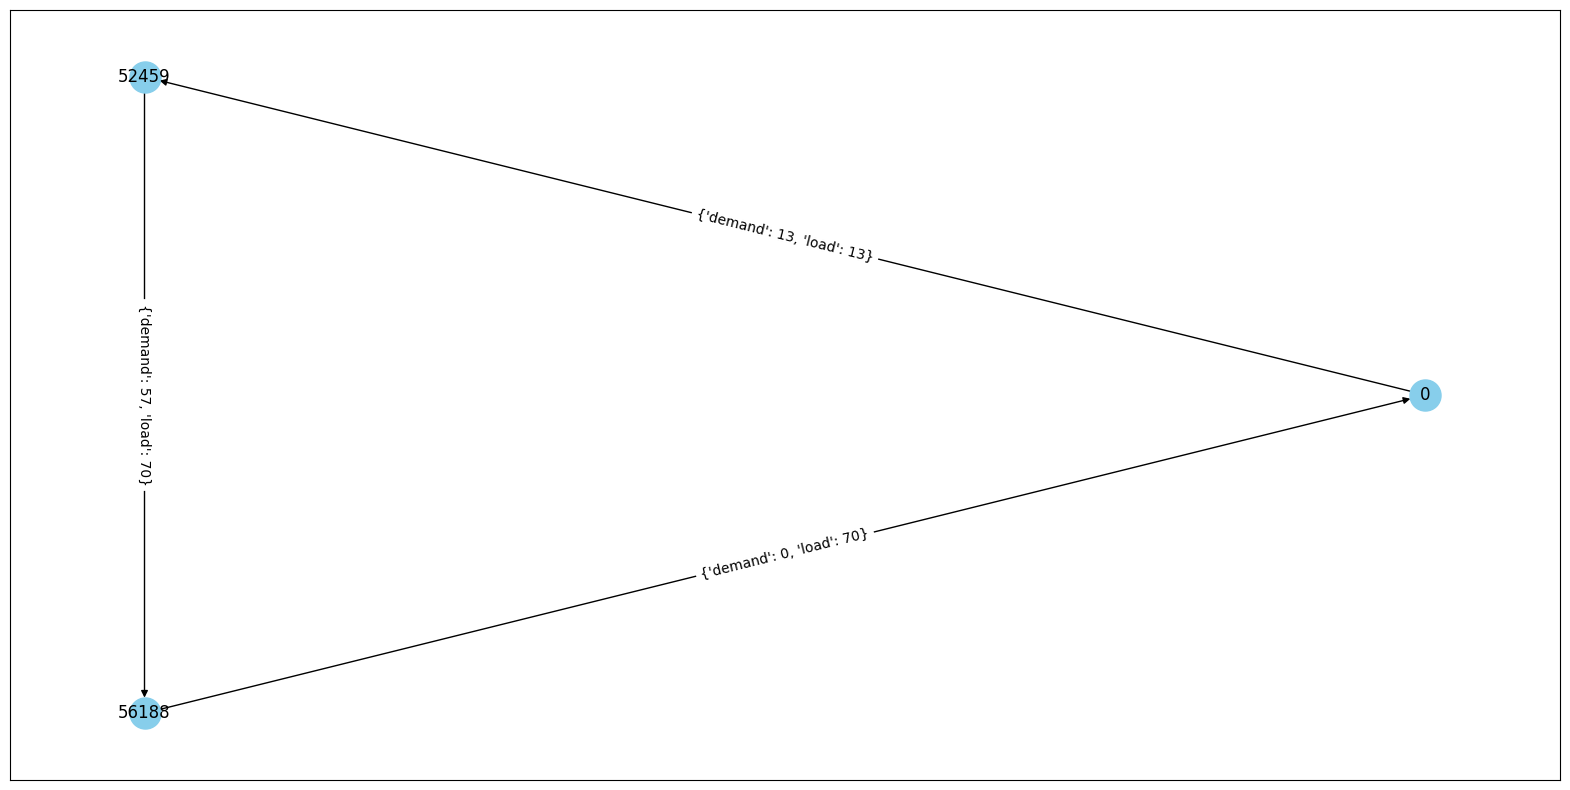



Bus 7:


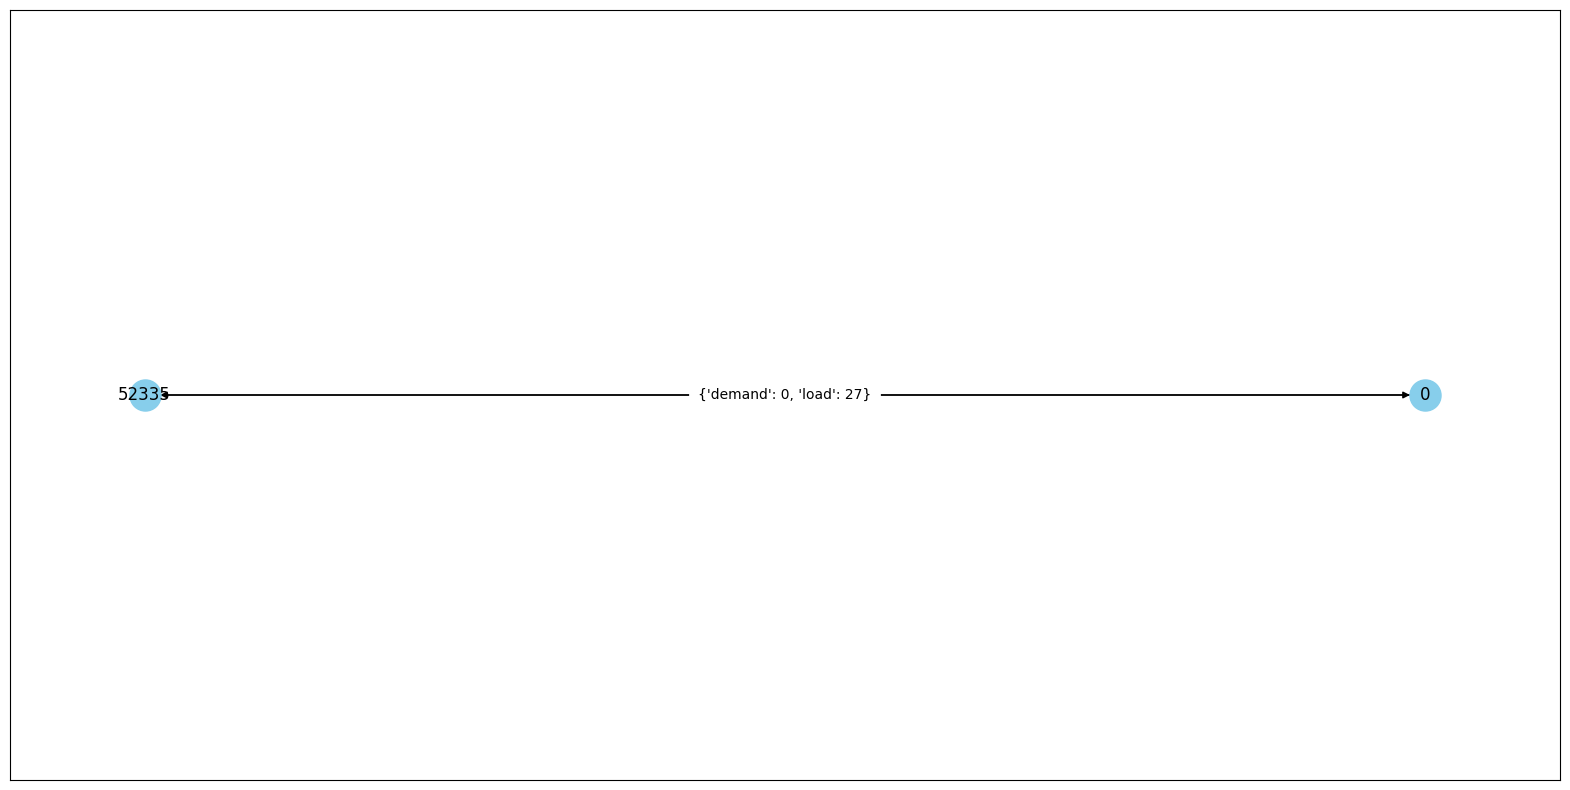



Bus 8:


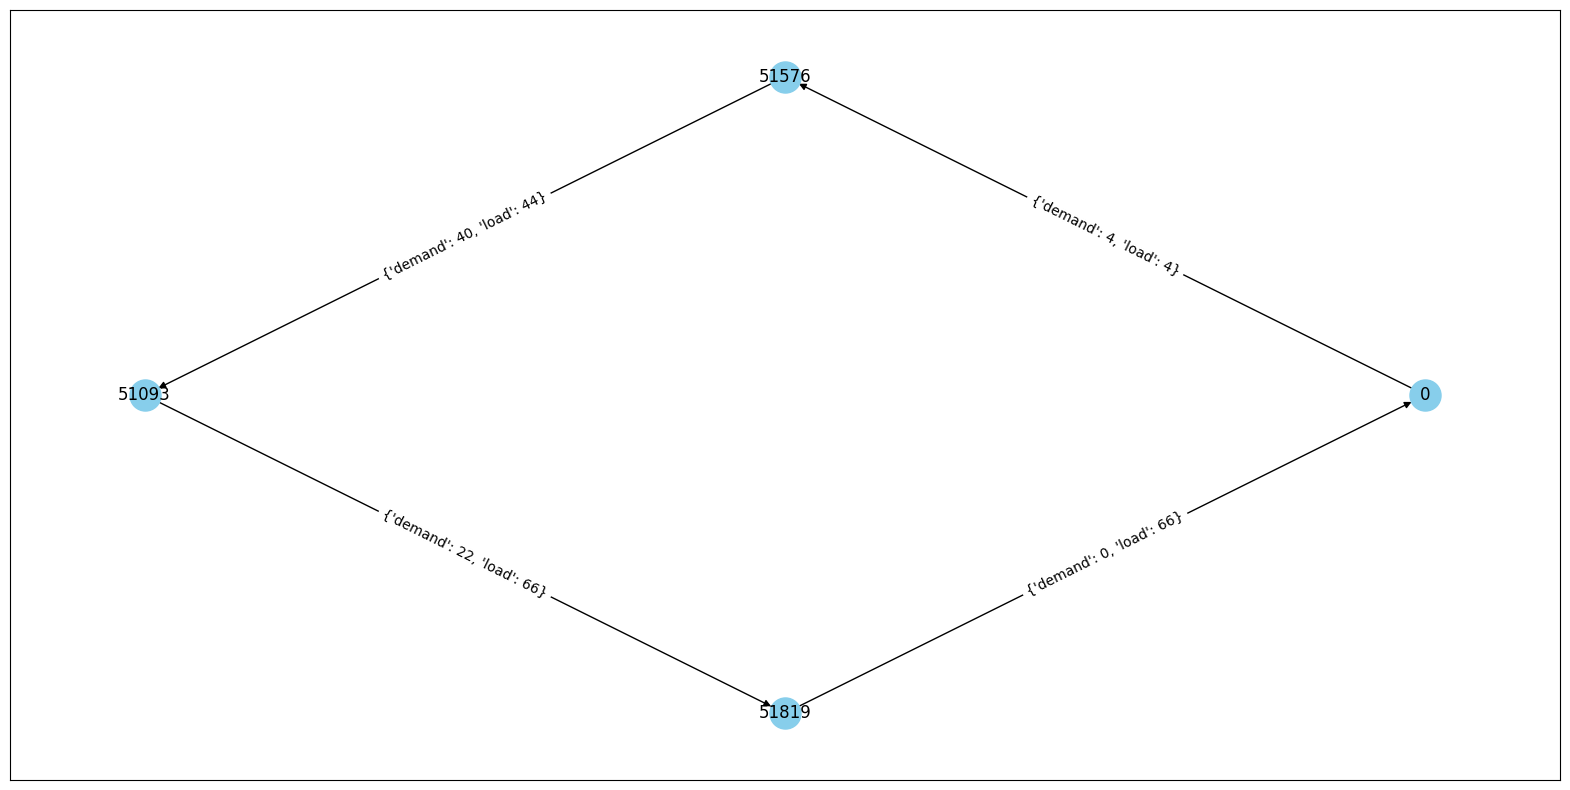



Bus 9:


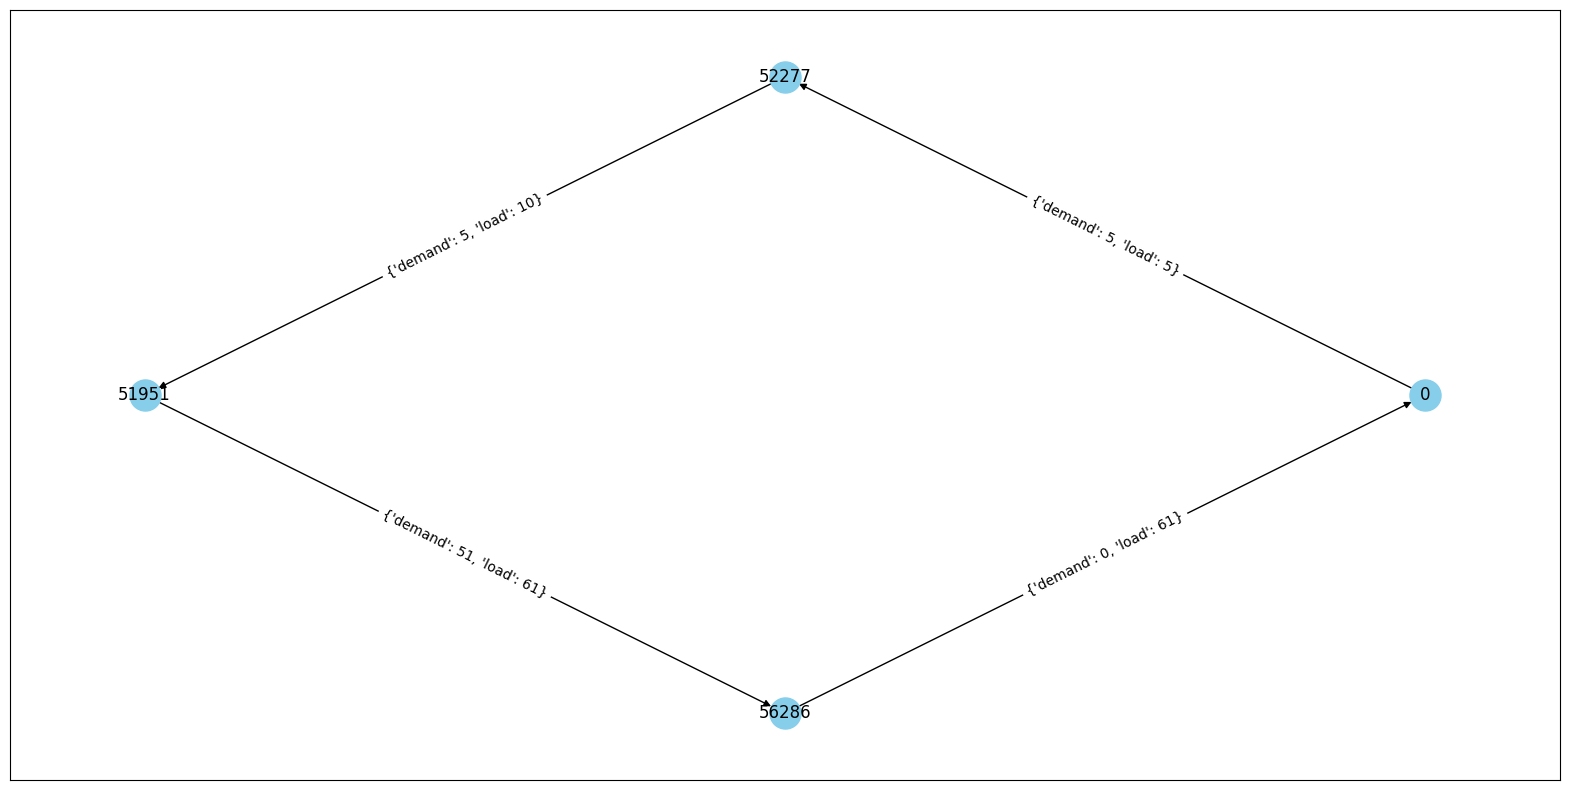



Bus 10:


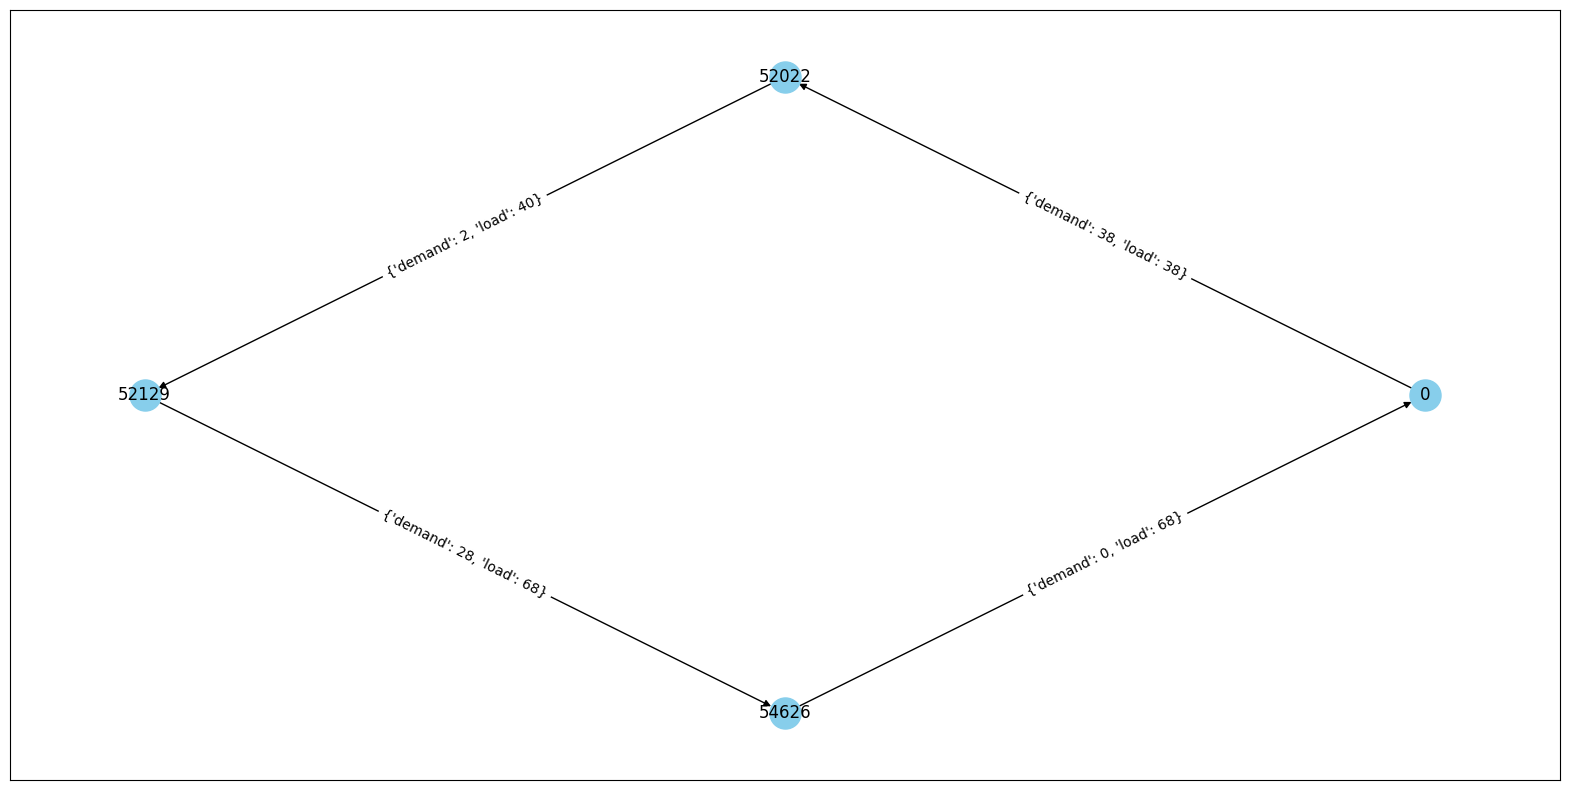

In [36]:
for bus in bus_path_df.bus.unique():
    print(f"Bus {bus + 1}:")

    bus_route = bus_path_df[bus_path_df["bus"] == bus].reset_index(drop=True)

    plt.figure(figsize=(20, 10))

    g = nx.DiGraph()

    for segment in bus_route.itertuples():
        g.add_edge(
            segment.start_stop,
            segment.end_stop,
            weight=segment.distance,
            demands={"demand": segment.demand, "load": segment.step_demand},
            step=segment.step,
            label=f"{segment.start_stop}-{segment.end_stop}",
            load=segment.step_demand,
        )

    pos = nx.circular_layout(g)

    nx.draw_networkx(g, pos, with_labels=True, node_size=500, node_color="skyblue")
    nx.draw_networkx_edge_labels(
        g, pos, edge_labels=nx.get_edge_attributes(g, "demands")
    )

    plt.show()

    print("\n")

In [37]:
routes_gdf = (
    gpd.GeoDataFrame(bus_path_df.groupby("bus")["geometry"].apply(list))
    .rename(columns={"points": "geometry"})
    .reset_index()
)

# add depot to each geometry
routes_gdf["points"] = routes_gdf.apply(
    lambda x: [Point((float(depot.stop_lon), float(depot.stop_lat)))] + x.geometry,
    axis=1,
)

routes_gdf["geometry"] = routes_gdf["points"].apply(LineString)
routes_gdf.drop(columns=["points"], inplace=True)

routes_gdf = routes_gdf.merge(
    bus_path_df.groupby("bus")["demand"].sum().rename("demand").reset_index(),
    on="bus",
)

routes_gdf = gpd.GeoDataFrame(routes_gdf, geometry="geometry")
routes_gdf.crs = "EPSG:4326"

display(routes_gdf)

,bus,geometry,demand
0,0,"LINESTRING (-73.56912 45.50485, -73.52561 45.5...",63
1,1,"LINESTRING (-73.56912 45.50485, -73.57663 45.5...",75
2,2,"LINESTRING (-73.56912 45.50485, -73.58804 45.4...",75
3,3,"LINESTRING (-73.56912 45.50485, -73.59108 45.5...",75
4,4,"LINESTRING (-73.56912 45.50485, -73.63058 45.4...",51
5,5,"LINESTRING (-73.56912 45.50485, -73.57076 45.5...",70
6,6,"LINESTRING (-73.56912 45.50485, -73.57477 45.5...",27
7,7,"LINESTRING (-73.56912 45.50485, -73.60201 45.5...",66
8,8,"LINESTRING (-73.56912 45.50485, -73.57663 45.5...",61
9,9,"LINESTRING (-73.56912 45.50485, -73.58373 45.5...",68


### Map the routes

In [38]:
colormap_route = [
    mcolors.rgb2hex(c) for c in list(plt.cm.rainbow(np.linspace(0, 1, num_buses)))
]

route_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(route_map)

for stop in bus_path_df.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color=colormap_route[stop.bus] if stop.stop_id != "0" else "black",
        fill=True,
        fill_opacity=1,
        fill_color=colormap_route[stop.bus] if stop.stop_id != "0" else "black",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        <br>
        Route: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['bus'].values[0] + 1}
        <br>
        Step: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step'].values[0] + 1}
        <br>
        Demand: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['demand'].values[0]}
        <br>
        Load: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step_demand'].values[0]}
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)

for stop in stops_in_disaster_area.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="red",
        fill=True,
        fill_opacity=1,
        fill_color="red",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)


for route in routes_gdf.itertuples():
    route_layer = folium.FeatureGroup(f"Route {route.bus + 1}")
    folium.PolyLine(
        locations=[(p[1], p[0]) for p in route.geometry.coords],
        color=colormap_route[route.bus],
        weight=3,
        opacity=0.6,
        tooltip=f"Route {route.bus + 1}",
        popup=f"""
        <div>
            <h5>Route {route.bus + 1}</h5>
            <h5>Total demand: {route.demand}</h5>
        </div>
        """,
    ).add_to(route_layer)

    route_layer.add_to(route_map)

folium.plugins.Fullscreen(position="topright").add_to(route_map)
folium.plugins.MousePosition(position="topright").add_to(route_map)
folium.LayerControl().add_to(route_map)

route_map.save("route_map_equal_split.html")
route_map

## Split delivery vehicle routing problem - split to 1

In [55]:
# This method creates a lot of nodes, which makes the model very slow to solve

In [39]:
rng = np.random.default_rng(5)

distance_matrix_model = distance_matrix.drop(
    columns=stops_in_disaster_area.stop_id, index=stops_in_disaster_area.stop_id
)

stops = list(distance_matrix_model.columns)
num_stops = len(stops)

distance_matrix_model = distance_matrix_model.loc[stops, stops]

demand = {stop: rng.integers(0, 100) for stop in stops}
demand[stops[0]] = 0


num_buses = 10
BUS_CAPACITY = 75

print(f"Total demand: {sum(demand.values())}")
print(f"Total capacity: {num_buses * BUS_CAPACITY}")

Total demand: 631
Total capacity: 750


### Split demand nodes

$$
\begin{align*}
D_{ix} &= 1 &\quad \forall x \in \{1, \dots, q_{i}\} \\
\end{align*}
$$


In [40]:
# Split the node demand into equal demand nodes of 1


def split_equal(node_demand):
    demands = [1 for _ in range(node_demand)]

    return demands


def split_demand_node(demand, node):
    node_demand = demand[node]
    demands = split_equal(node_demand)

    return {f"{node}_{i}": d for i, d in enumerate(demands, start=1)}

In [41]:
nodes_exceeding_demand = {}
new_demand = demand.copy()
for k, v in demand.items():
    if v > BUS_CAPACITY:
        new_nodes = split_demand_node(demand, k)

        new_demand.pop(k)
        new_demand.update(new_nodes)

        nodes_exceeding_demand[k] = new_nodes

print(f"New nodes added for: {list(nodes_exceeding_demand.keys())}")

# Update distance matrix to include split nodes. Distance between split nodes of same parent node is 0
for node in nodes_exceeding_demand:
    for i in range(1, len([k for k in new_demand.keys() if node in k]) + 1):
        distance_matrix_model[f"{node}_{i}"] = distance_matrix_model[node]
        distance_matrix_model.loc[f"{node}_{i}"] = distance_matrix_model.loc[node]
        distance_matrix_model.loc[f"{node}_{i}", node] = 0
    distance_matrix_model.drop(columns=[node], index=[node], inplace=True)


distance_matrix_model

New nodes added for: ['52277', '51951', '51819']


,0,52129,51032,56286,53353,54626,51167,52335,52022,56188,...,51819_88,51819_89,51819_90,51819_91,51819_92,51819_93,51819_94,51819_95,51819_96,51819_97
0,0.000000,8.086734,6.222221,2.627378,10.103120,11.594164,4.975713,0.607893,4.861341,4.262466,...,5.554667,5.554667,5.554667,5.554667,5.554667,5.554667,5.554667,5.554667,5.554667,5.554667
52129,8.086734,0.000000,10.999515,10.077727,6.491115,4.264269,8.737010,8.058242,3.658592,6.976608,...,3.008662,3.008662,3.008662,3.008662,3.008662,3.008662,3.008662,3.008662,3.008662,3.008662
51032,6.222221,10.999515,0.000000,4.374956,15.488320,15.295792,2.090399,5.379148,7.869475,3.977775,...,8.142425,8.142425,8.142425,8.142425,8.142425,8.142425,8.142425,8.142425,8.142425,8.142425
56286,2.627378,10.077727,4.374956,0.000000,12.145914,13.636958,3.730018,2.036742,6.756528,5.617394,...,7.325526,7.325526,7.325526,7.325526,7.325526,7.325526,7.325526,7.325526,7.325526,7.325526
53353,10.103120,6.491115,15.488320,12.145914,0.000000,4.391695,15.929762,12.405187,10.703989,14.328314,...,10.843957,10.843957,10.843957,10.843957,10.843957,10.843957,10.843957,10.843957,10.843957,10.843957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51819_93,5.554667,3.008662,8.142425,7.325526,10.843957,7.315802,6.064912,5.405110,0.693384,4.283844,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
51819_94,5.554667,3.008662,8.142425,7.325526,10.843957,7.315802,6.064912,5.405110,0.693384,4.283844,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
51819_95,5.554667,3.008662,8.142425,7.325526,10.843957,7.315802,6.064912,5.405110,0.693384,4.283844,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
51819_96,5.554667,3.008662,8.142425,7.325526,10.843957,7.315802,6.064912,5.405110,0.693384,4.283844,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [42]:
for k, v in new_demand.items():
    assert v <= BUS_CAPACITY

assert sum(new_demand.values()) == sum(demand.values())

In [43]:
new_stops = list(distance_matrix_model.columns)
num_new_stops = len(new_stops)

print(f"Total number of stops (overall): {num_stops}")
print(f"Total number of stops (including splits): {num_new_stops}")

Total number of stops (overall): 17
Total number of stops (including splits): 271


### Model

In [61]:
# ----------------------------------------------------------------------------------------------
# Model

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.2
model.Params.TimeLimit = 60 * 10
model.Params.MIPFocus = 1


# ----------------------------------------------------------------------------------------------
# Decision Variables

x = model.addVars(
    new_stops,
    new_stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (bus {k})" for i in new_stops for j in new_stops for k in range(num_buses)
    ),
)

u = model.addVars(
    new_stops,
    vtype=gb.GRB.INTEGER,
    name=(f"Load at Stop {i}" for i in new_stops),
)

# ----------------------------------------------------------------------------------------------
# Objective Function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in new_stops
        for j in new_stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# ----------------------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in new_stops) == gb.quicksum(x[i, j, k] for j in new_stops)
        for i in new_stops
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in new_stops for k in range(num_buses)) == 1
        for j in new_stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[new_stops[0], j, k] for j in new_stops[1:]) <= 1 for k in range(num_buses)),
    name="Every vehicle may leave the depot if needed",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(new_demand[j] * x[i, j, k] for j in new_stops[1:] for i in new_stops)
        <= BUS_CAPACITY
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# No travel between same node
model.addConstrs(
    (x[i, i, k] == 0 for i in new_stops for k in range(num_buses)),
    name="No same node",
)

# Subtour elimination constraints
model.addConstrs(
    (
        u[j] - u[i] >= new_demand[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in new_stops[1:]
        for j in new_stops[1:]
        for k in range(num_buses)
        if i != j
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= new_demand[i] for i in new_stops[1:]),
    name="Lower bound for u",
)

model.addConstrs(
    (u[i] <= BUS_CAPACITY for i in new_stops[1:]),
    name="Upper bound for u",
)

# Distance between two travel nodes is less than specified distance
model.addConstrs(
    (
        distance_matrix_model.loc[i, j] * x[i, j, k] <= 5
        for i in new_stops[1:]
        for j in new_stops[1:]
        for k in range(num_buses)
    ),
    name="Distance between two travel nodes is less than a specified distance",
)

# ----------------------------------------------------------------------------------------------
# Solve model
model.update()
model.optimize()

Set parameter MIPGap to value 0.2
Set parameter TimeLimit to value 600
Set parameter MIPFocus to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 339048 rows, 171842 columns and 1324217 nonzeros
Model fingerprint: 0x5616b604
Variable types: 0 continuous, 171842 integer (171735 binary)
Coefficient statistics:
  Matrix range     [3e-01, 2e+01]
  Objective range  [3e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 297645 rows and 128852 columns
Presolve time: 1.90s
Presolved: 41403 rows, 42990 columns, 285842 nonzeros
Variable types: 0 continuous, 42990 integer (42885 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 3.180859e+01, 22607 iterations, 0.86 seconds (0.64 work units)
Total ela

### Optimal solution routes

In [ ]:
print(f"Objective value: {model.objVal:.2f} km")

# Distance by bus
distance_bus = pd.DataFrame(
    {
        "bus": k,
        "distance": sum(
            distance_matrix_model.loc[i, j] * x[i, j, k].x
            for i in new_stops
            for j in new_stops
        ),
    }
    for k in range(num_buses)
)

distance_bus = distance_bus[distance_bus["distance"] > 0].reset_index(drop=True)

display(distance_bus)

# Bus paths
bus_path = {}

for k in range(num_buses):
    bus_path[k] = []
    for i in new_stops:
        for j in new_stops:
            if x[i, j, k].x == 1:
                bus_path[k].append(
                    {
                        "start_stop": i,
                        "end_stop": j,
                        "distance": distance_matrix_model.loc[i, j],
                    }
                )

# Convert to dataframe with bus route number
bus_path_df = []

for k, v in bus_path.items():
    bus_path_df.append(pd.DataFrame(v).assign(bus=k))

bus_path_df = pd.concat(bus_path_df)

paths = {}

grouped = bus_path_df.groupby("bus")

# Iterate over each bus group
for bus, group in grouped:
    sorted_group = group.sort_values(by=["start_stop", "end_stop"]).reset_index(
        drop=True
    )
    path = ["0"]  # Initialize the path with the depot

    # Start with the first stop after the depot
    current_stop = sorted_group.loc[
        sorted_group["start_stop"] == "0", "end_stop"
    ].values[0]
    path.append(current_stop)

    # Follow the chain of stops
    while True:
        # Find the next stop where the current stop is the start stop
        next_stop = sorted_group.loc[
            sorted_group["start_stop"] == current_stop, "end_stop"
        ].values
        if not next_stop:
            break  # If there is no next stop, we've completed the path
        next_stop = next_stop[0]

        # Add the next stop to the path and set it as the current stop
        if next_stop == "0":
            break  # If the next stop is the depot, we've completed the path
        path.append(next_stop)
        current_stop = next_stop

    # Store the path for this bus
    paths[bus] = path

bus_path_df["step"] = bus_path_df.apply(
    lambda x: paths[x.bus].index(x.start_stop), axis=1
)

bus_path_df.sort_values(by=["bus", "step"], inplace=True)

bus_path_df["demand"] = bus_path_df["end_stop"].map(new_demand)

bus_path_df[["start_stop", "end_stop"]] = bus_path_df[
    ["start_stop", "end_stop"]
].applymap(lambda x: x.split("_")[0])


bus_path_df = bus_path_df.merge(
    random_stops_df_gpd[["stop_id", "stop_name", "geometry"]],
    left_on="end_stop",
    right_on="stop_id",
    how="left",
)


bus_path_df["step_demand"] = bus_path_df.groupby("bus")["demand"].cumsum()

num_buses_used = bus_path_df.bus.nunique()
print(f"Number of buses used: {num_buses_used}")

display(bus_path_df)

# Print routes
for route in paths:
    print(f"Route {route +  1}: {' -> '.join(paths[route])} -> 0")

Objective value: 146.19 km


,bus,distance
0,0,1.722974
1,1,4.766190
2,2,20.206240
3,3,12.615122
4,5,5.254756
5,6,19.136943
6,7,1.215786
7,8,38.671021
8,9,13.288333
9,12,9.567015


Number of buses used: 11


,start_stop,end_stop,distance,bus,step,demand,stop_id,stop_name,geometry,step_demand
0,0,52277,0.861487,0,0,80,52277,Sherbrooke / Peel,POINT (-73.57663 45.50163),80
1,52277,0,0.861487,0,1,0,0,Depot,POINT (-73.56912 45.50485),80
2,0,51951,2.383095,1,0,80,51951,Sherbrooke / Atwater,POINT (-73.58804 45.49107),80
3,51951,0,2.383095,1,1,0,0,Depot,POINT (-73.56912 45.50485),80
4,0,53353,10.103120,2,0,63,53353,Haig / No 2105,POINT (-73.52561 45.58091),63
5,53353,0,10.103120,2,1,0,0,Depot,POINT (-73.56912 45.50485),63
6,0,50986,6.307561,3,0,80,50986,Queen-Mary / Earnscliffe,POINT (-73.63058 45.48183),80
7,50986,0,6.307561,3,1,0,0,Depot,POINT (-73.56912 45.50485),80
8,0,56286,2.627378,5,0,51,56286,Sherbrooke / Greene,POINT (-73.59190 45.48773),51
9,56286,0,2.627378,5,1,0,0,Depot,POINT (-73.56912 45.50485),51


Route 1: 0 -> 52277 -> 0
Route 2: 0 -> 51951 -> 0
Route 3: 0 -> 53353 -> 0
Route 4: 0 -> 50986_1 -> 0
Route 6: 0 -> 56286 -> 0
Route 7: 0 -> 50986_2 -> 56188 -> 51093 -> 51576 -> 0
Route 8: 0 -> 52335 -> 0
Route 9: 0 -> 55078 -> 50555 -> 50804_2 -> 51819 -> 52129 -> 54626 -> 0
Route 10: 0 -> 51032 -> 51167 -> 0
Route 13: 0 -> 52459 -> 52022 -> 0
Route 15: 0 -> 50804_1 -> 0


In [ ]:
for bus in bus_path_df.bus.unique():
    print(f"Bus {bus + 1}:")

    bus_route = bus_path_df[bus_path_df["bus"] == bus].reset_index(drop=True)

    plt.figure(figsize=(20, 10))

    g = nx.DiGraph()

    for segment in bus_route.itertuples():
        g.add_edge(
            segment.start_stop,
            segment.end_stop,
            weight=segment.distance,
            demands={"demand": segment.demand, "load": segment.step_demand},
            step=segment.step,
            label=f"{segment.start_stop}-{segment.end_stop}",
            load=segment.step_demand,
        )

    pos = nx.circular_layout(g)

    nx.draw_networkx(g, pos, with_labels=True, node_size=500, node_color="skyblue")
    nx.draw_networkx_edge_labels(
        g, pos, edge_labels=nx.get_edge_attributes(g, "demands")
    )

    plt.show()

    print("\n")

In [ ]:
routes_gdf = (
    gpd.GeoDataFrame(bus_path_df.groupby("bus")["geometry"].apply(list))
    .rename(columns={"points": "geometry"})
    .reset_index()
)

# add depot to each geometry
routes_gdf["points"] = routes_gdf.apply(
    lambda x: [Point((float(depot.stop_lon), float(depot.stop_lat)))] + x.geometry,
    axis=1,
)

routes_gdf["geometry"] = routes_gdf["points"].apply(LineString)
routes_gdf.drop(columns=["points"], inplace=True)

routes_gdf = routes_gdf.merge(
    bus_path_df.groupby("bus")["demand"].sum().rename("demand").reset_index(),
    on="bus",
)

routes_gdf = gpd.GeoDataFrame(routes_gdf, geometry="geometry")
routes_gdf.crs = "EPSG:4326"

display(routes_gdf)

,bus,geometry,demand
0,0,"LINESTRING (-73.56912 45.50485, -73.57663 45.5...",80
1,1,"LINESTRING (-73.56912 45.50485, -73.58804 45.4...",80
2,2,"LINESTRING (-73.56912 45.50485, -73.52561 45.5...",63
3,3,"LINESTRING (-73.56912 45.50485, -73.63058 45.4...",80
4,5,"LINESTRING (-73.56912 45.50485, -73.59190 45.4...",51
5,6,"LINESTRING (-73.56912 45.50485, -73.63058 45.4...",77
6,7,"LINESTRING (-73.56912 45.50485, -73.57477 45.5...",38
7,8,"LINESTRING (-73.56912 45.50485, -73.64025 45.5...",65
8,9,"LINESTRING (-73.56912 45.50485, -73.62863 45.4...",73
9,12,"LINESTRING (-73.56912 45.50485, -73.57076 45.5...",61


### Map the routes

In [ ]:
colormap_route = [
    mcolors.rgb2hex(c) for c in list(plt.cm.rainbow(np.linspace(0, 1, num_buses)))
]

route_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(route_map)

for stop in bus_path_df.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color=colormap_route[stop.bus] if stop.stop_id != "0" else "black",
        fill=True,
        fill_opacity=1,
        fill_color=colormap_route[stop.bus] if stop.stop_id != "0" else "black",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        <br>
        Route: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['bus'].values[0] + 1}
        <br>
        Step: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step'].values[0] + 1}
        <br>
        Demand: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['demand'].values[0]}
        <br>
        Load: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step_demand'].values[0]}
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)

for stop in stops_in_disaster_area.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="red",
        fill=True,
        fill_opacity=1,
        fill_color="red",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)


for route in routes_gdf.itertuples():
    route_layer = folium.FeatureGroup(f"Route {route.bus + 1}")
    folium.PolyLine(
        locations=[(p[1], p[0]) for p in route.geometry.coords],
        color=colormap_route[route.bus],
        weight=3,
        opacity=0.6,
        tooltip=f"Route {route.bus + 1}",
        popup=f"""
        <div>
            <h5>Route {route.bus + 1}</h5>
            <h5>Total demand: {route.demand}</h5>
        </div>
        """,
    ).add_to(route_layer)

    route_layer.add_to(route_map)

folium.plugins.Fullscreen(position="topright").add_to(route_map)
folium.plugins.MousePosition(position="topright").add_to(route_map)
folium.LayerControl().add_to(route_map)

route_map.save("route_map_split_to_1.html")
route_map

## Split delivery vehicle routing problem - split randomly

In [45]:
rng = np.random.default_rng(5)

distance_matrix_model = distance_matrix.drop(
    columns=stops_in_disaster_area.stop_id, index=stops_in_disaster_area.stop_id
)

stops = list(distance_matrix_model.columns)
num_stops = len(stops)

distance_matrix_model = distance_matrix_model.loc[stops, stops]

demand = {stop: rng.integers(0, 100) for stop in stops}
demand[stops[0]] = 0


num_buses = 10
BUS_CAPACITY = 75

print(f"Total demand: {sum(demand.values())}")
print(f"Total capacity: {num_buses * BUS_CAPACITY}")

Total demand: 631
Total capacity: 750


### Split demand nodes

$$
\begin{align*}
D_{ix} &= Z \sim \{1, Q\}
\end{align*}
$$


In [46]:
# Split the node demand into equal demand nodes of 1


def split_random_demand(node_demand):
    demands = []
    remaining_demand = node_demand

    while remaining_demand > 0:
        demand = rng.integers(1, BUS_CAPACITY)
        demands.append(demand)
        remaining_demand -= demand

    if sum(demands) > node_demand:
        demands[-1] -= sum(demands) - node_demand

    return demands


def split_demand_node(demand, node):
    node_demand = demand[node]
    demands = split_random_demand(node_demand)

    return {f"{node}_{i}": d for i, d in enumerate(demands, start=1)}

In [47]:
nodes_exceeding_demand = {}
new_demand = demand.copy()
for k, v in demand.items():
    if v > BUS_CAPACITY:
        new_nodes = split_demand_node(demand, k)

        new_demand.pop(k)
        new_demand.update(new_nodes)

        nodes_exceeding_demand[k] = new_nodes

print(f"New nodes added for: {list(nodes_exceeding_demand.keys())}")

# Update distance matrix to include split nodes. Distance between split nodes of same parent node is 0
for node in nodes_exceeding_demand:
    for i in range(1, len([k for k in new_demand.keys() if node in k]) + 1):
        distance_matrix_model[f"{node}_{i}"] = distance_matrix_model[node]
        distance_matrix_model.loc[f"{node}_{i}"] = distance_matrix_model.loc[node]
        distance_matrix_model.loc[f"{node}_{i}", node] = 0
    distance_matrix_model.drop(columns=[node], index=[node], inplace=True)


distance_matrix_model

New nodes added for: ['52277', '51951', '51819']


,0,52129,51032,56286,53353,54626,51167,52335,52022,56188,...,52277_2,52277_3,51951_1,51951_2,51951_3,51819_1,51819_2,51819_3,51819_4,51819_5
0,0.000000,8.086734,6.222221,2.627378,10.103120,11.594164,4.975713,0.607893,4.861341,4.262466,...,0.861487,0.861487,2.383095,2.383095,2.383095,5.554667,5.554667,5.554667,5.554667,5.554667
52129,8.086734,0.000000,10.999515,10.077727,6.491115,4.264269,8.737010,8.058242,3.658592,6.976608,...,8.346380,8.346380,9.833444,9.833444,9.833444,3.008662,3.008662,3.008662,3.008662,3.008662
51032,6.222221,10.999515,0.000000,4.374956,15.488320,15.295792,2.090399,5.379148,7.869475,3.977775,...,5.360734,5.360734,5.004114,5.004114,5.004114,8.142425,8.142425,8.142425,8.142425,8.142425
56286,2.627378,10.077727,4.374956,0.000000,12.145914,13.636958,3.730018,2.036742,6.756528,5.617394,...,1.765891,1.765891,0.342071,0.342071,0.342071,7.325526,7.325526,7.325526,7.325526,7.325526
53353,10.103120,6.491115,15.488320,12.145914,0.000000,4.391695,15.929762,12.405187,10.703989,14.328314,...,10.362766,10.362766,11.883060,11.883060,11.883060,10.843957,10.843957,10.843957,10.843957,10.843957
54626,11.594164,4.264269,15.295792,13.636958,4.391695,0.000000,13.044150,11.634556,7.896478,11.283748,...,11.853810,11.853810,13.374104,13.374104,13.374104,7.315802,7.315802,7.315802,7.315802,7.315802
51167,4.975713,8.737010,2.090399,3.730018,15.929762,13.044150,0.000000,4.413204,5.779076,1.887376,...,4.114226,4.114226,3.757606,3.757606,3.757606,6.064912,6.064912,6.064912,6.064912,6.064912
52335,0.607893,8.058242,5.379148,2.036742,12.405187,11.634556,4.413204,0.000000,4.867393,4.262720,...,0.253594,0.253594,1.773888,1.773888,1.773888,5.405110,5.405110,5.405110,5.405110,5.405110
52022,4.861341,3.658592,7.869475,6.756528,10.703989,7.896478,5.779076,4.867393,0.000000,4.366552,...,5.120987,5.120987,6.641281,6.641281,6.641281,0.693384,0.693384,0.693384,0.693384,0.693384
56188,4.262466,6.976608,3.977775,5.617394,14.328314,11.283748,1.887376,4.262720,4.366552,0.000000,...,4.398190,4.398190,5.644982,5.644982,5.644982,4.283844,4.283844,4.283844,4.283844,4.283844


In [48]:
for k, v in new_demand.items():
    assert v <= BUS_CAPACITY

assert sum(new_demand.values()) == sum(demand.values())

In [49]:
new_stops = list(distance_matrix_model.columns)
num_new_stops = len(new_stops)

print(f"Total number of stops (overall): {num_stops}")
print(f"Total number of stops (including splits): {num_new_stops}")

Total number of stops (overall): 17
Total number of stops (including splits): 25


### Model

In [50]:
# ----------------------------------------------------------------------------------------------
# Model

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.2
model.Params.TimeLimit = 60 * 2
model.Params.MIPFocus = 1


# ----------------------------------------------------------------------------------------------
# Decision Variables

x = model.addVars(
    new_stops,
    new_stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (bus {k})" for i in new_stops for j in new_stops for k in range(num_buses)
    ),
)

u = model.addVars(
    new_stops,
    vtype=gb.GRB.INTEGER,
    name=(f"Load at Stop {i}" for i in new_stops),
)

# ----------------------------------------------------------------------------------------------
# Objective Function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in new_stops
        for j in new_stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# ----------------------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in new_stops) == gb.quicksum(x[i, j, k] for j in new_stops)
        for i in new_stops
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in new_stops for k in range(num_buses)) == 1
        for j in new_stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[new_stops[0], j, k] for j in new_stops[1:]) <= 1 for k in range(num_buses)),
    name="Every vehicle may leave the depot if needed",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(new_demand[j] * x[i, j, k] for j in new_stops[1:] for i in new_stops)
        <= BUS_CAPACITY
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# No travel between same node
model.addConstrs(
    (x[i, i, k] == 0 for i in new_stops for k in range(num_buses)),
    name="No same node",
)

# Subtour elimination constraints
model.addConstrs(
    (
        u[j] - u[i] >= new_demand[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in new_stops[1:]
        for j in new_stops[1:]
        for k in range(num_buses)
        if i != j
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= new_demand[i] for i in new_stops[1:]),
    name="Lower bound for u",
)

model.addConstrs(
    (u[i] <= BUS_CAPACITY for i in new_stops[1:]),
    name="Upper bound for u",
)

# Distance between two travel nodes is less than specified distance
model.addConstrs(
    (
        distance_matrix_model.loc[i, j] * x[i, j, k] <= 5
        for i in new_stops[1:]
        for j in new_stops[1:]
        for k in range(num_buses)
    ),
    name="Distance between two travel nodes is less than a specified distance",
)

# ----------------------------------------------------------------------------------------------
# Solve model
model.update()
model.optimize()

Set parameter MIPGap to value 0.2
Set parameter TimeLimit to value 180


Set parameter MIPFocus to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 11872 rows, 6275 columns and 46048 nonzeros
Model fingerprint: 0xbc4b75b8
Variable types: 0 continuous, 6275 integer (6250 binary)
Coefficient statistics:
  Matrix range     [3e-01, 8e+01]
  Objective range  [3e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Presolve removed 9648 rows and 3842 columns
Presolve time: 0.07s
Presolved: 2224 rows, 2433 columns, 15180 nonzeros
Variable types: 0 continuous, 2433 integer (2410 binary)

Root relaxation: objective 4.119802e+01, 358 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   41

### Optimal solution routes

In [51]:
print(f"Objective value: {model.objVal:.2f} km")

# Distance by bus
distance_bus = pd.DataFrame(
    {
        "bus": k,
        "distance": sum(
            distance_matrix_model.loc[i, j] * x[i, j, k].x
            for i in new_stops
            for j in new_stops
        ),
    }
    for k in range(num_buses)
)

distance_bus = distance_bus[distance_bus["distance"] > 0].reset_index(drop=True)

display(distance_bus)

# Bus paths
bus_path = {}

for k in range(num_buses):
    bus_path[k] = []
    for i in new_stops:
        for j in new_stops:
            if x[i, j, k].x == 1:
                bus_path[k].append(
                    {
                        "start_stop": i,
                        "end_stop": j,
                        "distance": distance_matrix_model.loc[i, j],
                    }
                )

# Convert to dataframe with bus route number
bus_path_df = []

for k, v in bus_path.items():
    bus_path_df.append(pd.DataFrame(v).assign(bus=k))

bus_path_df = pd.concat(bus_path_df)

paths = {}

grouped = bus_path_df.groupby("bus")

# Iterate over each bus group
for bus, group in grouped:
    sorted_group = group.sort_values(by=["start_stop", "end_stop"]).reset_index(
        drop=True
    )
    path = ["0"]  # Initialize the path with the depot

    # Start with the first stop after the depot
    current_stop = sorted_group.loc[
        sorted_group["start_stop"] == "0", "end_stop"
    ].values[0]
    path.append(current_stop)

    # Follow the chain of stops
    while True:
        # Find the next stop where the current stop is the start stop
        next_stop = sorted_group.loc[
            sorted_group["start_stop"] == current_stop, "end_stop"
        ].values
        if not next_stop:
            break  # If there is no next stop, we've completed the path
        next_stop = next_stop[0]

        # Add the next stop to the path and set it as the current stop
        if next_stop == "0":
            break  # If the next stop is the depot, we've completed the path
        path.append(next_stop)
        current_stop = next_stop

    # Store the path for this bus
    paths[bus] = path

bus_path_df["step"] = bus_path_df.apply(
    lambda x: paths[x.bus].index(x.start_stop), axis=1
)

bus_path_df.sort_values(by=["bus", "step"], inplace=True)

bus_path_df["demand"] = bus_path_df["end_stop"].map(new_demand)

bus_path_df[["start_stop", "end_stop"]] = bus_path_df[
    ["start_stop", "end_stop"]
].applymap(lambda x: x.split("_")[0])


bus_path_df = bus_path_df.merge(
    random_stops_df_gpd[["stop_id", "stop_name", "geometry"]],
    left_on="end_stop",
    right_on="stop_id",
    how="left",
)


bus_path_df["step_demand"] = bus_path_df.groupby("bus")["demand"].cumsum()

num_buses_used = bus_path_df.bus.nunique()
print(f"Number of buses used: {num_buses_used}")

display(bus_path_df)

# Print routes
for route in paths:
    print(f"Route {route +  1}: {' -> '.join(paths[route])} -> 0")

Objective value: 105.91 km


,bus,distance
0,0,20.206240
1,1,24.378366
2,2,1.722974
3,3,1.215786
4,4,8.799594
5,5,5.352544
6,6,11.109334
7,7,4.766190
8,8,13.699427
9,9,14.663516


Number of buses used: 10


,start_stop,end_stop,distance,bus,step,demand,stop_id,stop_name,geometry,step_demand
0,0,53353,10.103120,0,0,63,53353,Haig / No 2105,POINT (-73.52561 45.58091),63
1,53353,0,10.103120,0,1,0,0,Depot,POINT (-73.56912 45.50485),63
2,0,54626,11.594164,1,0,28,54626,Beaubien / des Roseraies,POINT (-73.55503 45.59649),28
3,54626,52129,4.264269,1,1,2,52129,Beaubien / Pie-IX,POINT (-73.57972 45.56243),30
4,52129,52022,3.658592,1,2,38,52022,Papineau / Masson,POINT (-73.58373 45.53723),68
5,52022,0,4.861341,1,3,0,0,Depot,POINT (-73.56912 45.50485),68
6,0,52277,0.861487,2,0,64,52277,Sherbrooke / Peel,POINT (-73.57663 45.50163),64
7,52277,0,0.861487,2,1,0,0,Depot,POINT (-73.56912 45.50485),64
8,0,52335,0.607893,3,0,27,52335,Université McGill (Sherbrooke / McGill College),POINT (-73.57477 45.50352),27
9,52335,0,0.607893,3,1,0,0,Depot,POINT (-73.56912 45.50485),27


Route 1: 0 -> 53353 -> 0
Route 2: 0 -> 54626 -> 52129 -> 52022 -> 0
Route 3: 0 -> 52277_3 -> 0
Route 4: 0 -> 52335 -> 0
Route 5: 0 -> 52459 -> 56188 -> 0
Route 6: 0 -> 52277_1 -> 51951_3 -> 56286 -> 0
Route 7: 0 -> 51819_3 -> 51819_1 -> 51819_4 -> 0
Route 8: 0 -> 51951_1 -> 51951_2 -> 0
Route 9: 0 -> 52277_2 -> 51167 -> 51032 -> 50986 -> 0
Route 10: 0 -> 51819_5 -> 51819_2 -> 51093 -> 51576 -> 0


Bus 1:


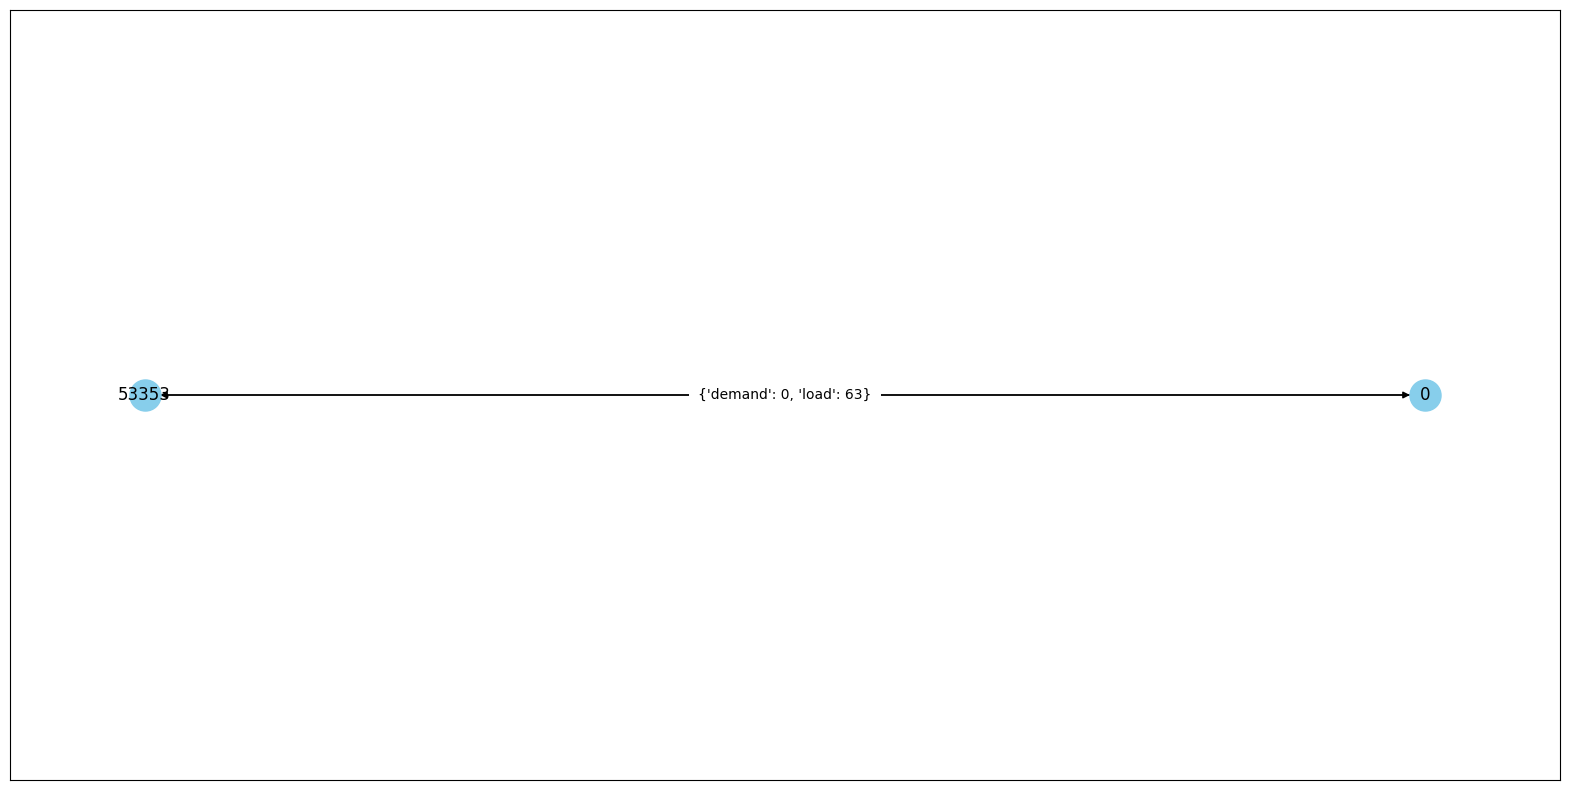



Bus 2:


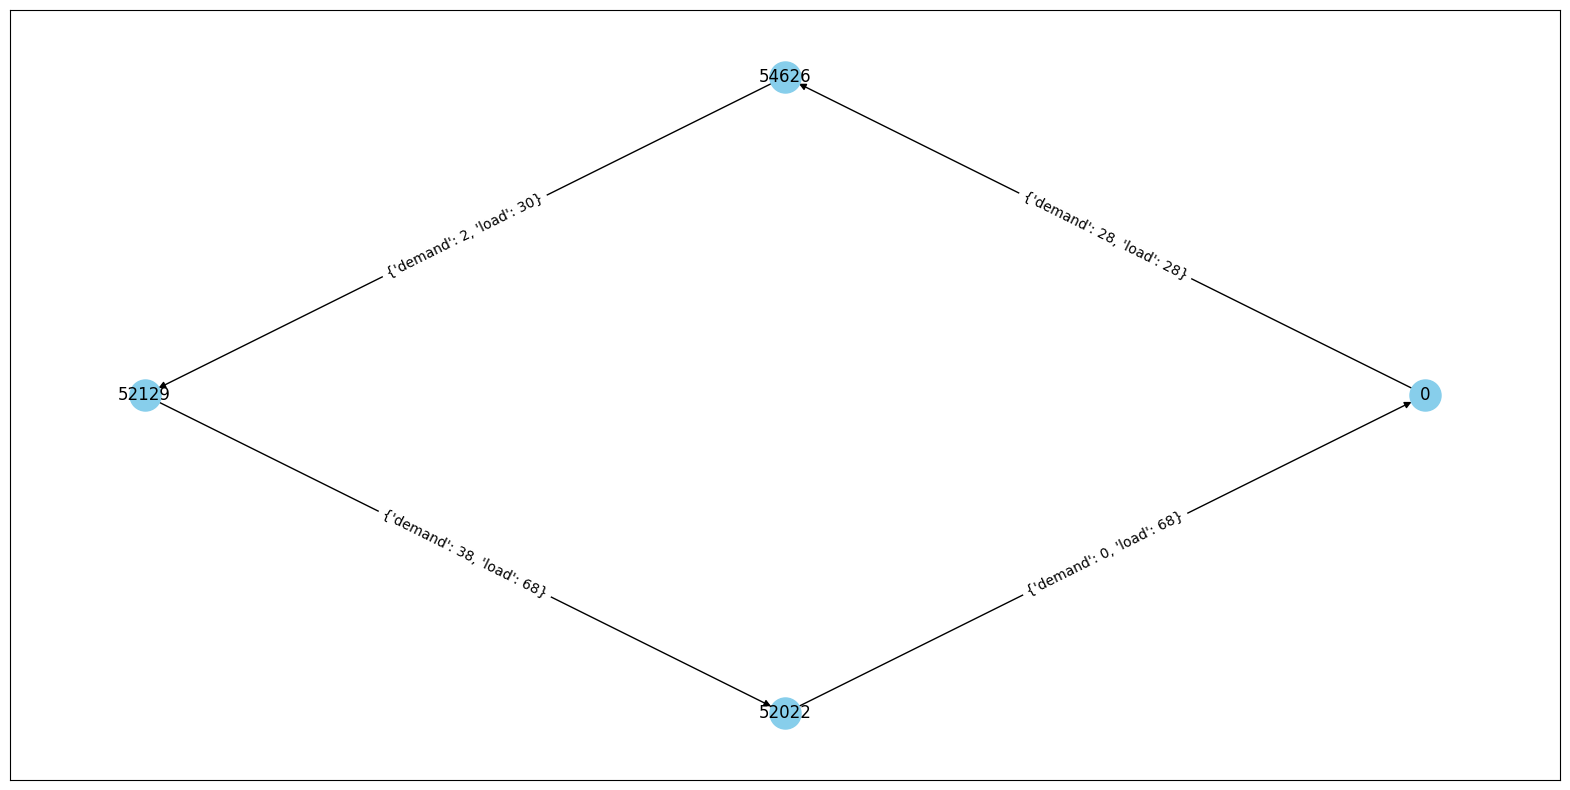



Bus 3:


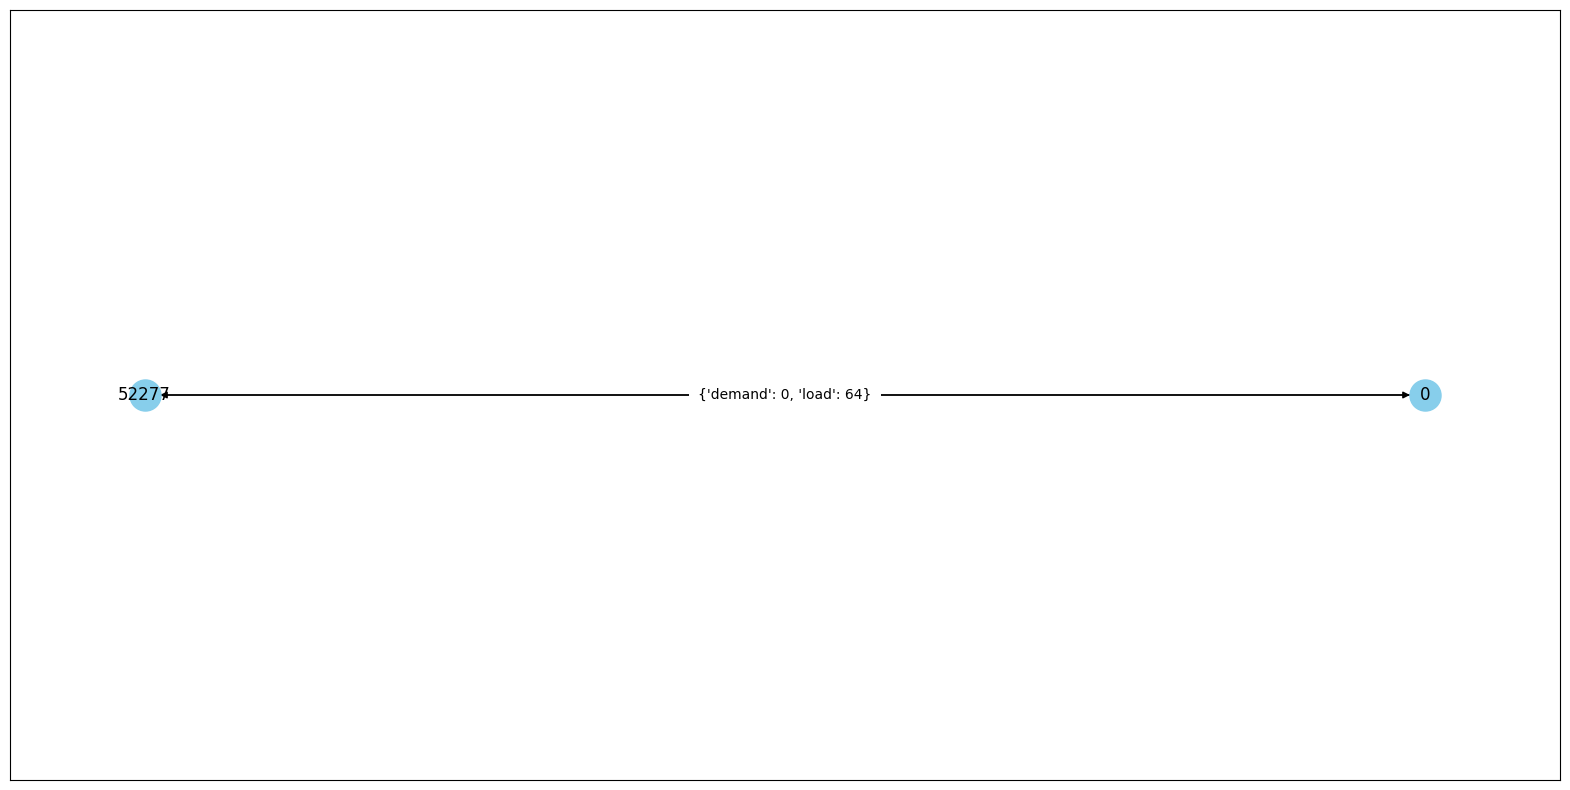



Bus 4:


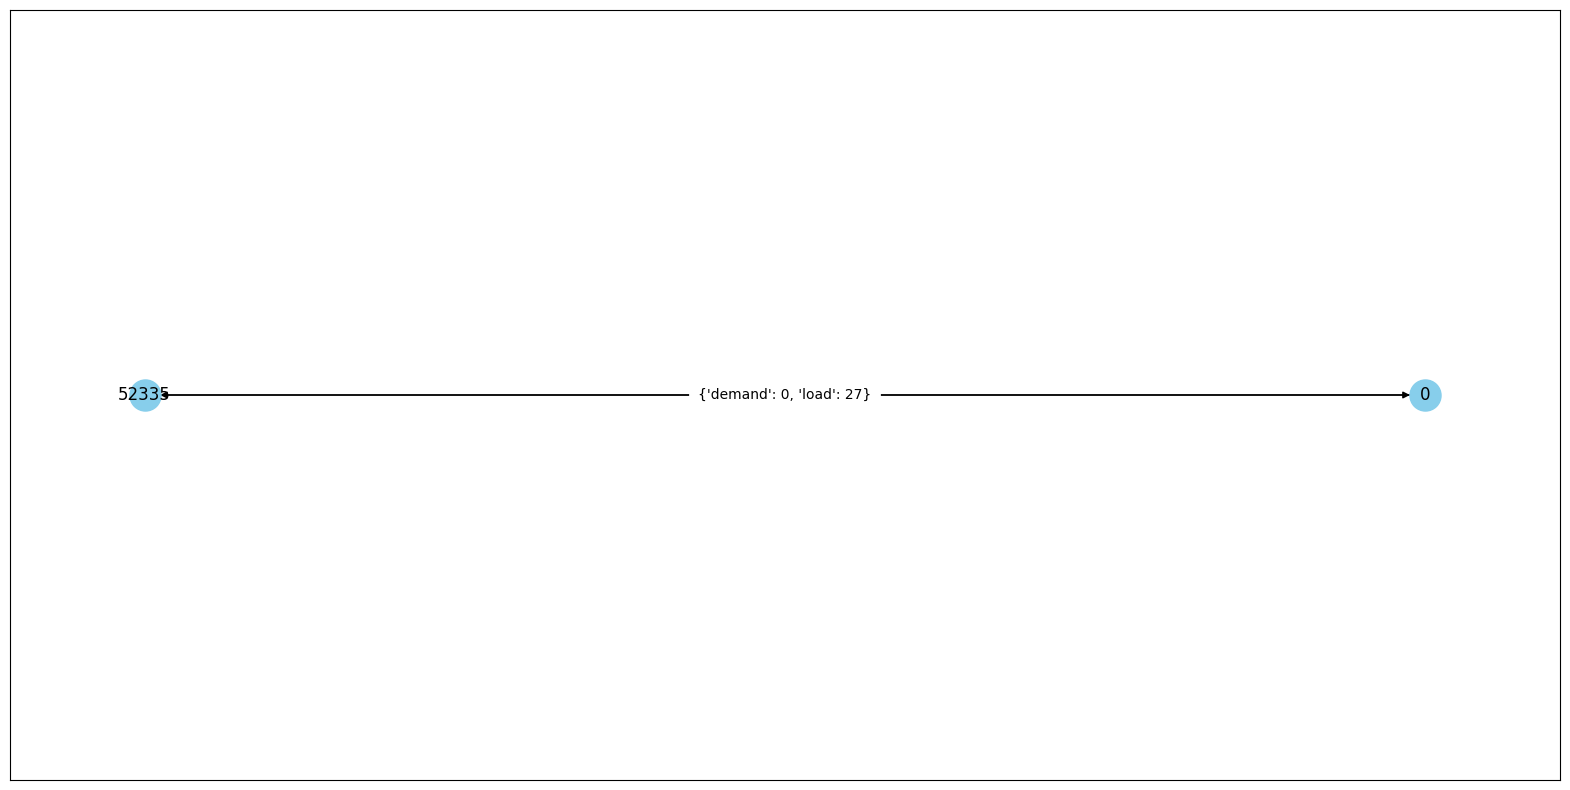



Bus 5:


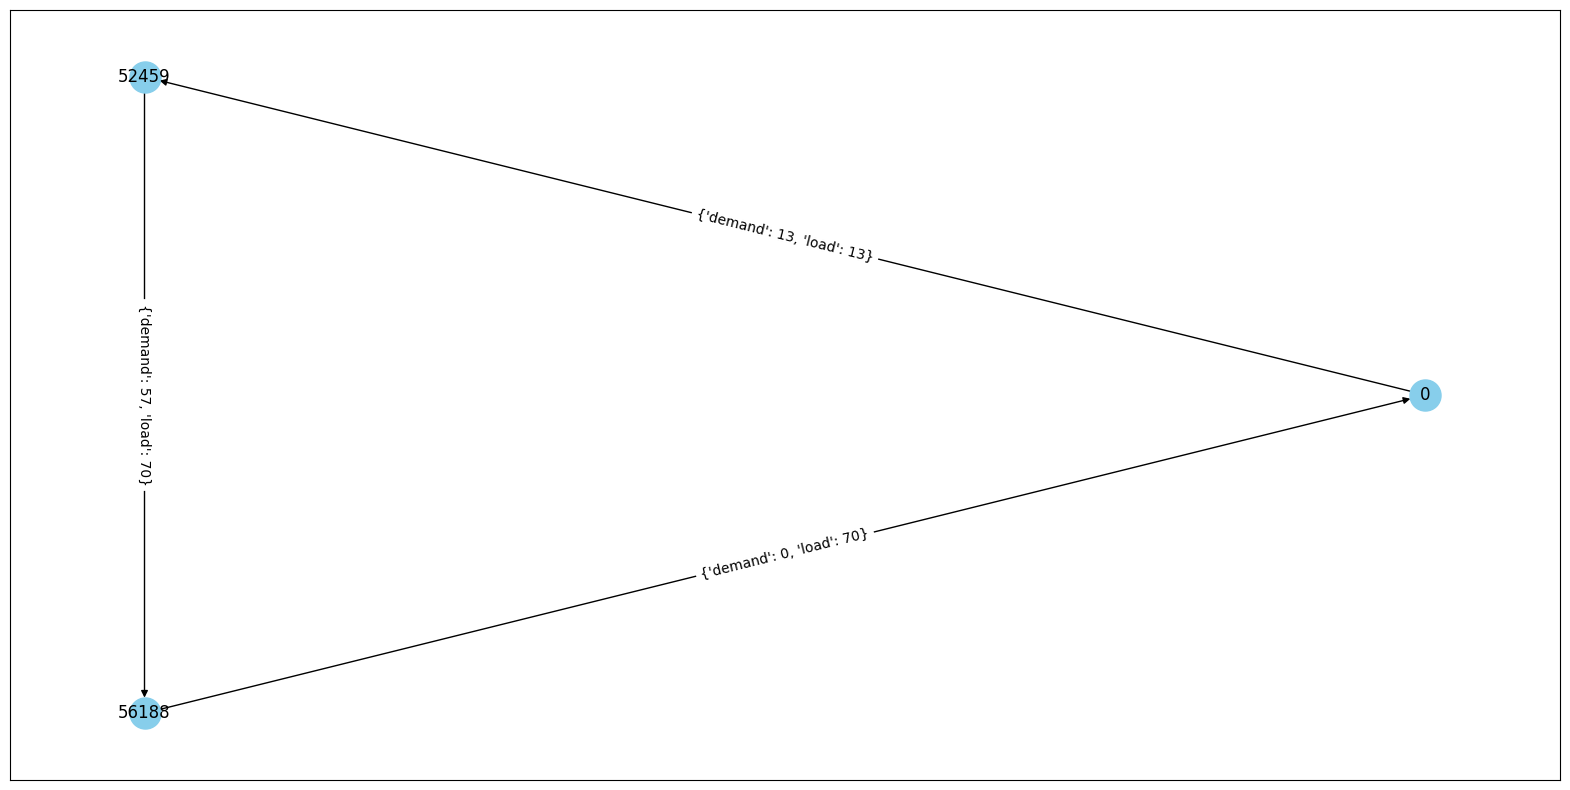



Bus 6:


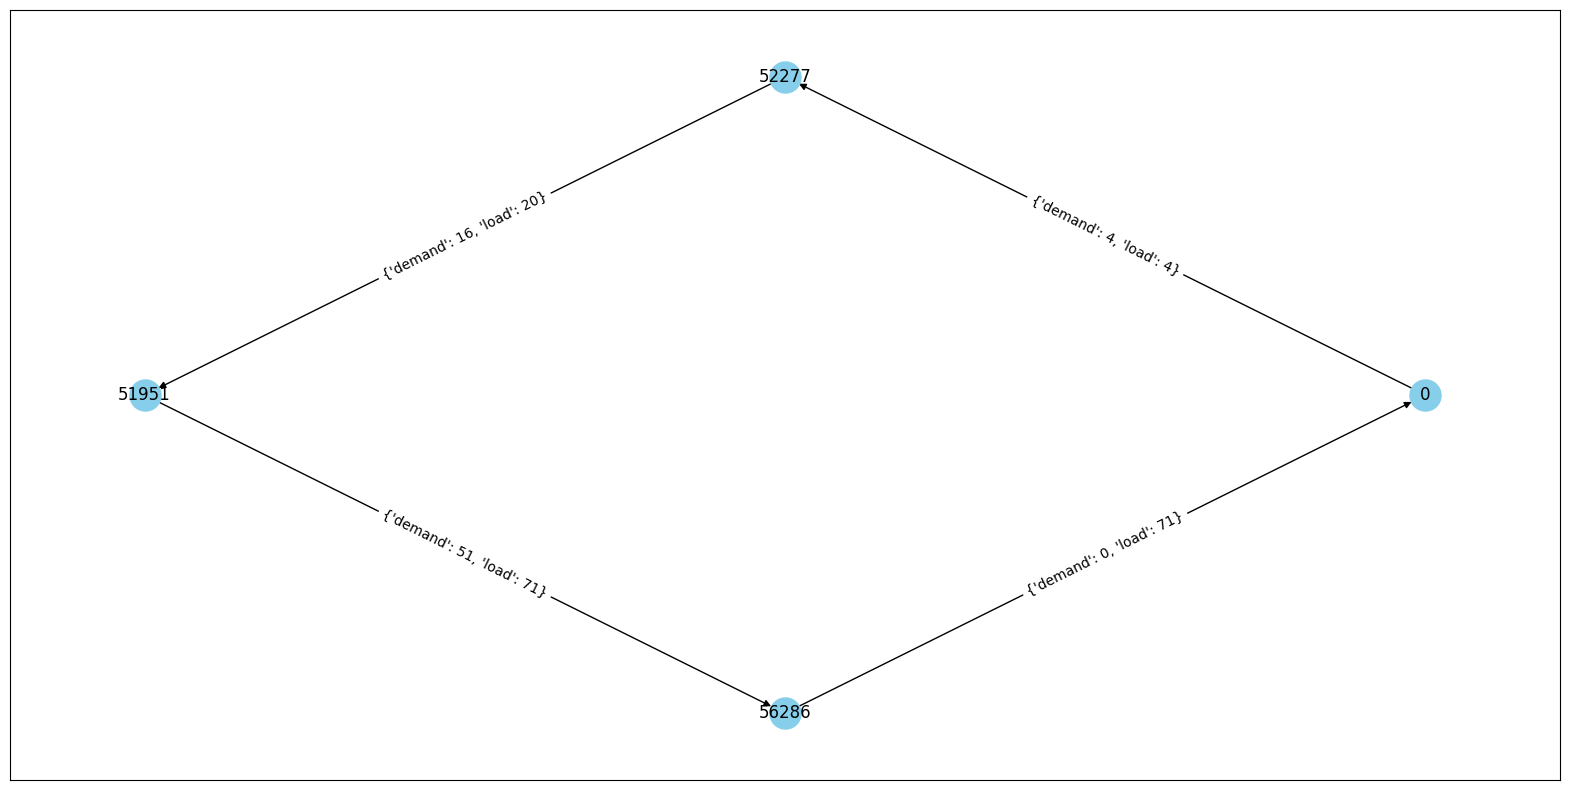



Bus 7:


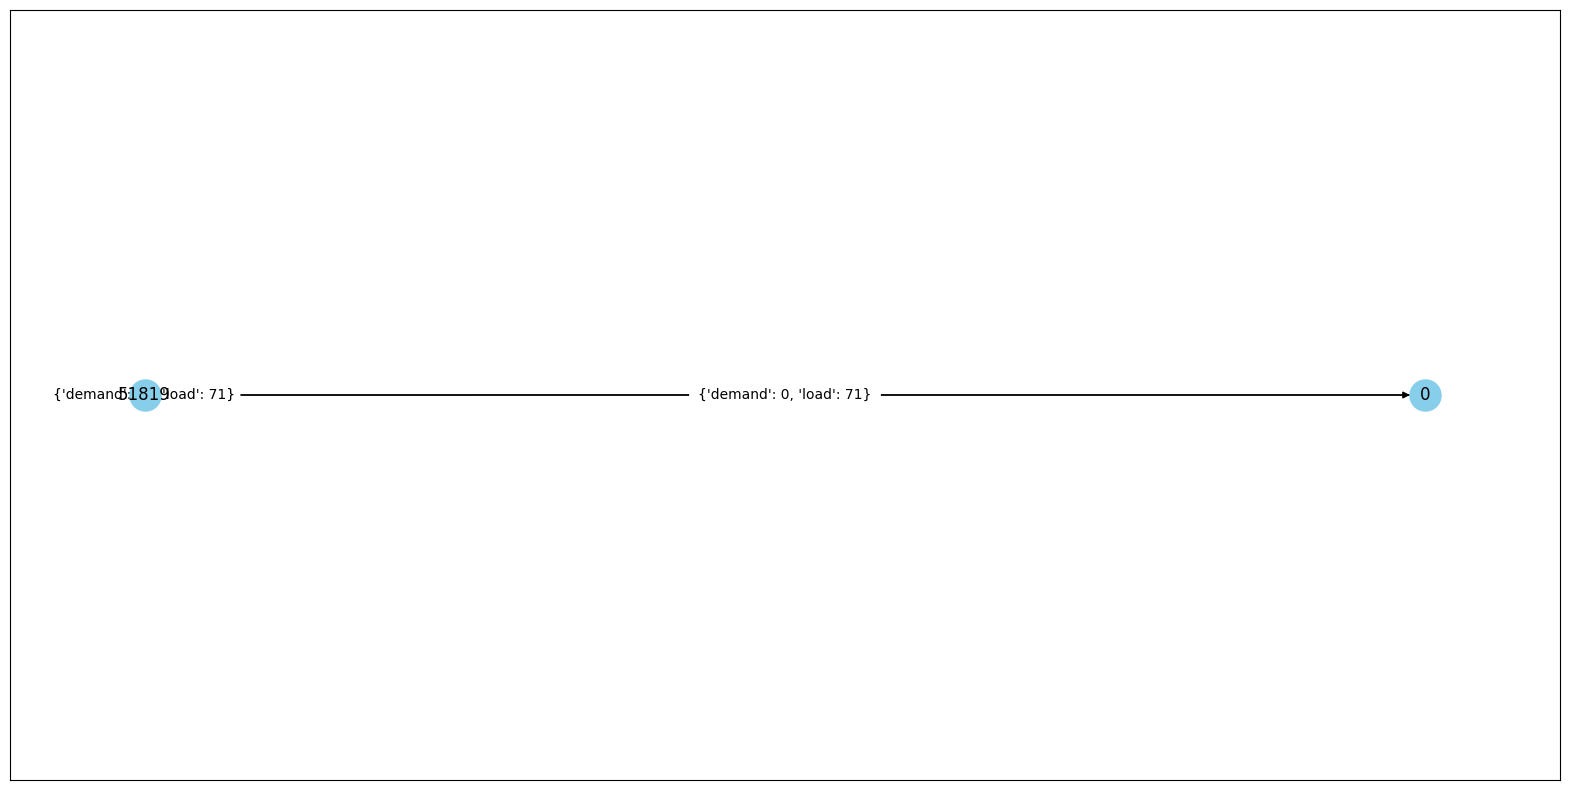



Bus 8:


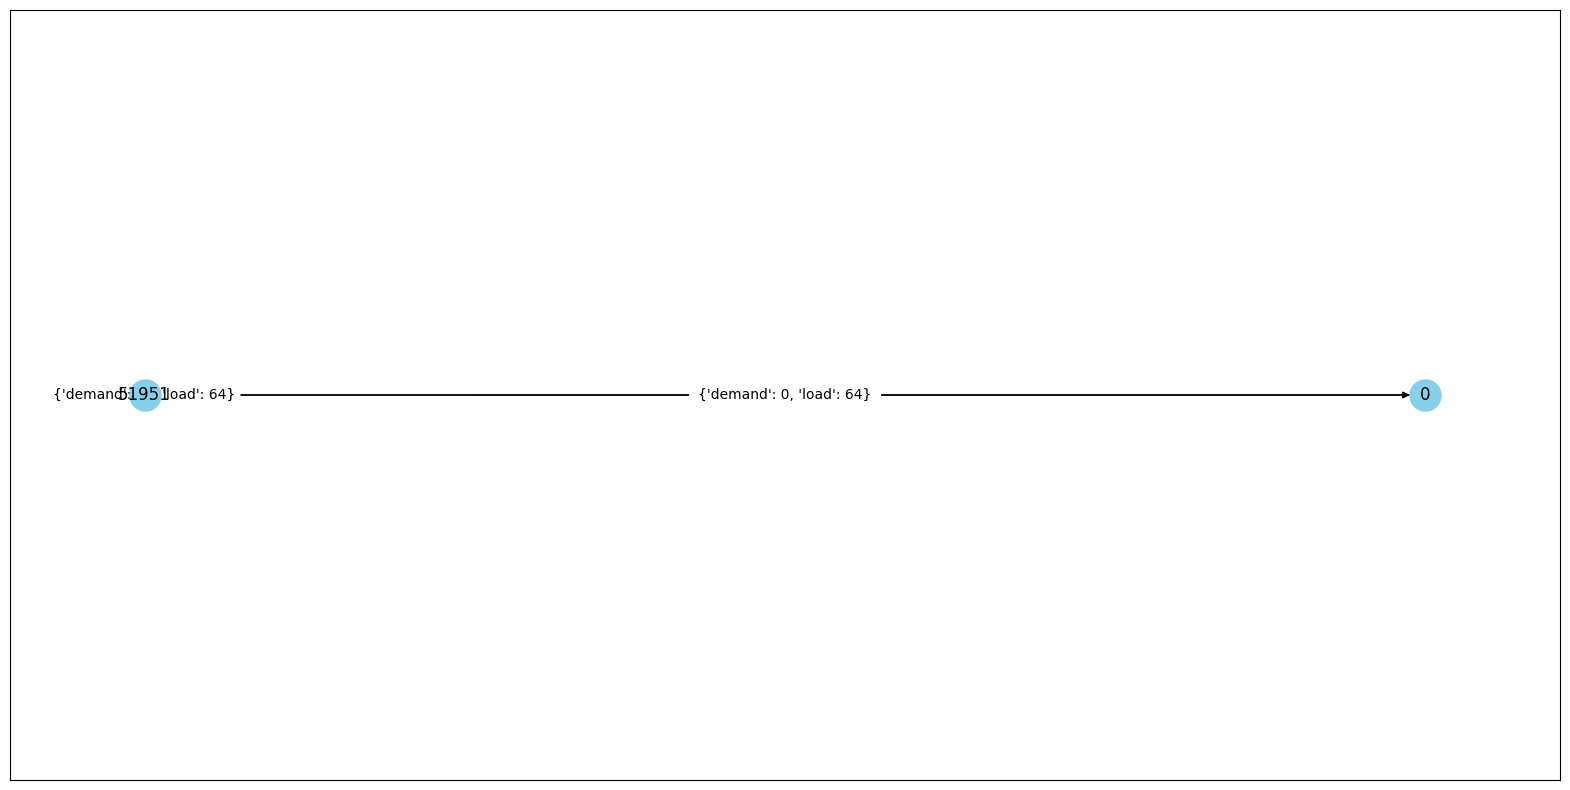



Bus 9:


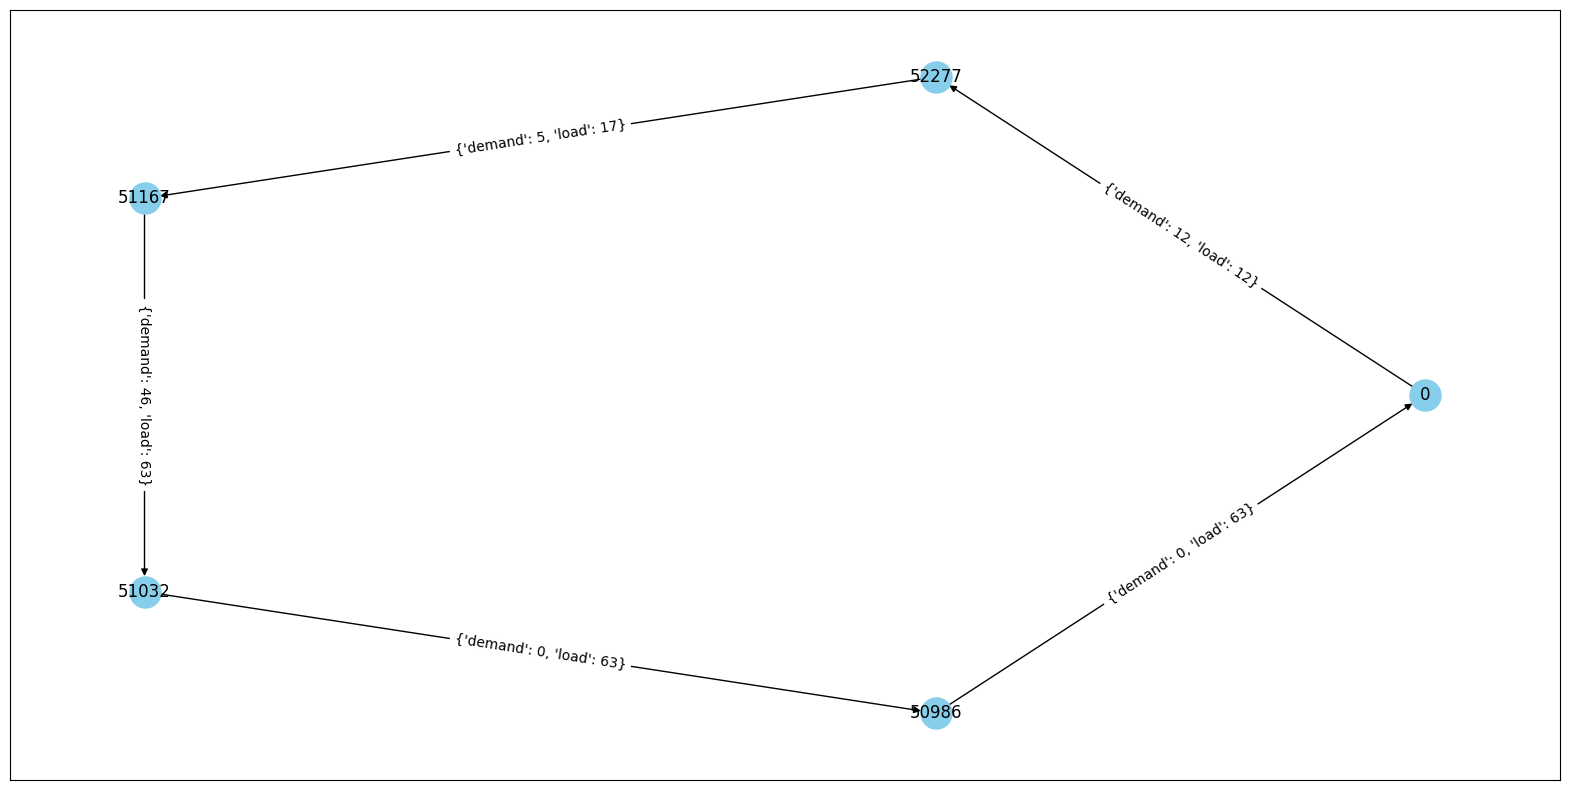



Bus 10:


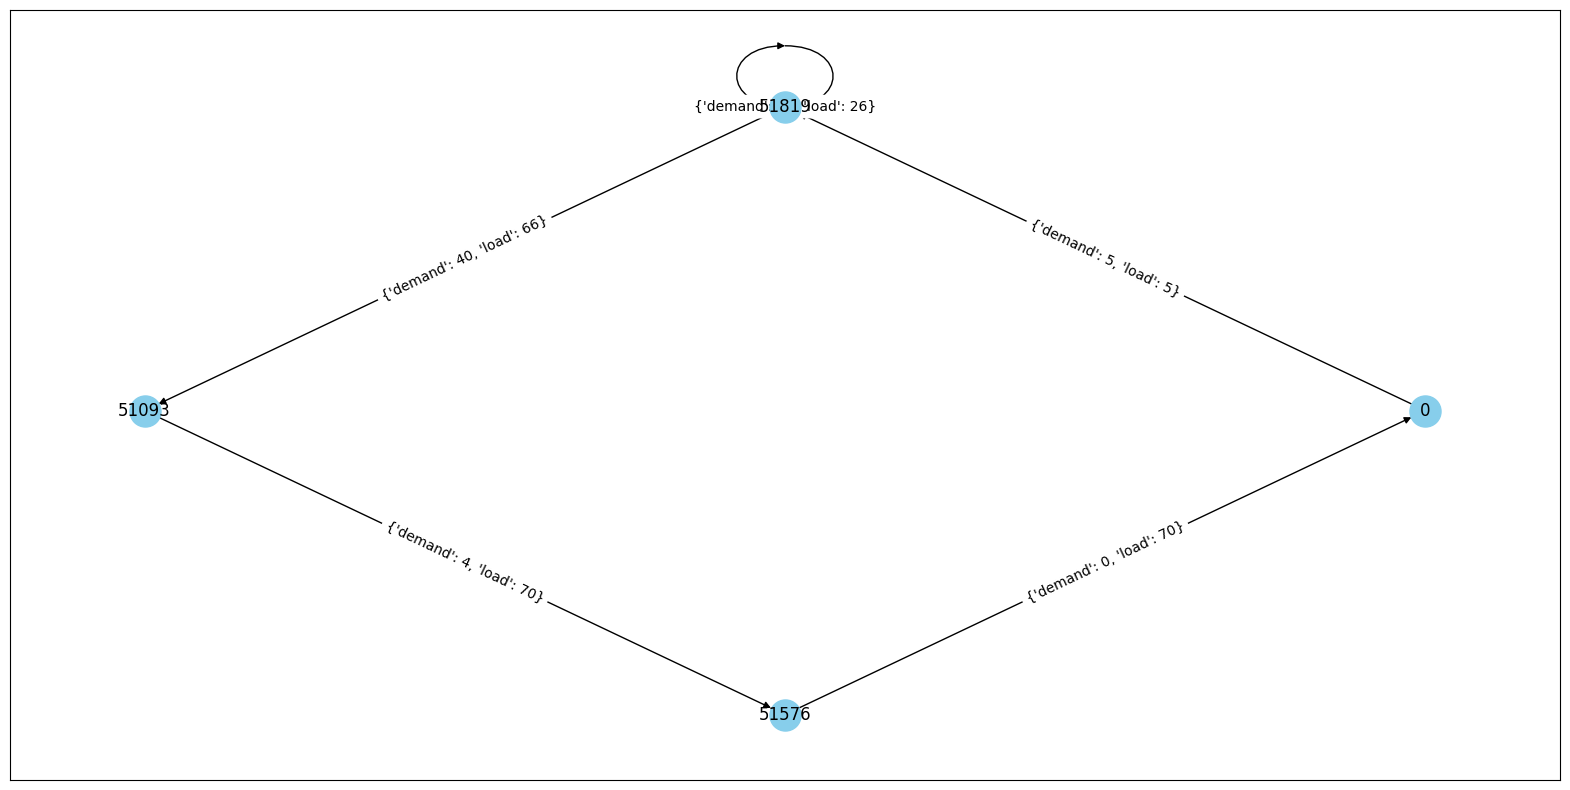

In [52]:
for bus in bus_path_df.bus.unique():
    print(f"Bus {bus + 1}:")

    bus_route = bus_path_df[bus_path_df["bus"] == bus].reset_index(drop=True)

    plt.figure(figsize=(20, 10))

    g = nx.DiGraph()

    for segment in bus_route.itertuples():
        g.add_edge(
            segment.start_stop,
            segment.end_stop,
            weight=segment.distance,
            demands={"demand": segment.demand, "load": segment.step_demand},
            step=segment.step,
            label=f"{segment.start_stop}-{segment.end_stop}",
            load=segment.step_demand,
        )

    pos = nx.circular_layout(g)

    nx.draw_networkx(g, pos, with_labels=True, node_size=500, node_color="skyblue")
    nx.draw_networkx_edge_labels(
        g, pos, edge_labels=nx.get_edge_attributes(g, "demands")
    )

    plt.show()

    print("\n")

In [53]:
routes_gdf = (
    gpd.GeoDataFrame(bus_path_df.groupby("bus")["geometry"].apply(list))
    .rename(columns={"points": "geometry"})
    .reset_index()
)

# add depot to each geometry
routes_gdf["points"] = routes_gdf.apply(
    lambda x: [Point((float(depot.stop_lon), float(depot.stop_lat)))] + x.geometry,
    axis=1,
)

routes_gdf["geometry"] = routes_gdf["points"].apply(LineString)
routes_gdf.drop(columns=["points"], inplace=True)

routes_gdf = routes_gdf.merge(
    bus_path_df.groupby("bus")["demand"].sum().rename("demand").reset_index(),
    on="bus",
)

routes_gdf = gpd.GeoDataFrame(routes_gdf, geometry="geometry")
routes_gdf.crs = "EPSG:4326"

display(routes_gdf)

,bus,geometry,demand
0,0,"LINESTRING (-73.56912 45.50485, -73.52561 45.5...",63
1,1,"LINESTRING (-73.56912 45.50485, -73.55503 45.5...",68
2,2,"LINESTRING (-73.56912 45.50485, -73.57663 45.5...",64
3,3,"LINESTRING (-73.56912 45.50485, -73.57477 45.5...",27
4,4,"LINESTRING (-73.56912 45.50485, -73.57076 45.5...",70
5,5,"LINESTRING (-73.56912 45.50485, -73.57663 45.5...",71
6,6,"LINESTRING (-73.56912 45.50485, -73.59108 45.5...",71
7,7,"LINESTRING (-73.56912 45.50485, -73.58804 45.4...",64
8,8,"LINESTRING (-73.56912 45.50485, -73.57663 45.5...",63
9,9,"LINESTRING (-73.56912 45.50485, -73.59108 45.5...",70


### Map the routes

In [54]:
colormap_route = [
    mcolors.rgb2hex(c) for c in list(plt.cm.rainbow(np.linspace(0, 1, num_buses)))
]

route_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(route_map)

for stop in bus_path_df.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color=colormap_route[stop.bus] if stop.stop_id != "0" else "black",
        fill=True,
        fill_opacity=1,
        fill_color=colormap_route[stop.bus] if stop.stop_id != "0" else "black",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        <br>
        Route: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['bus'].values[0] + 1}
        <br>
        Step: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step'].values[0] + 1}
        <br>
        Demand: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['demand'].values[0]}
        <br>
        Load: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step_demand'].values[0]}
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)

for stop in stops_in_disaster_area.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="red",
        fill=True,
        fill_opacity=1,
        fill_color="red",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)


for route in routes_gdf.itertuples():
    route_layer = folium.FeatureGroup(f"Route {route.bus + 1}")
    folium.PolyLine(
        locations=[(p[1], p[0]) for p in route.geometry.coords],
        color=colormap_route[route.bus],
        weight=3,
        opacity=0.6,
        tooltip=f"Route {route.bus + 1}",
        popup=f"""
        <div>
            <h5>Route {route.bus + 1}</h5>
            <h5>Total demand: {route.demand}</h5>
        </div>
        """,
    ).add_to(route_layer)

    route_layer.add_to(route_map)

folium.plugins.Fullscreen(position="topright").add_to(route_map)
folium.plugins.MousePosition(position="topright").add_to(route_map)
folium.LayerControl().add_to(route_map)

route_map.save("route_map_split_random.html")
route_map